In [1]:
# header files loaded
import numpy as np
import cv2
import glob
from ReadCameraModel import *
from UndistortImage import *
from scipy.optimize import leastsq

In [2]:
files = glob.glob("/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/*")
files = sorted(files)
print(files)

['/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444704913.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444767404.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444829896.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444892384.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381444954879.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445017371.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445079860.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445142354.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445204845.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445267335.png', '/home/arpitdec5/Desktop/structure_from_motion/data/stereo/centre/1399381445329828.png', '/home/arpitdec5/Des

In [37]:
# get the image
def get_image(file):
    """
    Inputs:
    
    file: the file to be read
    
    Outputs:
    
    image: numpy array representing the image
    """
    
    image = cv2.imread(file, 0)
    image = cv2.cvtColor(image, cv2.COLOR_BayerGR2BGR)
    fx, fy, cx, cy, camera_image, LUT = ReadCameraModel("../data/model/")
    k_matrix = np.zeros((3, 3))
    k_matrix[0, 0] = fx
    k_matrix[1, 1] = fy
    k_matrix[2, 2] = 1
    k_matrix[0, 2] = cx
    k_matrix[1, 2] = cy
    image = UndistortImage(image, LUT)
    return (image, k_matrix)


#  get transformation matrices
def get_transformation_matrix(pl, pr):
    
    # mean for ptsLeft and ptsRight
    ptsLeft_mean_x = np.mean(pl[:, 0])
    ptsLeft_mean_y = np.mean(pl[:, 1])
    ptsRight_mean_x = np.mean(pr[:, 0])
    ptsRight_mean_y = np.mean(pr[:, 1])
    
    # scale factor for ptsLeft and ptsRight
    scale_ptsLeft = np.sqrt(2) / np.sum(((pl[:, 0] - ptsLeft_mean_x) ** 2 + (pl[:, 1] - ptsLeft_mean_y) ** 2) ** (1 / 2))
    scale_ptsRight = np.sqrt(2) / np.sum(((pr[:, 0] - ptsRight_mean_x) ** 2 + (pr[:, 1] - ptsRight_mean_y) ** 2) ** (1 / 2))
    
    # get transformation matrices
    ptsLeft_transformation_matrix = np.dot(np.array([[scale_ptsLeft, 0, 0], [0, scale_ptsLeft, 0], [0, 0, 1]]), np.array([[1, 0, -ptsLeft_mean_x], [0, 1, -ptsLeft_mean_y], [0, 0, 1]]))
    ptsRight_transformation_matrix = np.dot(np.array([[scale_ptsRight, 0, 0], [0, scale_ptsRight, 0], [0, 0, 1]]), np.array([[1, 0, -ptsRight_mean_x], [0, 1, -ptsRight_mean_y], [0, 0, 1]]))
    
    # get normalized points
    for index in range(0, len(pl)):
        pl[index][0] = (pl[index][0] - ptsLeft_mean_x) * scale_ptsLeft
        pl[index][1] = (pl[index][1] - ptsLeft_mean_y) * scale_ptsLeft
        
    for index in range(0, len(pr)):
        pr[index][0] = (pr[index][0] - ptsRight_mean_x) * scale_ptsRight
        pr[index][1] = (pr[index][1] - ptsRight_mean_y) * scale_ptsRight
    
    # return matrices
    return (pl, pr, ptsLeft_transformation_matrix, ptsRight_transformation_matrix)


# get keypoints between frame 1 and frame 2
def get_keypoints(image1, image2):
    """
    Inputs:
    
    image1: left image
    image2: right image
    
    Outputs:
    
    pl: point correspondences for left image
    pr: point correspondences for right image
    """
    
    # use sift keypoint to get the points
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1,None)
    kp2, des2 = sift.detectAndCompute(image2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    pl = []
    pr = []

    for i,(m,n) in enumerate(matches):
        if m.distance < (0.5*n.distance):
            pl.append(kp1[m.queryIdx].pt)
            pr.append(kp2[m.trainIdx].pt)
    return (np.array(pl), np.array(pr))


# get fundamental matrix with ransac
def get_fundamental_matrix_ransac(pl, pr):
    """
    Inputs:
    
    pl: array of 8 points for left image
    pr: array of 8 points for right image
    
    Outputs:
    
    fundamental_mat: fundamental matrix of size (3 x 3)
    """
    
    # normalise points
    (pl, pr, ptsLeft_transformation_matrix, ptsRight_transformation_matrix) = get_transformation_matrix(pl, pr)

    # ransac for better matrix estimation
    iterations = 2000
    threshold = 0.06
    count = 0
    best_ptsLeft = []
    best_ptsRight = []
    best_fundamental_matrix = get_fundamental_matrix(pl[:8], pr[:8], ptsLeft_transformation_matrix, ptsRight_transformation_matrix)
    for iteration in range(0, iterations):
        
        indexes = np.random.randint(len(ptsLeft), size = 8)
        random_ptsLeft = np.array([pl[indexes[0]], pl[indexes[1]], pl[indexes[2]], pl[indexes[3]], pl[indexes[4]], pl[indexes[5]], pl[indexes[6]], pl[indexes[7]]])
        random_ptsRight = np.array([pr[indexes[0]], pr[indexes[1]], pr[indexes[2]], pr[indexes[3]], pr[indexes[4]], pr[indexes[5]], pr[indexes[6]], pr[indexes[7]]])
    
        estimated_fundamental_mat = get_fundamental_matrix(random_ptsLeft, random_ptsRight, ptsLeft_transformation_matrix, ptsRight_transformation_matrix)
        estimated_count = 0
        sample_ptsLeft = []
        sample_ptsRight = []
        for index in range(0, len(pl)):
            x_right = np.array([pr[index][0], pr[index][1], 1])
            x_left = np.array([pl[index][0], pl[index][1], 1]).T
            
            if(abs(np.squeeze(np.matmul((np.matmul(x_right, estimated_fundamental_mat)), x_left))) < threshold):
                estimated_count = estimated_count + 1
                sample_ptsLeft.append(pl[index])
                sample_ptsRight.append(pr[index])
                
        if(estimated_count > count):
            count = estimated_count
            best_fundamental_matrix = estimated_fundamental_mat
            best_ptsLeft = sample_ptsLeft
            best_ptsRight = sample_ptsRight
    
    # return fundamental matrix
    return (best_fundamental_matrix, np.array(best_ptsLeft), np.array(best_ptsRight))
    
    
# get fundamental matrix
def get_fundamental_matrix(pointsLeft, pointsRight, ptsLeft_transformation_matrix, ptsRight_transformation_matrix):
    """
    Inputs:
    
    pointsLeft: array of 8 points for left image
    pointsRight: array of 8 points for right image
    ptsLeft_transformation_matrix: transformation matrix for left image
    ptsRight_transformation_matrix: transformation matrix for right image
    
    Outputs:
    
    fundamental_mat: fundamental matrix of size (3 x 3)
    """
    
    # construct a matrix
    a_matrix = []
    for index in range(0, len(pointsLeft)):
        x, y = pointsLeft[index][0], pointsLeft[index][1]
        u, v = pointsRight[index][0], pointsRight[index][1]
        a_matrix.append([x * u, y * u, u, x * v, y * v, v, x, y, 1])
    
    # svd of A
    a_matrix = np.array(a_matrix)
    u, s, vh = np.linalg.svd(a_matrix)
        
    # compute fundamental_mat
    vh = vh.T
    fundamental_mat = vh[:, -1]
    fundamental_mat = fundamental_mat.reshape((3, 3))
    
    # enforce rank 2 constraint and update fundamental_mat
    u, s, vh = np.linalg.svd(fundamental_mat)
    s[2] = 0
    fundamental_mat = np.dot(u, np.dot(np.diag(s), vh))
    
    # un-normalize fundamental_mat
    fundamental_mat = np.dot(ptsRight_transformation_matrix.T, np.dot(fundamental_mat, ptsLeft_transformation_matrix))
    #fundamental_mat = fundamental_mat / np.linalg.norm(fundamental_mat)
    
    # return the matrix
    return fundamental_mat


# estimate essential matrix
def get_essential_matrix(fundamental_matrix, k_matrix):
    """
    Inputs:
    
    fundamental_matrix: Matrix that relates image coordinates in one image to the other
    k_matrix: the calibration matrix of the camera
    
    Outputs:
    
    essential_matrix: return essential matrix
    """
    
    essential_matrix = np.dot(k_matrix.T, np.dot(fundamental_matrix, k_matrix))
    u, s, vh = np.linalg.svd(essential_matrix)
    s[0] = 1
    s[1] = 1
    s[2] = 0
    essential_matrix = np.dot(u, np.dot(np.diag(s), vh))
    #essential_matrix = essential_matrix / np.linalg.norm(essential_matrix)
    
    # return matrix
    return essential_matrix


#function to extract camera poses from essential matrix
def get_camera_poses(essential_matrix):
    """
    Inputs:
    
    essential_matrix: return essential matrix
    
    Outputs:
    
    (r1, r2, r3, r4, c1, c2, c3, c4): four possible camera poses, that is, four rotation matrices and four translation matrices
    """
    
    # define rotation matrix and get svd decomposition of essential matrix
    w = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    u, d, v = np.linalg.svd(essential_matrix, full_matrices=True)

    # define four camera poses (c1, r1), (c2, r2), (c3, r3), (c4, r4)
    c1 = u[:, 2]
    c2 = -u[:, 2]
    c3 = u[:, 2]
    c4 = -u[:, 2]
    r1 = np.dot(u, np.dot(w, v))
    r2 = np.dot(u, np.dot(w, v))
    r3 = np.dot(u, np.dot(w.T, v))
    r4 = np.dot(u, np.dot(w.T, v))

    if np.linalg.det(r1) < 0:
        r1 = -r1
        c1 = -c1
    if np.linalg.det(r2) < 0:
        r2 = -r2
        c2 = -c2
    if np.linalg.det(r3) < 0:
        r3 = -r3
        c3 = -c3
    if np.linalg.det(r4) < 0:
        r4 = -r4
        c4 = -c4
    
    # reshape the translation matrices
    c1 = c1.reshape(-1, 1)
    c2 = c2.reshape(-1, 1)
    c3 = c3.reshape(-1, 1)
    c4 = c4.reshape(-1, 1)
    
    # return four possible camera poses
    return [[np.array(c1), np.array(c2), np.array(c3), np.array(c4)], [np.array(r1), np.array(r2), np.array(r3), np.array(r4)]]


# determines whether the point is in front of camera or not
def is_point_in_front(camera_pose, point):
    """
    Inputs:
    
    camera_pose: the camera pose
    point: the 3D point in camera coordinate system
    
    Output: 
    
    True/False: tells whether the point is in front of the camera or not
    """
    
    r = camera_pose[:, :-1]
    t = camera_pose[:, -1:]

    # cheirality condition
    if((np.dot(r[2, :], (point - t))) > 0):
        return True
    return False 


# performs linear triangulation
def get_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight):
    """
    Inputs:
    
    camera_pose_1: the base camera pose
    camera_pose_2: the camera pose
    pointLeft: the image point in the left image
    pointRight: the image point in the right image
    k_matrix: the camera matrix
    
    Output: 
    
    point: the 3D point in camera coordinate system
    """

    # get the cross-product matrix for point-1 and point-2
    pointLeft_cross_product = np.array([[0, -1, pointLeft[1]], [1, 0, -pointLeft[0]], [-pointLeft[1], pointLeft[0], 0]])
    pointRight_cross_product = np.array([[0, -1, pointRight[1]], [1, 0, -pointRight[0]], [-pointRight[1], pointRight[0], 0]])
    
    # get the m_matrix
    camera_pose_1 = camera_pose_1[:-1, :]
    m_matrix = np.vstack([np.dot(pointLeft_cross_product, camera_pose_1[:3, :]), np.dot(pointRight_cross_product, camera_pose_2)])
    
    # get the 3D point
    u, s, vh = np.linalg.svd(m_matrix)
    point = vh[-1]
    point = (point / point[3]).reshape((4, 1))
    point = point[:3].reshape((3, 1))
    
    # return point
    return point
    
    
# performs non-linear triangulation
def get_non_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight):
    """
    Inputs:
    
    camera_pose_1: the base camera pose
    camera_pose_2: the camera pose
    pointLeft: the image point in the left image
    pointRight: the image point in the right image
    k_matrix: the camera matrix
    
    Output: 
    
    point: the 3D point in camera coordinate system
    """
    
    # perform linear triangulation and get linear estimate
    estimated_point = get_linear_triangulation(camera_pose_1, camera_pose_2, pointLeft, pointRight)
    
    # run Levenberg-Marquardt algorithm
    args = (camera_pose_1, camera_pose_2, pointLeft, pointRight)
    point, success = leastsq(get_triangulation_error, estimated_point, args = args, maxfev = 10000)
    point = np.matrix(point).T
    
    # return point
    return point


# the triangulation error function for non-linear triangulation
def get_triangulation_error(estimated_point, camera_pose_1, camera_pose_2, pointLeft, pointRight):

    # project into each frame
    estimated_point = np.array([estimated_point[0, 0], estimated_point[1, 0], estimated_point[2, 0], [1]])
    estimated_ptLeft = fromHomogenous(np.dot(camera_pose_1, estimated_point))
    estimated_ptRight = fromHomogenous(np.dot(camera_pose_2, estimated_point))
    estimated_ptLeft = np.array([estimated_ptLeft[0, 0] / estimated_ptLeft[2, 0], estimated_ptLeft[0, 0] / estimated_ptLeft[1, 0]])
    estimated_ptRight = np.array([estimated_ptRight[0, 0] / estimated_ptRight[2, 0], estimated_ptRight[0, 0] / estimated_ptRight[1, 0]])
    
    # compute the diffs
    diff1 = estimated_ptLeft - pointLeft
    diff2 = estimated_ptRight - pointRight

    # return error
    return np.asarray(np.vstack([diff1, diff2]).T)[0, :]
    
    
# estimate the best camera pose
def get_best_camera_pose(translation_matrices, rotation_matrices, base_pose, ptsLeft, ptsRight):
    """
    Inputs:
    
    translation_matrices: set of translation matrices
    rotation_matrices: set of rotation matrices
    base_pose: the base pose
    ptsLeft: the point correspondences for left image
    ptsRight: the point correspondences for right image
    
    Output: 
    
    best_pose: the best camera pose for the frame
    """
    
    # form four possible camera matrices
    camera_pose_1 = np.hstack([rotation_matrices[0], translation_matrices[0]])
    camera_pose_2 = np.hstack([rotation_matrices[1], translation_matrices[1]])
    camera_pose_3 = np.hstack([rotation_matrices[2], translation_matrices[2]])
    camera_pose_4 = np.hstack([rotation_matrices[3], translation_matrices[3]])
    
    # linear triangulation to find best pose
    best_count = 0
    best_pose = camera_pose_1
    for camera_pose in [camera_pose_1, camera_pose_2, camera_pose_3, camera_pose_4]:
        
        # loop through each point correspondence
        count = 0
        for index in range(0, len(ptsLeft)):
            pointLeft = ptsLeft[index]
            pointRight = ptsRight[index]
            
            # perform linear triangulation
            point = get_linear_triangulation(base_pose, camera_pose, pointLeft, pointRight)
            
            # check in front of the camera
            if(is_point_in_front(camera_pose, point)):
                count = count + 1
                
        # update best_pose found
        if(count > best_count):
            best_count = count
            best_pose = camera_pose
            
    # assuming motion is forward
    #if(best_pose[2, 3] > 0):
    #    best_pose[2, 3] = -best_pose[2, 3]
            
    # return best camera pose
    return best_pose

Relative Depth: -0.9354703210554518
Relative x: 0.20671820365109375
Relative Original Depth: 0.9700522039303199
Relative Original x: 0.0356900468936508
Count:2
()
()
Relative Depth: -1.8150765944530796
Relative x: 0.5523014876589836
Relative Original Depth: -0.020040037553694545
Relative Original x: 0.10243292320719422
Count:3
()
()
Relative Depth: -2.7070109204496533
Relative x: 0.4771628142496859
Relative Original Depth: -1.0115898885009855
Relative Original x: 0.12659084271128945
Count:4
()
()
Relative Depth: -2.009441021655569
Relative x: 0.6402659810517545
Relative Original Depth: -1.997648003911603
Relative Original x: 0.027902550980015442
Count:5
()
()
Relative Depth: -2.6721596918862147
Relative x: -0.10846420153949832
Relative Original Depth: -1.0195344982609855
Relative Original x: 0.01540625530516212


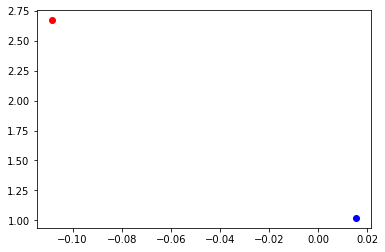

Count:6
()
()
Relative Depth: -2.974273248132584
Relative x: -0.9370128867710643
Relative Original Depth: -0.03457608974921833
Relative Original x: -0.0266379083531132
Count:7
()
()
Relative Depth: -3.5520151638454776
Relative x: -1.6059650193506139
Relative Original Depth: -1.015013136487203
Relative Original x: 0.03610052084117885
Count:8
()
()
Relative Depth: -4.140420295536725
Relative x: -2.0968513398069395
Relative Original Depth: -0.030498664519126195
Relative Original x: -0.0250338012253037
Count:9
()
()
Relative Depth: -4.197000421908331
Relative x: -2.4722468110562406
Relative Original Depth: 0.9461721108024828
Relative Original x: -0.03929433243706016
Count:10
()
()
Relative Depth: -4.134658548380471
Relative x: -2.611731670575604
Relative Original Depth: -0.046879470331672835
Relative Original x: 0.03463453512577528


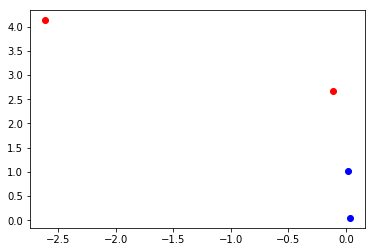

Count:11
()
()
Relative Depth: -3.8905026516371986
Relative x: -2.8419844601656297
Relative Original Depth: -1.0234558318395726
Relative Original x: -0.045712817030959134
Count:12
()
()
Relative Depth: -3.5613648134153384
Relative x: -2.004261957415609
Relative Original Depth: -2.007298255239932
Relative Original x: 0.038263980304922764
Count:13
()
()
Relative Depth: -4.444101998184244
Relative x: -2.3549401868821453
Relative Original Depth: -1.0238121624113625
Relative Original x: -0.04082241852386686
Count:14
()
()
Relative Depth: -5.38472123935451
Relative x: -2.2678390711269474
Relative Original Depth: -1.9985873499823774
Relative Original x: 0.03793442131454019
Count:15
()
()
Relative Depth: -6.234389807655702
Relative x: -2.1416051971213346
Relative Original Depth: -1.0180112916171278
Relative Original x: -0.005552715936996813


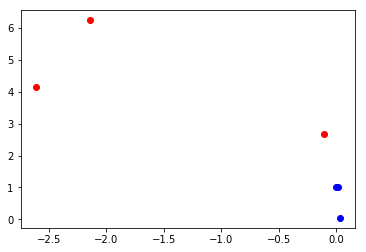

Count:16
()
()
Relative Depth: -7.152564460779882
Relative x: -2.5346725726577937
Relative Original Depth: -0.03378061726904169
Relative Original x: 0.00909434717950523
Count:17
()
()
Relative Depth: -7.902286724927775
Relative x: -3.177144078201892
Relative Original Depth: -1.0149582263951547
Relative Original x: 0.012214071050270642
Count:18
()
()
Relative Depth: -8.716574322688658
Relative x: -3.7534161508180217
Relative Original Depth: -1.996867252764614
Relative Original x: 0.09664056775873073
Count:19
()
()
Relative Depth: -9.567638802307098
Relative x: -4.275665117573526
Relative Original Depth: -2.964669633426356
Relative Original x: 0.1983720588500606
Count:20
()
()
Relative Depth: -10.406785002883028
Relative x: -4.802757559704909
Relative Original Depth: -3.9335691605209537
Relative Original x: 0.2577977770300821


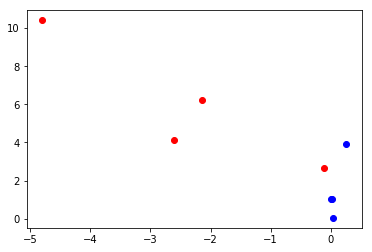

Count:21
()
()
Relative Depth: -11.207599824384781
Relative x: -5.264271163917075
Relative Original Depth: -2.956506713165621
Relative Original x: 0.19799407231995136
Count:22
()
()
Relative Depth: -12.047211483042512
Relative x: -5.505779684940372
Relative Original Depth: -1.969459964046321
Relative Original x: 0.13489060815467613
Count:23
()
()
Relative Depth: -12.985181724485464
Relative x: -5.851218976441568
Relative Original Depth: -2.9503162846129314
Relative Original x: 0.12890200567345222
Count:24
()
()
Relative Depth: -12.827475609063256
Relative x: -6.656912665387446
Relative Original Depth: -3.927936791528036
Relative Original x: 0.16814223075542675
Count:25
()
()
Relative Depth: -13.554421933680281
Relative x: -7.185965005950125
Relative Original Depth: -4.9113208013953
Relative Original x: 0.1701029815133018


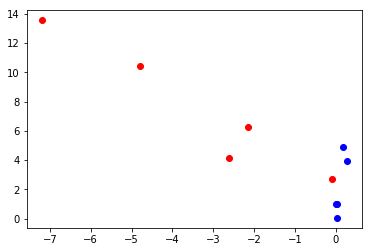

Count:26
()
()
Relative Depth: -14.248225259386434
Relative x: -7.609611199831154
Relative Original Depth: -5.904205793831362
Relative Original x: 0.20537912054866958
Count:27
()
()
Relative Depth: -14.812812332940581
Relative x: -8.088158966424603
Relative Original Depth: -6.878181930801632
Relative Original x: 0.20164524164294723
Count:28
()
()
Relative Depth: -15.103003675618627
Relative x: -8.652040579293887
Relative Original Depth: -7.858620615344497
Relative Original x: 0.18739920754402792
Count:29
()
()
Relative Depth: -15.065289371521667
Relative x: -8.976104108121703
Relative Original Depth: -8.826689643850619
Relative Original x: 0.2156657406212003
Count:30
()
()
Relative Depth: -15.064795887805916
Relative x: -8.944525505015214
Relative Original Depth: -9.810885857784381
Relative Original x: 0.25261334082328013


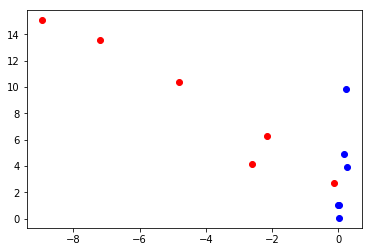

Count:31
()
()
Relative Depth: -15.176353512783741
Relative x: -8.68324949333731
Relative Original Depth: -10.796663683285903
Relative Original x: 0.2957088800444888
Count:32
()
()
Relative Depth: -15.335854525112305
Relative x: -8.30461772958823
Relative Original Depth: -11.770201657652139
Relative Original x: 0.2978881752814203
Count:33
()
()
Relative Depth: -16.187979599573183
Relative x: -8.03764884455544
Relative Original Depth: -12.740873525093507
Relative Original x: 0.24100687736035037
Count:34
()
()
Relative Depth: -16.690673216903967
Relative x: -7.71804724949289
Relative Original Depth: -13.710761110608054
Relative Original x: 0.20632856468688746
Count:35
()
()
Relative Depth: -17.062376933123826
Relative x: -8.041141368344608
Relative Original Depth: -14.68440592015182
Relative Original x: 0.22039934276539333


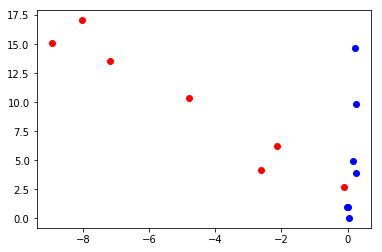

Count:36
()
()
Relative Depth: -17.43666074926492
Relative x: -7.726934556134629
Relative Original Depth: -15.65634479084676
Relative Original x: 0.18809902014877647
Count:37
()
()
Relative Depth: -18.125785059149003
Relative x: -7.702734510238268
Relative Original Depth: -16.631827755191505
Relative Original x: 0.15303626379907098
Count:38
()
()
Relative Depth: -19.036187175425702
Relative x: -7.876034354575097
Relative Original Depth: -17.615807957637696
Relative Original x: 0.0710057465704482
Count:39
()
()
Relative Depth: -18.506772718444132
Relative x: -7.4371795099950875
Relative Original Depth: -18.587293556189994
Relative Original x: 0.13812403048222532
Count:40
()
()
Relative Depth: -19.489694788006478
Relative x: -7.529983622724362
Relative Original Depth: -19.569475221455516
Relative Original x: 0.14814220493239447


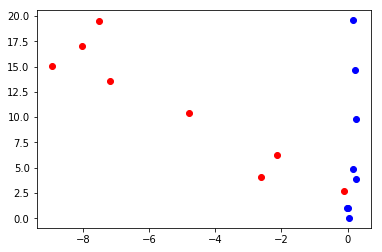

Count:41
()
()
Relative Depth: -20.28550450666276
Relative x: -7.724553852296619
Relative Original Depth: -20.55081027924549
Relative Original x: 0.14164508366883602
Count:42
()
()
Relative Depth: -20.29984920145454
Relative x: -7.902464704351999
Relative Original Depth: -21.524052523148125
Relative Original x: 0.1660163634113224
Count:43
()
()
Relative Depth: -20.049526923835174
Relative x: -8.044624438090473
Relative Original Depth: -22.50452193637017
Relative Original x: 0.18280977229480105
Count:44
()
()
Relative Depth: -19.818686199052337
Relative x: -8.200131339151781
Relative Original Depth: -23.479489707747586
Relative Original x: 0.18565266146735152
Count:45
()
()
Relative Depth: -19.68142533692385
Relative x: -8.50964673064461
Relative Original Depth: -24.46257549459618
Relative Original x: 0.19848349938928347


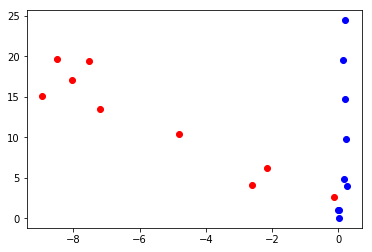

Count:46
()
()
Relative Depth: -19.253711598034773
Relative x: -8.87051176358271
Relative Original Depth: -25.422701023215723
Relative Original x: 0.13079376976167176
Count:47
()
()
Relative Depth: -18.561895154160627
Relative x: -9.124549839910697
Relative Original Depth: -26.387778487747003
Relative Original x: 0.09443600230733312
Count:48
()
()
Relative Depth: -17.854322086045357
Relative x: -9.218226829167671
Relative Original Depth: -27.363307450674796
Relative Original x: 0.0760881384981236
Count:49
()
()
Relative Depth: -17.09712220276764
Relative x: -9.156785916713439
Relative Original Depth: -28.346018434428583
Relative Original x: 0.10989355050921498
Count:50
()
()
Relative Depth: -16.557489979181565
Relative x: -8.914843786458551
Relative Original Depth: -29.323674155680937
Relative Original x: 0.11133834165540135


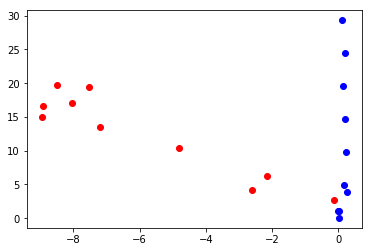

Count:51
()
()
Relative Depth: -16.607450369867095
Relative x: -8.316375644369659
Relative Original Depth: -30.303363804706986
Relative Original x: 0.1662874866090681
Count:52
()
()
Relative Depth: -16.890780055136073
Relative x: -7.910082615091218
Relative Original Depth: -31.280448841871106
Relative Original x: 0.1855543690342945
Count:53
()
()
Relative Depth: -17.089926530538353
Relative x: -7.797717373085812
Relative Original Depth: -32.25909932435057
Relative Original x: 0.1712723054814691
Count:54
()
()
Relative Depth: -17.284955740717354
Relative x: -7.481310577936105
Relative Original Depth: -33.24093006281222
Relative Original x: 0.21072212466007453
Count:55
()
()
Relative Depth: -17.691388313487725
Relative x: -7.2473773605129805
Relative Original Depth: -34.220392699904565
Relative Original x: 0.20535507315674428


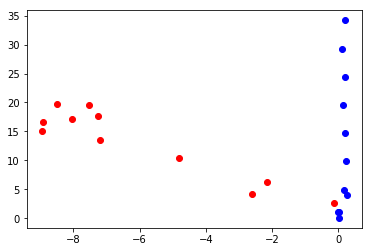

Count:56
()
()
Relative Depth: -18.02330306093737
Relative x: -6.65283414996107
Relative Original Depth: -35.20178641300584
Relative Original x: 0.1735140038412501
Count:57
()
()
Relative Depth: -18.05503814156987
Relative x: -5.86308774917284
Relative Original Depth: -36.180667512306
Relative Original x: 0.2987951099414099
Count:58
()
()
Relative Depth: -18.244195169916214
Relative x: -5.397108258015063
Relative Original Depth: -37.16712187369886
Relative Original x: 0.3609491771162368
Count:59
()
()
Relative Depth: -18.31469205469661
Relative x: -4.99480398835148
Relative Original Depth: -38.139744551620176
Relative Original x: 0.317815013132792
Count:60
()
()
Relative Depth: -18.152946572501094
Relative x: -4.505908630188893
Relative Original Depth: -39.11871649218448
Relative Original x: 0.3314036877560298


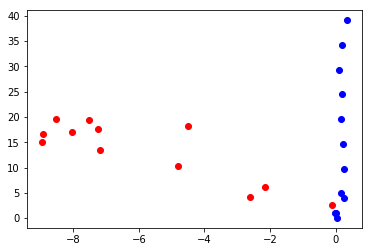

Count:61
()
()
Relative Depth: -17.95607446046124
Relative x: -3.9414742253483563
Relative Original Depth: -40.098698346132004
Relative Original x: 0.31905440186010925
Count:62
()
()
Relative Depth: -18.518973356120522
Relative x: -3.7418277139616802
Relative Original Depth: -41.068880796111735
Relative Original x: 0.29050613465310465
Count:63
()
()
Relative Depth: -18.655588985845732
Relative x: -4.677872482268372
Relative Original Depth: -42.04719486879208
Relative Original x: 0.2846672924627826
Count:64
()
()
Relative Depth: -18.66723733639291
Relative x: -4.0322661144203105
Relative Original Depth: -43.01897067027878
Relative Original x: 0.29656647262023383
Count:65
()
()
Relative Depth: -18.777103358058774
Relative x: -3.535540461190923
Relative Original Depth: -43.99424533067176
Relative Original x: 0.30392785250171594


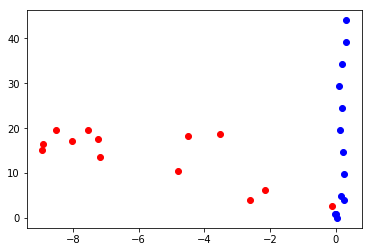

Count:66
()
()
Relative Depth: -18.9004544546149
Relative x: -2.892554650198996
Relative Original Depth: -44.977049963939315
Relative Original x: 0.2817302358840831
Count:67
()
()
Relative Depth: -19.08924128868889
Relative x: -1.939937124352456
Relative Original Depth: -45.95477218642698
Relative Original x: 0.2527810681614154
Count:68
()
()
Relative Depth: -19.42464192017481
Relative x: -0.9997309795586306
Relative Original Depth: -46.93448060040203
Relative Original x: 0.2620997371746004
Count:69
()
()
Relative Depth: -18.445866456997354
Relative x: -1.182573367784813
Relative Original Depth: -47.908649851039186
Relative Original x: 0.25070601681272386
Count:70
()
()
Relative Depth: -19.227284197651528
Relative x: -0.5608029487300361
Relative Original Depth: -48.886788016411046
Relative Original x: 0.24073647032871812


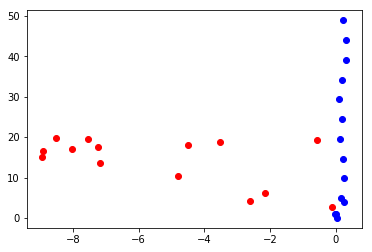

Count:71
()
()
Relative Depth: -20.15949715761108
Relative x: -0.26695604084886854
Relative Original Depth: -49.86624546210599
Relative Original x: 0.24598184159591627
Count:72
()
()
Relative Depth: -21.03300677692157
Relative x: -0.12364511602941247
Relative Original Depth: -50.837700967995765
Relative Original x: 0.2204962987378889
Count:73
()
()
Relative Depth: -21.840611251659027
Relative x: -0.2558437946675749
Relative Original Depth: -51.820763011799585
Relative Original x: 0.18409608343845674
Count:74
()
()
Relative Depth: -22.595733549235536
Relative x: -0.2051967408965862
Relative Original Depth: -52.799899877855395
Relative Original x: 0.1187687413969322
Count:75
()
()
Relative Depth: -23.252720786209636
Relative x: -0.015290996347032876
Relative Original Depth: -53.77786507199497
Relative Original x: 0.15171827830329143


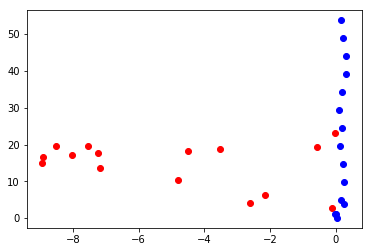

Count:76
()
()
Relative Depth: -23.93804577680657
Relative x: 0.09486792075845357
Relative Original Depth: -54.754749337997296
Relative Original x: 0.10355949300902359
Count:77
()
()
Relative Depth: -24.470549588386366
Relative x: 0.4493433730446838
Relative Original Depth: -55.734882154340454
Relative Original x: 0.07771973427970731
Count:78
()
()
Relative Depth: -23.790961423501425
Relative x: 0.6737705937404567
Relative Original Depth: -56.728037439552786
Relative Original x: 0.12657345880661264
Count:79
()
()
Relative Depth: -24.09021025472979
Relative x: 1.276782692201984
Relative Original Depth: -57.704096192964606
Relative Original x: 0.07793943715455517
Count:80
()
()
Relative Depth: -24.46696908451368
Relative x: 1.858105347792902
Relative Original Depth: -58.685079142746616
Relative Original x: 0.05274035451677569


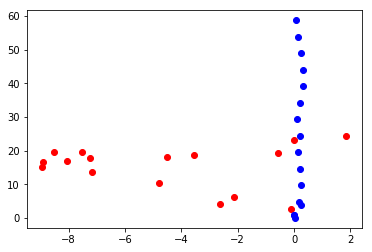

Count:81
()
()
Relative Depth: -24.908301948930887
Relative x: 2.4065958649767434
Relative Original Depth: -59.66722294692733
Relative Original x: 0.09746474971196042
Count:82
()
()
Relative Depth: -25.762780247384487
Relative x: 2.4035301935753033
Relative Original Depth: -60.64713819549071
Relative Original x: 0.11518666112893418
Count:83
()
()
Relative Depth: -26.695319270365346
Relative x: 2.0425528568243196
Relative Original Depth: -61.61646771339476
Relative Original x: 0.04171988178401177
Count:84
()
()
Relative Depth: -27.62141921796803
Relative x: 1.902136921122044
Relative Original Depth: -62.594026397592074
Relative Original x: 0.04613484033313489
Count:85
()
()
Relative Depth: -28.39288652309671
Relative x: 1.7343142453216558
Relative Original Depth: -63.5698338714753
Relative Original x: -0.0019278136758209968


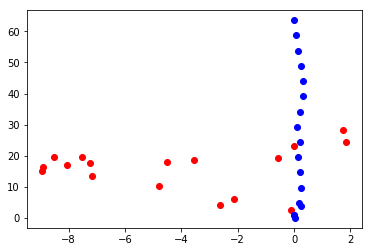

Count:86
()
()
Relative Depth: -29.087444223501333
Relative x: 1.433623424741128
Relative Original Depth: -64.5511687281702
Relative Original x: 0.01165573751090855
Count:87
()
()
Relative Depth: -29.763350872767415
Relative x: 1.0596780314036724
Relative Original Depth: -65.5127486572728
Relative Original x: -0.09056907403657034
Count:88
()
()
Relative Depth: -30.476503086427662
Relative x: 1.22853160003529
Relative Original Depth: -66.4886146369619
Relative Original x: -0.1254414827517712
Count:89
()
()
Relative Depth: -30.426515406820798
Relative x: 1.6417652207750155
Relative Original Depth: -67.47004276883524
Relative Original x: -0.15402374803328084
Count:90
()
()
Relative Depth: -31.045113515114767
Relative x: 2.389049245476733
Relative Original Depth: -68.44549339228165
Relative Original x: -0.19444331236255571


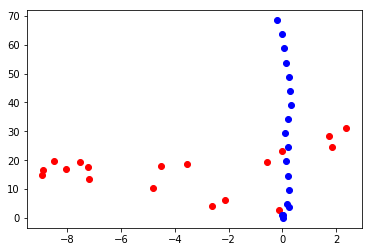

Count:91
()
()
Relative Depth: -31.879525723820358
Relative x: 2.8100315623617513
Relative Original Depth: -69.41685432505727
Relative Original x: -0.28833292794553106
Count:92
()
()
Relative Depth: -32.27466396173791
Relative x: 2.7612690885658813
Relative Original Depth: -70.38708819554815
Relative Original x: -0.3786465737373756
Count:93
()
()
Relative Depth: -32.1598089704297
Relative x: 2.6926230608252375
Relative Original Depth: -71.35944308334655
Relative Original x: -0.43949591703318797
Count:94
()
()
Relative Depth: -31.86400682816243
Relative x: 2.6233605619398817
Relative Original Depth: -72.32510504537588
Relative Original x: -0.5599916068128983
Count:95
()
()
Relative Depth: -31.601621852506213
Relative x: 2.5446284819033846
Relative Original Depth: -73.30386608974278
Relative Original x: -0.5682423772791514


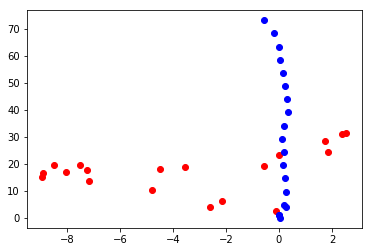

Count:96
()
()
Relative Depth: -31.50005081574296
Relative x: 2.4752379384530765
Relative Original Depth: -74.28480389249754
Relative Original x: -0.47779708861817355
Count:97
()
()
Relative Depth: -31.55156287274165
Relative x: 2.4381455594125763
Relative Original Depth: -75.26103289917553
Relative Original x: -0.46743249340950715
Count:98
()
()
Relative Depth: -31.77944757751345
Relative x: 2.598397259421368
Relative Original Depth: -76.22480938277863
Relative Original x: -0.5417130508985778
Count:99
()
()
Relative Depth: -31.840568917431607
Relative x: 2.8844594138484005
Relative Original Depth: -77.18955149704585
Relative Original x: -0.6177051400674667
Count:100
()
()
Relative Depth: -32.71354705055177
Relative x: 3.1750586815265835
Relative Original Depth: -78.15990037110097
Relative Original x: -0.6866785363247769


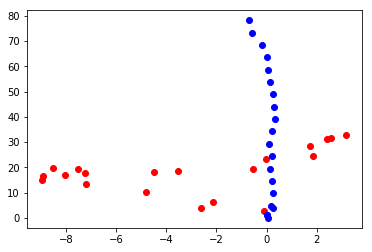

Count:101
()
()
Relative Depth: -32.50483482617495
Relative x: 3.3777919942251917
Relative Original Depth: -79.12244774149882
Relative Original x: -0.7837303049630706
Count:102
()
()
Relative Depth: -32.31077702683939
Relative x: 3.534217570530493
Relative Original Depth: -80.09785503690263
Relative Original x: -0.803305391814326
Count:103
()
()
Relative Depth: -32.34400771343681
Relative x: 3.74123926664563
Relative Original Depth: -81.0769064909654
Relative Original x: -0.8499600133603469
Count:104
()
()
Relative Depth: -32.33478915188966
Relative x: 3.8713605534151347
Relative Original Depth: -82.04340069134193
Relative Original x: -0.9294353415621914
Count:105
()
()
Relative Depth: -32.204626572088955
Relative x: 3.936320416809529
Relative Original Depth: -83.01193400782986
Relative Original x: -1.0181637507497212


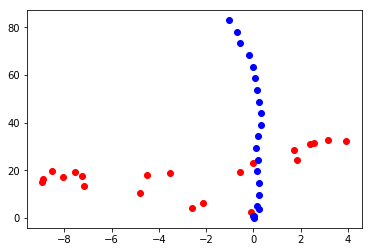

Count:106
()
()
Relative Depth: -32.31754522185469
Relative x: 4.175141492799706
Relative Original Depth: -83.98972529718452
Relative Original x: -1.0477139298709117
Count:107
()
()
Relative Depth: -32.78597472034405
Relative x: 3.328762459199547
Relative Original Depth: -84.94813316073386
Relative Original x: -1.1663863100422975
Count:108
()
()
Relative Depth: -33.18831771529999
Relative x: 3.689557381733972
Relative Original Depth: -85.92262252628178
Relative Original x: -1.2092016115708968
Count:109
()
()
Relative Depth: -33.984830872311555
Relative x: 4.054304308291306
Relative Original Depth: -86.88080404235221
Relative Original x: -1.3296146161026914
Count:110
()
()
Relative Depth: -34.982972650293654
Relative x: 4.1003754472850655
Relative Original Depth: -87.85756099297807
Relative Original x: -1.3697900778125227


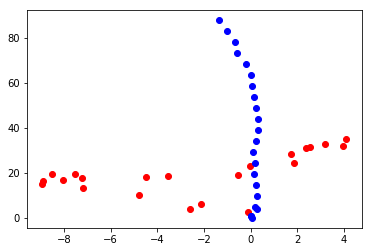

Count:111
()
()
Relative Depth: -35.95061610442162
Relative x: 3.872294334290649
Relative Original Depth: -88.83567471432227
Relative Original x: -1.4822784669960654
Count:112
()
()
Relative Depth: -36.90582581689065
Relative x: 3.629345271595089
Relative Original Depth: -89.80867222962381
Relative Original x: -1.502987937788899
Count:113
()
()
Relative Depth: -37.835665659724036
Relative x: 3.9303022849218574
Relative Original Depth: -90.79393366570812
Relative Original x: -1.4957585494432433
Count:114
()
()
Relative Depth: -38.428161614839695
Relative x: 4.622214573360688
Relative Original Depth: -91.77496041678634
Relative Original x: -1.462533436513406
Count:115
()
()
Relative Depth: -38.39684787968936
Relative x: 5.558268161728898
Relative Original Depth: -92.7486459776398
Relative Original x: -1.387732268456172


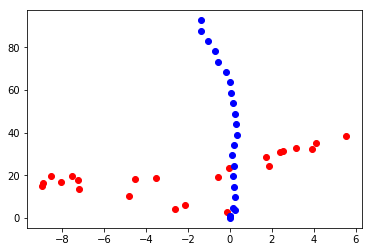

Count:116
()
()
Relative Depth: -38.857245687420665
Relative x: 6.20219740189084
Relative Original Depth: -93.72919245214256
Relative Original x: -1.3968832428889886
Count:117
()
()
Relative Depth: -39.151743103355315
Relative x: 6.688294662211812
Relative Original Depth: -94.71562031702167
Relative Original x: -1.4229301037173316
Count:118
()
()
Relative Depth: -39.358218014738334
Relative x: 7.022362144622714
Relative Original Depth: -95.68465051525996
Relative Original x: -1.509060861593666
Count:119
()
()
Relative Depth: -39.6186646480749
Relative x: 7.384585514701261
Relative Original Depth: -96.66297125926634
Relative Original x: -1.5777868271867341
Count:120
()
()
Relative Depth: -40.08624140800281
Relative x: 7.59358126484945
Relative Original Depth: -97.6432113732495
Relative Original x: -1.6190068375744906


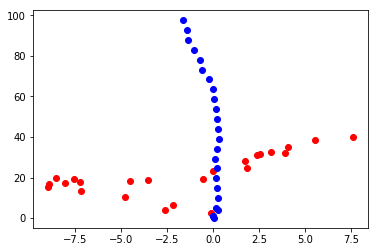

Count:121
()
()
Relative Depth: -40.68622684866837
Relative x: 7.628831135432083
Relative Original Depth: -98.62129968508695
Relative Original x: -1.6810033861463194
Count:122
()
()
Relative Depth: -41.266555861561706
Relative x: 7.6269075649739895
Relative Original Depth: -99.59701929508532
Relative Original x: -1.707002814892472
Count:123
()
()
Relative Depth: -41.90891091507482
Relative x: 7.5395408002044775
Relative Original Depth: -100.56961761071666
Relative Original x: -1.7655254419324007
Count:124
()
()
Relative Depth: -42.573180936430255
Relative x: 7.265042235359356
Relative Original Depth: -101.54937623034041
Relative Original x: -1.7940532526255435
Count:125
()
()
Relative Depth: -43.09534314936437
Relative x: 6.765725217104181
Relative Original Depth: -102.5176392263464
Relative Original x: -1.8902655458604922


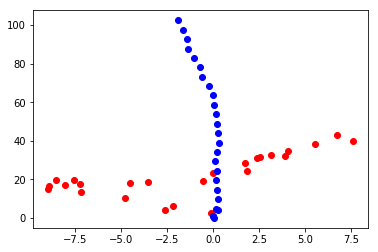

Count:126
()
()
Relative Depth: -43.08907283790571
Relative x: 5.952687391597596
Relative Original Depth: -103.4980531582151
Relative Original x: -1.912428095829682
Count:127
()
()
Relative Depth: -42.512901744248346
Relative x: 5.139740478358833
Relative Original Depth: -104.48025863087132
Relative Original x: -1.9337757071874195
Count:128
()
()
Relative Depth: -41.891984503556415
Relative x: 4.498984267711636
Relative Original Depth: -105.46018772884776
Relative Original x: -1.9949425940919185
Count:129
()
()
Relative Depth: -41.62108153211092
Relative x: 4.000365922330207
Relative Original Depth: -106.44370599965876
Relative Original x: -2.0290306443408634
Count:130
()
()
Relative Depth: -41.82115786071373
Relative x: 3.939743931193934
Relative Original Depth: -107.42678639352127
Relative Original x: -2.0568089646014833


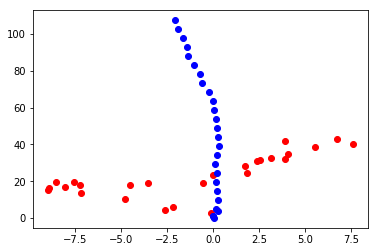

Count:131
()
()
Relative Depth: -41.78217207743313
Relative x: 4.196295560689867
Relative Original Depth: -108.40621112111893
Relative Original x: -2.0697539093348003
Count:132
()
()
Relative Depth: -41.447042175658446
Relative x: 4.672564791085069
Relative Original Depth: -109.37743990717574
Relative Original x: -2.124420153445623
Count:133
()
()
Relative Depth: -41.07480496226436
Relative x: 5.150676183821738
Relative Original Depth: -110.34762194940528
Relative Original x: -2.186806437710018
Count:134
()
()
Relative Depth: -40.730660055369796
Relative x: 5.596076126354896
Relative Original Depth: -111.32246313364692
Relative Original x: -2.250069210933572
Count:135
()
()
Relative Depth: -40.406981517969534
Relative x: 6.5178626668264625
Relative Original Depth: -112.29738565908383
Relative Original x: -2.308033780120798


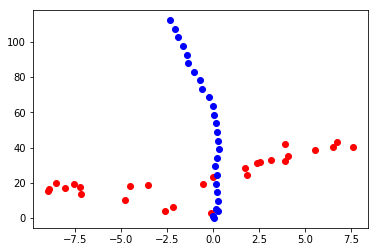

Count:136
()
()
Relative Depth: -41.16033589120451
Relative x: 6.333901595021403
Relative Original Depth: -113.26942081804103
Relative Original x: -2.3689842326896153
Count:137
()
()
Relative Depth: -41.10798430626123
Relative x: 6.944570067230007
Relative Original Depth: -114.24787571242575
Relative Original x: -2.3913930135251302
Count:138
()
()
Relative Depth: -41.326002346371084
Relative x: 6.018775564571142
Relative Original Depth: -115.22254567263712
Relative Original x: -2.4585602583826143
Count:139
()
()
Relative Depth: -41.66866581013613
Relative x: 6.720812954922826
Relative Original Depth: -116.20217246290426
Relative Original x: -2.4189038119214503
Count:140
()
()
Relative Depth: -41.97444561332598
Relative x: 7.500096468492202
Relative Original Depth: -117.17811435783226
Relative Original x: -2.4335725486805053


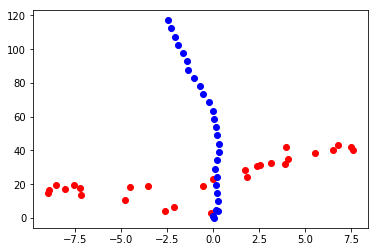

Count:141
()
()
Relative Depth: -42.059591881701444
Relative x: 8.426223157833082
Relative Original Depth: -118.15374218807759
Relative Original x: -2.477592214416078
Count:142
()
()
Relative Depth: -41.61210028259069
Relative x: 9.279552464403974
Relative Original Depth: -119.13439351317379
Relative Original x: -2.5089083866716
Count:143
()
()
Relative Depth: -40.861087648875774
Relative x: 9.85683459404421
Relative Original Depth: -120.10312127354858
Relative Original x: -2.575664656840566
Count:144
()
()
Relative Depth: -40.20262741258859
Relative x: 10.541965425122152
Relative Original Depth: -121.07596881102126
Relative Original x: -2.6036917878649994
Count:145
()
()
Relative Depth: -39.58881071271932
Relative x: 11.301918234007726
Relative Original Depth: -122.0547803940304
Relative Original x: -2.6228068740969017


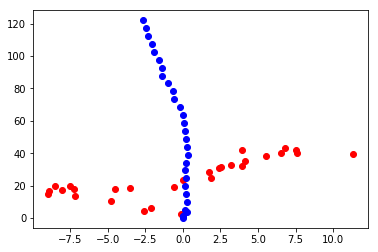

Count:146
()
()
Relative Depth: -38.91345666402622
Relative x: 12.016234473524355
Relative Original Depth: -123.03060437833524
Relative Original x: -2.6067055588698707
Count:147
()
()
Relative Depth: -38.22289523514705
Relative x: 12.712607719501483
Relative Original Depth: -124.00679267416912
Relative Original x: -2.643429059630008
Count:148
()
()
Relative Depth: -37.591571484452245
Relative x: 13.445591934468125
Relative Original Depth: -124.9750720845059
Relative Original x: -2.6432835982778577
Count:149
()
()
Relative Depth: -37.07926157504036
Relative x: 14.063849625207336
Relative Original Depth: -125.95125397791952
Relative Original x: -2.721381265397288
Count:150
()
()
Relative Depth: -36.755113442628684
Relative x: 13.928777180767726
Relative Original Depth: -126.92930661705923
Relative Original x: -2.7436153738482894


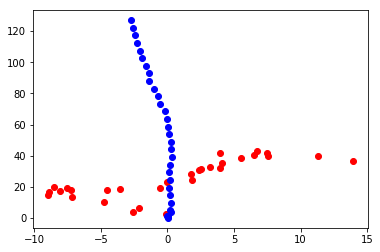

Count:151
()
()
Relative Depth: -36.349991645179216
Relative x: 14.668090099690142
Relative Original Depth: -127.91029516095017
Relative Original x: -2.7517442679164397
Count:152
()
()
Relative Depth: -36.259509865764045
Relative x: 14.67261370207004
Relative Original Depth: -128.88226345396822
Relative Original x: -2.8161526653977913
Count:153
()
()
Relative Depth: -36.923163634620764
Relative x: 14.155919788641693
Relative Original Depth: -129.86040320226138
Relative Original x: -2.835714881224172
Count:154
()
()
Relative Depth: -37.9229045458481
Relative x: 14.135258019966155
Relative Original Depth: -130.83930785006206
Relative Original x: -2.861253015326196
Count:155
()
()
Relative Depth: -38.12289102364552
Relative x: 14.946916199121228
Relative Original Depth: -131.81554148525484
Relative Original x: -2.8780033498188624


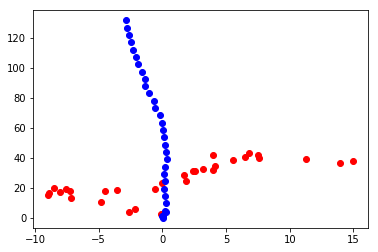

Count:156
()
()
Relative Depth: -38.8506845257007
Relative x: 15.346473632901937
Relative Original Depth: -132.79663501776812
Relative Original x: -2.8888596816346093
Count:157
()
()
Relative Depth: -39.428072622585354
Relative x: 15.246760200598722
Relative Original Depth: -133.76179685497604
Relative Original x: -2.936847807201025
Count:158
()
()
Relative Depth: -40.099433267133044
Relative x: 14.959366295099253
Relative Original Depth: -134.7437811660105
Relative Original x: -2.9183541743009322
Count:159
()
()
Relative Depth: -40.61323035490286
Relative x: 14.644793687745302
Relative Original Depth: -135.7162768358156
Relative Original x: -2.935098834803687
Count:160
()
()
Relative Depth: -40.71228709713549
Relative x: 14.359493668117986
Relative Original Depth: -136.69776561157707
Relative Original x: -2.9613947851082454


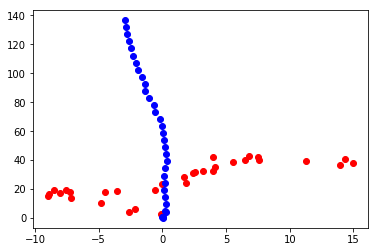

Count:161
()
()
Relative Depth: -40.24561902410471
Relative x: 14.265024619573309
Relative Original Depth: -137.68052346474659
Relative Original x: -3.0021495063763686
Count:162
()
()
Relative Depth: -39.43117234735056
Relative x: 14.118143037407501
Relative Original Depth: -138.6567105430852
Relative Original x: -3.0574084563948705
Count:163
()
()
Relative Depth: -38.572951820175206
Relative x: 13.864942572926749
Relative Original Depth: -139.64902645726926
Relative Original x: -3.040664805450828
Count:164
()
()
Relative Depth: -37.86181590757668
Relative x: 13.526134357954406
Relative Original Depth: -140.61847994068455
Relative Original x: -3.076256864726914
Count:165
()
()
Relative Depth: -37.044940578498036
Relative x: 13.353103891323947
Relative Original Depth: -141.60163786914163
Relative Original x: -3.118713948324811


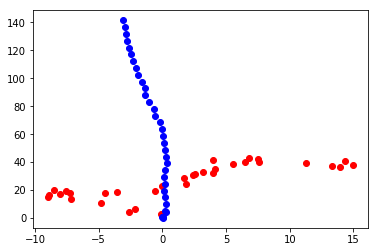

Count:166
()
()
Relative Depth: -36.110965060854674
Relative x: 13.422907112911119
Relative Original Depth: -142.57652398335992
Relative Original x: -3.119285956779937
Count:167
()
()
Relative Depth: -35.21531467194812
Relative x: 13.490438962481333
Relative Original Depth: -143.5566868252542
Relative Original x: -3.1540911773312823
Count:168
()
()
Relative Depth: -34.29955341505892
Relative x: 13.490501412441512
Relative Original Depth: -144.5324027947535
Relative Original x: -3.163713341422388
Count:169
()
()
Relative Depth: -33.344283023297855
Relative x: 13.402837798611808
Relative Original Depth: -145.51110542838143
Relative Original x: -3.15980314252324
Count:170
()
()
Relative Depth: -32.64963517621893
Relative x: 13.786681548361129
Relative Original Depth: -146.48587053853822
Relative Original x: -3.185489427629588


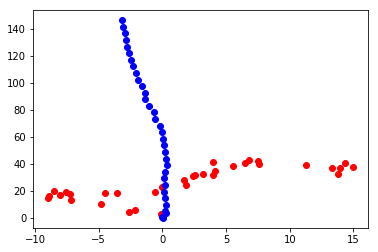

Count:171
()
()
Relative Depth: -32.49390527980479
Relative x: 14.45796090610237
Relative Original Depth: -147.47770904575805
Relative Original x: -3.13361894471209
Count:172
()
()
Relative Depth: -32.45052102640479
Relative x: 15.108422883606666
Relative Original Depth: -148.45652833615776
Relative Original x: -3.1566208722875237
Count:173
()
()
Relative Depth: -31.93356194942188
Relative x: 15.863494820899774
Relative Original Depth: -149.43348500613192
Relative Original x: -3.211514217437841
Count:174
()
()
Relative Depth: -31.066021874405628
Relative x: 16.347232497574915
Relative Original Depth: -150.4057591263702
Relative Original x: -3.2844306013888946
Count:175
()
()
Relative Depth: -30.21887106147342
Relative x: 16.81208208653935
Relative Original Depth: -151.3780649357232
Relative Original x: -3.3236458547551737


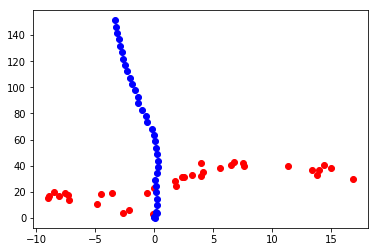

Count:176
()
()
Relative Depth: -29.413643624707447
Relative x: 17.14229394309439
Relative Original Depth: -152.34476382298135
Relative Original x: -3.3581196659957824
Count:177
()
()
Relative Depth: -28.602832699976616
Relative x: 17.015689077283703
Relative Original Depth: -153.33054366218678
Relative Original x: -3.304075951007737
Count:178
()
()
Relative Depth: -27.888738612449767
Relative x: 16.600257122003494
Relative Original Depth: -154.30833872708348
Relative Original x: -3.351003252128051
Count:179
()
()
Relative Depth: -28.240790828351184
Relative x: 15.873948474359231
Relative Original Depth: -155.29030369842533
Relative Original x: -3.3471905462364613
Count:180
()
()
Relative Depth: -27.40432443946493
Relative x: 15.614248811248162
Relative Original Depth: -156.2783014957018
Relative Original x: -3.365714847088997


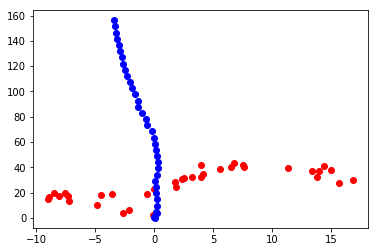

Count:181
()
()
Relative Depth: -26.52911931279892
Relative x: 16.056771347202766
Relative Original Depth: -157.25477289743074
Relative Original x: -3.431118127722284
Count:182
()
()
Relative Depth: -25.958290731138064
Relative x: 16.864277758261085
Relative Original Depth: -158.23689654665944
Relative Original x: -3.38917450380235
Count:183
()
()
Relative Depth: -25.44402449705222
Relative x: 17.72138321279407
Relative Original Depth: -159.21555980626542
Relative Original x: -3.413841226626805
Count:184
()
()
Relative Depth: -25.053709764080963
Relative x: 18.628439043038508
Relative Original Depth: -160.19285934204717
Relative Original x: -3.449049593243538
Count:185
()
()
Relative Depth: -24.366459264295813
Relative x: 18.646066011695503
Relative Original Depth: -161.16494609411455
Relative Original x: -3.340339800579422


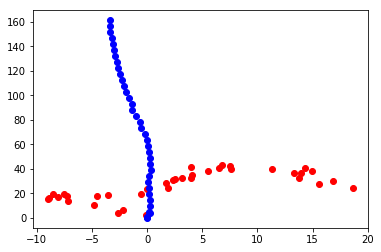

Count:186
()
()
Relative Depth: -24.003088861832897
Relative x: 19.576099147412524
Relative Original Depth: -162.12887676510485
Relative Original x: -3.3979328523585304
Count:187
()
()
Relative Depth: -23.008925634952117
Relative x: 19.47533134022811
Relative Original Depth: -163.0923379991802
Relative Original x: -3.4860750003415144
Count:188
()
()
Relative Depth: -23.10037097106936
Relative x: 20.45172949149772
Relative Original Depth: -164.07838971138713
Relative Original x: -3.512770974463126
Count:189
()
()
Relative Depth: -24.00459973220493
Relative x: 20.853375008253106
Relative Original Depth: -165.05098612610115
Relative Original x: -3.425959989640362
Count:190
()
()
Relative Depth: -24.99363739273175
Relative x: 20.823767769142144
Relative Original Depth: -166.02826006462072
Relative Original x: -3.4019366725215336


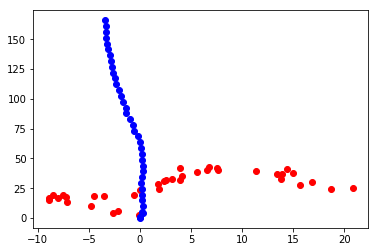

Count:191
()
()
Relative Depth: -25.991500298764777
Relative x: 20.84859927157512
Relative Original Depth: -167.0061888387561
Relative Original x: -3.3916735881960816
Count:192
()
()
Relative Depth: -26.804701115322704
Relative x: 20.59059948789755
Relative Original Depth: -167.98792656811318
Relative Original x: -3.381627153913681
Count:193
()
()
Relative Depth: -27.79265308194951
Relative x: 20.739746926044297
Relative Original Depth: -168.95462691850898
Relative Original x: -3.4294029319635526
Count:194
()
()
Relative Depth: -28.733627015675854
Relative x: 20.721335506854633
Relative Original Depth: -169.9370245720172
Relative Original x: -3.4654209825368736
Count:195
()
()
Relative Depth: -29.668132057285014
Relative x: 20.442178645541237
Relative Original Depth: -168.95188285095597
Relative Original x: -3.4504877324216188


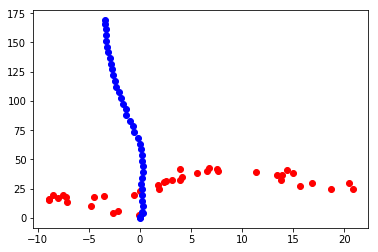

Count:196
()
()
Relative Depth: -30.65620275089954
Relative x: 20.310681008112702
Relative Original Depth: -169.94627438597163
Relative Original x: -3.4854277926599493
Count:197
()
()
Relative Depth: -31.65018324965729
Relative x: 20.347861604658945
Relative Original Depth: -170.93536503046855
Relative Original x: -3.41982087272345
Count:198
()
()
Relative Depth: -32.588549836739354
Relative x: 20.66566906062022
Relative Original Depth: -171.91844171507566
Relative Original x: -3.4847380636062533
Count:199
()
()
Relative Depth: -33.434524472683115
Relative x: 21.045387219239675
Relative Original Depth: -170.9278904747377
Relative Original x: -3.510064242443127
Count:200
()
()
Relative Depth: -34.28872973048545
Relative x: 21.36071295813879
Relative Original Depth: -169.9412174449946
Relative Original x: -3.4817984313671575


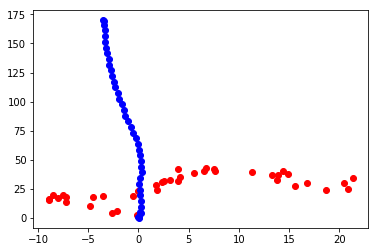

Count:201
()
()
Relative Depth: -35.002842447239715
Relative x: 21.95182251675658
Relative Original Depth: -170.93294047289194
Relative Original x: -3.6008165276111606
Count:202
()
()
Relative Depth: -35.571053578502564
Relative x: 22.752059988328394
Relative Original Depth: -171.92448605728697
Relative Original x: -3.618516851545301
Count:203
()
()
Relative Depth: -36.35780080143588
Relative x: 23.324835829373367
Relative Original Depth: -172.9155512740383
Relative Original x: -3.6903184895931593
Count:204
()
()
Relative Depth: -37.19817081336261
Relative x: 23.518188675561948
Relative Original Depth: -171.9337413927854
Relative Original x: -3.849184074618171
Count:205
()
()
Relative Depth: -36.23779755811854
Relative x: 23.239554204658404
Relative Original Depth: -170.94440697325493
Relative Original x: -3.922638105977601


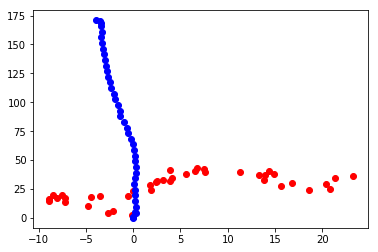

Count:206
()
()
Relative Depth: -36.98056030152807
Relative x: 23.63311703967408
Relative Original Depth: -171.92621217616625
Relative Original x: -3.786325466373844
Count:207
()
()
Relative Depth: -37.589155513247
Relative x: 24.17289573647403
Relative Original Depth: -172.90764265188366
Relative Original x: -3.6784782254319053
Count:208
()
()
Relative Depth: -38.46844255056471
Relative x: 24.212233893291522
Relative Original Depth: -173.89611878169717
Relative Original x: -3.563714718362342
Count:209
()
()
Relative Depth: -39.45824246568457
Relative x: 24.157853322390622
Relative Original Depth: -172.90447141250579
Relative Original x: -3.603975382127116
Count:210
()
()
Relative Depth: -40.37663232918272
Relative x: 24.548951293593365
Relative Original Depth: -173.89086760754157
Relative Original x: -3.6467154709381617


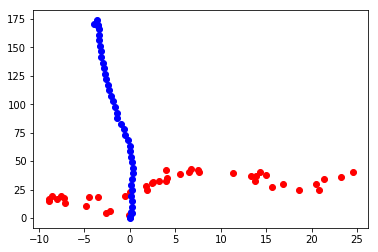

Count:211
()
()
Relative Depth: -41.35650912140723
Relative x: 24.44385958754479
Relative Original Depth: -174.89047623585628
Relative Original x: -3.6426497575694583
Count:212
()
()
Relative Depth: -41.97580675440837
Relative x: 23.78851117598864
Relative Original Depth: -175.88439098817676
Relative Original x: -3.6347891202379126
Count:213
()
()
Relative Depth: -42.29902893635343
Relative x: 23.216884376742616
Relative Original Depth: -176.87862444251343
Relative Original x: -3.650181675855105
Count:214
()
()
Relative Depth: -42.692485180175964
Relative x: 22.745860985517336
Relative Original Depth: -175.88522944162813
Relative Original x: -3.670569423562877
Count:215
()
()
Relative Depth: -41.86633767475232
Relative x: 22.438695678825546
Relative Original Depth: -176.87657179042964
Relative Original x: -3.640975348706438


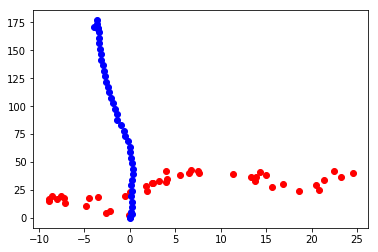

Count:216
()
()
Relative Depth: -41.702522750307395
Relative x: 22.29531983956661
Relative Original Depth: -177.87326774840108
Relative Original x: -3.658795491578889
Count:217
()
()
Relative Depth: -41.33387383570221
Relative x: 22.559156301947613
Relative Original Depth: -178.85763296621215
Relative Original x: -3.689577051884762
Count:218
()
()
Relative Depth: -41.4493598957428
Relative x: 22.86408586756433
Relative Original Depth: -179.8362725243113
Relative Original x: -3.8305936966486738
Count:219
()
()
Relative Depth: -41.502214678138
Relative x: 23.00207385788361
Relative Original Depth: -180.83260542606428
Relative Original x: -3.8319097571482317
Count:220
()
()
Relative Depth: -40.89177270383891
Relative x: 23.301213555353204
Relative Original Depth: -181.8252547019138
Relative Original x: -3.824611776442927


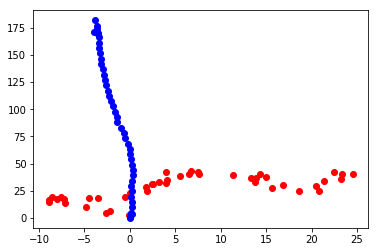

Count:221
()
()
Relative Depth: -40.33428857199084
Relative x: 24.105198661725133
Relative Original Depth: -182.82163047130516
Relative Original x: -3.8698829213933714
Count:222
()
()
Relative Depth: -39.64386552186969
Relative x: 24.584123041853726
Relative Original Depth: -183.81801244531593
Relative Original x: -3.880945440740537
Count:223
()
()
Relative Depth: -39.322700047869304
Relative x: 24.889225111119778
Relative Original Depth: -184.81355371129334
Relative Original x: -3.8819200697612053
Count:224
()
()
Relative Depth: -39.393465116357305
Relative x: 25.080865960686506
Relative Original Depth: -185.80641712089
Relative Original x: -3.889964724276068
Count:225
()
()
Relative Depth: -39.790808593322254
Relative x: 25.24039131315097
Relative Original Depth: -186.8010344368761
Relative Original x: -3.8348663702622843


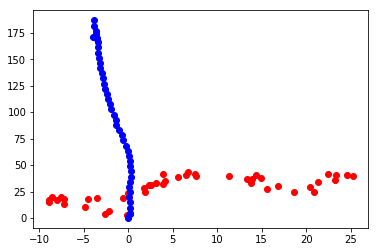

Count:226
()
()
Relative Depth: -40.21023479895846
Relative x: 25.38468274279042
Relative Original Depth: -187.788078972927
Relative Original x: -3.9065484189140363
Count:227
()
()
Relative Depth: -39.66516411613585
Relative x: 25.665108920059975
Relative Original Depth: -188.78403325225554
Relative Original x: -3.9208728510826285
Count:228
()
()
Relative Depth: -40.18395358879393
Relative x: 25.851243836060412
Relative Original Depth: -189.77639144629978
Relative Original x: -3.9523417456055623
Count:229
()
()
Relative Depth: -40.866548019704574
Relative x: 26.03797429375798
Relative Original Depth: -190.76688667284566
Relative Original x: -3.829725067088489
Count:230
()
()
Relative Depth: -41.6892197416591
Relative x: 26.261389279868762
Relative Original Depth: -191.7605930149206
Relative Original x: -3.861173257374048


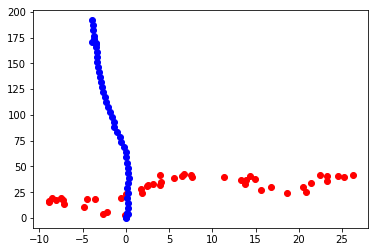

Count:231
()
()
Relative Depth: -42.252004599517186
Relative x: 27.059407651867804
Relative Original Depth: -192.7575336892655
Relative Original x: -3.820507810958322
Count:232
()
()
Relative Depth: -42.25002606251995
Relative x: 28.05937608108572
Relative Original Depth: -193.7489625042776
Relative Original x: -3.7983243401643296
Count:233
()
()
Relative Depth: -42.37631554060824
Relative x: 29.040593744403598
Relative Original Depth: -194.74033660222014
Relative Original x: -3.831560167755408
Count:234
()
()
Relative Depth: -43.25959266285977
Relative x: 29.28217664101383
Relative Original Depth: -195.72494897369364
Relative Original x: -3.726670055342784
Count:235
()
()
Relative Depth: -43.26753978440487
Relative x: 28.799515665147148
Relative Original Depth: -196.71669116017952
Relative Original x: -3.668838541376928


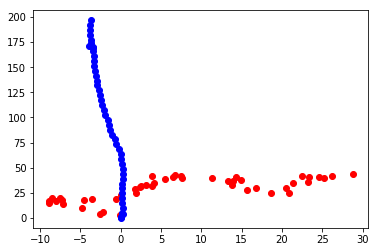

Count:236
()
()
Relative Depth: -42.61102728968538
Relative x: 28.960512586290687
Relative Original Depth: -197.70990846074764
Relative Original x: -3.608100510937063
Count:237
()
()
Relative Depth: -43.5495176792426
Relative x: 29.102375856502192
Relative Original Depth: -198.7082362145845
Relative Original x: -3.5591283550930277
Count:238
()
()
Relative Depth: -44.26133511156039
Relative x: 29.220494719230217
Relative Original Depth: -199.70112697752904
Relative Original x: -3.5996906283115675
Count:239
()
()
Relative Depth: -44.42342686615288
Relative x: 28.884879489333695
Relative Original Depth: -200.69969283440585
Relative Original x: -3.5668286445666886
Count:240
()
()
Relative Depth: -44.258073620427226
Relative x: 28.195502122733597
Relative Original Depth: -201.69476290919368
Relative Original x: -3.554466746692071


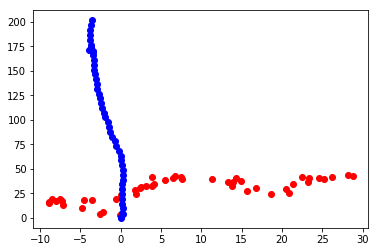

Count:241
()
()
Relative Depth: -44.00372261911794
Relative x: 27.432911566557493
Relative Original Depth: -202.688531681608
Relative Original x: -3.509393562667715
Count:242
()
()
Relative Depth: -43.671435852343116
Relative x: 26.637453548634124
Relative Original Depth: -203.6667921640543
Relative Original x: -3.325892536350371
Count:243
()
()
Relative Depth: -43.44589715418591
Relative x: 25.89799712330008
Relative Original Depth: -204.66017876313012
Relative Original x: -3.330000605696176
Count:244
()
()
Relative Depth: -42.64672396402554
Relative x: 25.337144145272088
Relative Original Depth: -205.6571090176742
Relative Original x: -3.334116141834117
Count:245
()
()
Relative Depth: -41.91959699810632
Relative x: 24.859322065415967
Relative Original Depth: -206.65222623075744
Relative Original x: -3.331049432665717


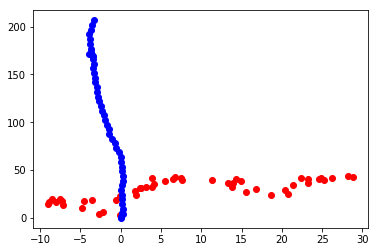

Count:246
()
()
Relative Depth: -42.003951113750766
Relative x: 24.332190296414208
Relative Original Depth: -207.64684483415968
Relative Original x: -3.337376535171269
Count:247
()
()
Relative Depth: -42.420385775179774
Relative x: 24.582899486665195
Relative Original Depth: -208.64473698931948
Relative Original x: -3.327936764442267
Count:248
()
()
Relative Depth: -42.90655662233826
Relative x: 25.413158860550666
Relative Original Depth: -209.64153145171156
Relative Original x: -3.31653822920117
Count:249
()
()
Relative Depth: -43.639957500011064
Relative x: 26.08452190833448
Relative Original Depth: -210.6358874496489
Relative Original x: -3.3094522483690056
Count:250
()
()
Relative Depth: -44.459455102093855
Relative x: 26.517086544406705
Relative Original Depth: -211.6332507923773
Relative Original x: -3.3004310392036023


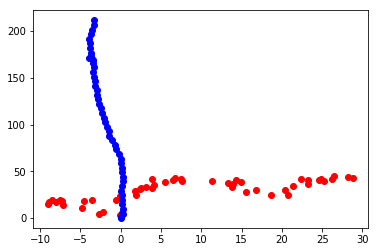

Count:251
()
()
Relative Depth: -45.243158975047876
Relative x: 27.00348838270413
Relative Original Depth: -212.62287927827467
Relative Original x: -3.2028406467569144
Count:252
()
()
Relative Depth: -45.26270809139413
Relative x: 26.19950849171805
Relative Original Depth: -213.61870162117455
Relative Original x: -3.2015785653015763
Count:253
()
()
Relative Depth: -45.994479741510844
Relative x: 26.85332755939166
Relative Original Depth: -214.6153689015604
Relative Original x: -3.267109842606813
Count:254
()
()
Relative Depth: -46.62286344358358
Relative x: 27.63031758154693
Relative Original Depth: -215.6142480072204
Relative Original x: -3.261001656086705
Count:255
()
()
Relative Depth: -46.28464550347288
Relative x: 27.1182962948831
Relative Original Depth: -216.6075282419091
Relative Original x: -3.2182976995575276


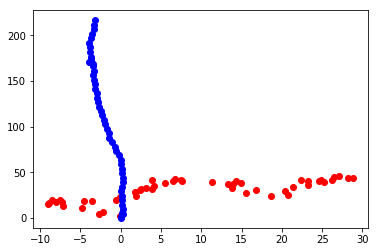

Count:256
()
()
Relative Depth: -46.85245496319727
Relative x: 27.938276374620155
Relative Original Depth: -217.6045452328173
Relative Original x: -3.157234817263348
Count:257
()
()
Relative Depth: -47.35712482292284
Relative x: 28.775754232946255
Relative Original Depth: -218.6020461979037
Relative Original x: -3.153647095278955
Count:258
()
()
Relative Depth: -47.87312266888875
Relative x: 29.606102462044802
Relative Original Depth: -219.5964371138947
Relative Original x: -3.1851429549695656
Count:259
()
()
Relative Depth: -48.29323848504686
Relative x: 30.19827808756299
Relative Original Depth: -220.59329544207677
Relative Original x: -3.1880331435430227
Count:260
()
()
Relative Depth: -48.730741682467645
Relative x: 30.801902166968787
Relative Original Depth: -221.5893770613788
Relative Original x: -3.134218934579101


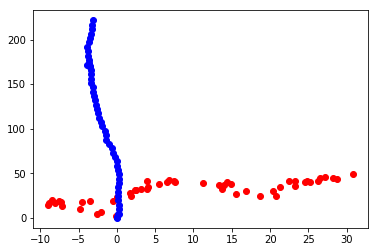

Count:261
()
()
Relative Depth: -49.21966662111375
Relative x: 31.445456316908906
Relative Original Depth: -222.5831372085718
Relative Original x: -3.1410176702897976
Count:262
()
()
Relative Depth: -49.71081683565492
Relative x: 32.08527573220319
Relative Original Depth: -223.57829527740927
Relative Original x: -3.071384059588214
Count:263
()
()
Relative Depth: -50.21473259823173
Relative x: 32.75988981356819
Relative Original Depth: -224.57276528393336
Relative Original x: -3.004857887048901
Count:264
()
()
Relative Depth: -50.687158701138664
Relative x: 33.27978479720212
Relative Original Depth: -225.57020901011882
Relative Original x: -3.0037259964641065
Count:265
()
()
Relative Depth: -50.6930862415258
Relative x: 33.364714388102705
Relative Original Depth: -226.56391511171464
Relative Original x: -2.9753441421385225


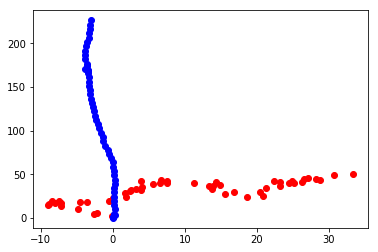

Count:266
()
()
Relative Depth: -50.36989724967964
Relative x: 33.09773251550131
Relative Original Depth: -227.5582305570269
Relative Original x: -2.9817722812867413
Count:267
()
()
Relative Depth: -50.28060898280588
Relative x: 33.22581327383088
Relative Original Depth: -228.55034010247576
Relative Original x: -2.888161305394404
Count:268
()
()
Relative Depth: -49.9989256210543
Relative x: 33.16202508570104
Relative Original Depth: -229.54286607657036
Relative Original x: -2.8496043705645717
Count:269
()
()
Relative Depth: -49.58099958133117
Relative x: 32.43671170990251
Relative Original Depth: -230.5375020479085
Relative Original x: -2.8042720353371444
Count:270
()
()
Relative Depth: -49.85168705121662
Relative x: 32.69943089385145
Relative Original Depth: -231.51840798070398
Relative Original x: -2.642686354487898


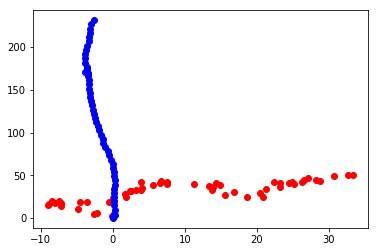

Count:271
()
()
Relative Depth: -49.58241224198252
Relative x: 31.8276951723649
Relative Original Depth: -232.50189367511382
Relative Original x: -2.5052136423474725
Count:272
()
()
Relative Depth: -49.32088980573527
Relative x: 30.869234777516738
Relative Original Depth: -233.48584957603052
Relative Original x: -2.3509370924246005
Count:273
()
()
Relative Depth: -49.110946906068214
Relative x: 30.02999455605105
Relative Original Depth: -234.47232259259133
Relative Original x: -2.2155963335553577
Count:274
()
()
Relative Depth: -49.2910497716394
Relative x: 29.204545209803353
Relative Original Depth: -235.4489001311183
Relative Original x: -2.0095744961754254
Count:275
()
()
Relative Depth: -49.9111529032418
Relative x: 28.677607998411197
Relative Original Depth: -236.43871550140318
Relative Original x: -1.8903380190465977


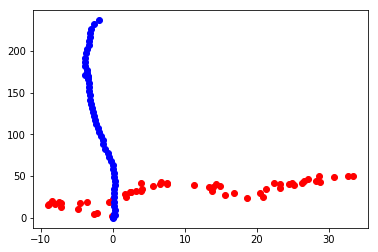

Count:276
()
()
Relative Depth: -50.584486777316705
Relative x: 28.14225310458957
Relative Original Depth: -237.41842793225663
Relative Original x: -1.7071635355902266
Count:277
()
()
Relative Depth: -51.26202274508882
Relative x: 27.54487058789571
Relative Original Depth: -238.3869301559957
Relative Original x: -1.4699520152113017
Count:278
()
()
Relative Depth: -51.93534564457513
Relative x: 27.057873904075983
Relative Original Depth: -239.35760715381056
Relative Original x: -1.2396319774542746
Count:279
()
()
Relative Depth: -52.569630007388
Relative x: 27.11842175436579
Relative Original Depth: -240.3334714590408
Relative Original x: -1.04198705375908
Count:280
()
()
Relative Depth: -53.05724907601693
Relative x: 27.613955420866603
Relative Original Depth: -241.29169706886472
Relative Original x: -0.764873373371288


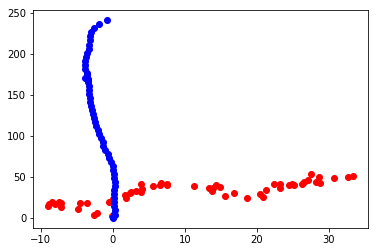

Count:281
()
()
Relative Depth: -53.52283909681627
Relative x: 28.123678280299778
Relative Original Depth: -242.2605923811112
Relative Original x: -0.5296573887703249
Count:282
()
()
Relative Depth: -53.947765900866294
Relative x: 28.780060686202763
Relative Original Depth: -243.23091780526323
Relative Original x: -0.31244386863437046
Count:283
()
()
Relative Depth: -54.2684257433991
Relative x: 29.572578229189805
Relative Original Depth: -244.1960009242973
Relative Original x: -0.06502378664509337
Count:284
()
()
Relative Depth: -53.69830597068534
Relative x: 29.54197878009741
Relative Original Depth: -245.16118120248376
Relative Original x: 0.1703472848237459
Count:285
()
()
Relative Depth: -53.85430994128683
Relative x: 30.480200648437695
Relative Original Depth: -246.11696890040022
Relative Original x: 0.4352992954265445


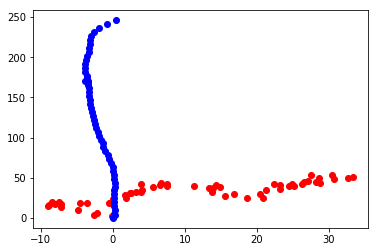

Count:286
()
()
Relative Depth: -53.96228432626644
Relative x: 31.465765361483808
Relative Original Depth: -247.08448598219118
Relative Original x: 0.671462800902323
Count:287
()
()
Relative Depth: -54.22572329888884
Relative x: 32.41632748241596
Relative Original Depth: -248.0587411442075
Relative Original x: 0.8847033408934196
Count:288
()
()
Relative Depth: -54.632651634476346
Relative x: 33.31096914936603
Relative Original Depth: -249.0251637050881
Relative Original x: 1.1294137640584176
Count:289
()
()
Relative Depth: -55.29771393437715
Relative x: 34.0045587456895
Relative Original Depth: -249.99421097187854
Relative Original x: 1.3585475000271128
Count:290
()
()
Relative Depth: -55.77060421647522
Relative x: 34.73726133357316
Relative Original Depth: -250.96848106041858
Relative Original x: 1.562765681701259


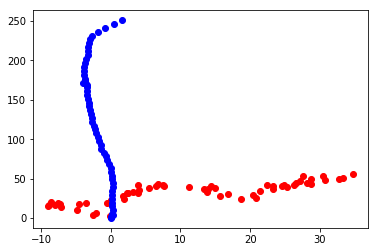

Count:291
()
()
Relative Depth: -55.75903490429171
Relative x: 35.57458928267982
Relative Original Depth: -251.94510205500572
Relative Original x: 1.7580309876117202
Count:292
()
()
Relative Depth: -55.71145231891144
Relative x: 36.43665934893041
Relative Original Depth: -252.92707186089794
Relative Original x: 1.9259746630396604
Count:293
()
()
Relative Depth: -55.41859688805157
Relative x: 37.363525783824656
Relative Original Depth: -253.91201064248833
Relative Original x: 2.0777841628841327
Count:294
()
()
Relative Depth: -54.93851708966308
Relative x: 38.24067602973218
Relative Original Depth: -254.88895679946526
Relative Original x: 2.271340452756032
Count:295
()
()
Relative Depth: -54.47238433974995
Relative x: 39.12132567736087
Relative Original Depth: -255.87034483573652
Relative Original x: 2.4413619966598548


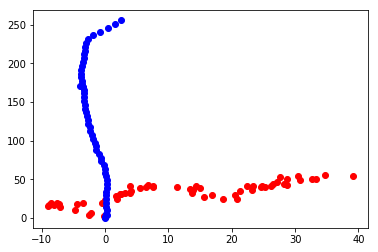

Count:296
()
()
Relative Depth: -53.94594528193045
Relative x: 39.96408114736615
Relative Original Depth: -256.8415336678268
Relative Original x: 2.6401537171693237
Count:297
()
()
Relative Depth: -53.17846758762683
Relative x: 40.49259302642813
Relative Original Depth: -257.8269750865571
Relative Original x: 2.762111997609772
Count:298
()
()
Relative Depth: -52.43538708580088
Relative x: 41.021343838713335
Relative Original Depth: -258.80120095071766
Relative Original x: 2.9533767907943056
Count:299
()
()
Relative Depth: -51.775710190443405
Relative x: 41.757955505619144
Relative Original Depth: -259.7765312675445
Relative Original x: 3.1591845237771246
Count:300
()
()
Relative Depth: -51.168103347585884
Relative x: 42.53852878059341
Relative Original Depth: -260.7584555644667
Relative Original x: 3.3312553558994273


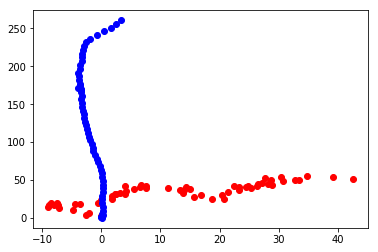

Count:301
()
()
Relative Depth: -50.62707490440984
Relative x: 43.37454689747915
Relative Original Depth: -261.7334999206523
Relative Original x: 3.533752964979682
Count:302
()
()
Relative Depth: -50.017740080335074
Relative x: 44.15498121339515
Relative Original Depth: -262.71503725836345
Relative Original x: 3.6864376062315682
Count:303
()
()
Relative Depth: -49.29885892278712
Relative x: 44.75893279573401
Relative Original Depth: -263.69299014834274
Relative Original x: 3.846210998734389
Count:304
()
()
Relative Depth: -48.599974612195105
Relative x: 45.196712631585896
Relative Original Depth: -264.6809024006541
Relative Original x: 3.9733358661244047
Count:305
()
()
Relative Depth: -47.90975941329452
Relative x: 45.84395298179132
Relative Original Depth: -265.66627256000373
Relative Original x: 4.112918803997381


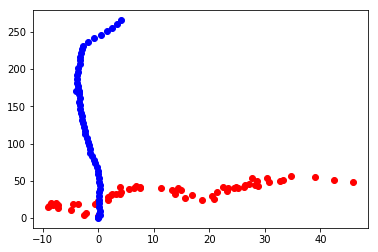

Count:306
()
()
Relative Depth: -47.340047002677416
Relative x: 46.650079995621645
Relative Original Depth: -266.6561622704389
Relative Original x: 4.221910406956788
Count:307
()
()
Relative Depth: -46.723259689384115
Relative x: 47.432819009455685
Relative Original Depth: -267.63945420124344
Relative Original x: 4.354428321301101
Count:308
()
()
Relative Depth: -46.10705508369267
Relative x: 48.21818701624931
Relative Original Depth: -268.6246187829816
Relative Original x: 4.489135137604799
Count:309
()
()
Relative Depth: -45.49681708767213
Relative x: 49.00821879587416
Relative Original Depth: -269.6117598367592
Relative Original x: 4.57068889051549
Count:310
()
()
Relative Depth: -45.01588358558586
Relative x: 49.8491565793683
Relative Original Depth: -270.60210412355787
Relative Original x: 4.668834776426018


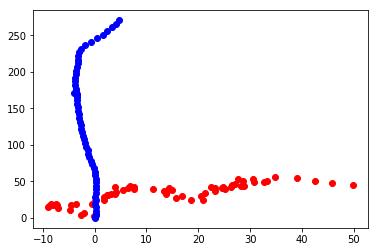

Count:311
()
()
Relative Depth: -44.34070815688451
Relative x: 49.698220822077886
Relative Original Depth: -271.5908504679704
Relative Original x: 4.781630953363957
Count:312
()
()
Relative Depth: -43.87413795027996
Relative x: 50.54915939642114
Relative Original Depth: -272.5807568895698
Relative Original x: 4.877550235404344
Count:313
()
()
Relative Depth: -43.21404040679694
Relative x: 51.13300032590924
Relative Original Depth: -273.57345690909915
Relative Original x: 4.9558746616655505
Count:314
()
()
Relative Depth: -42.43031485410908
Relative x: 51.302497851304196
Relative Original Depth: -274.5620351336559
Relative Original x: 5.070471096753238
Count:315
()
()
Relative Depth: -41.98237295729017
Relative x: 50.933476972165174
Relative Original Depth: -275.5523765139092
Relative Original x: 5.1669989579794215


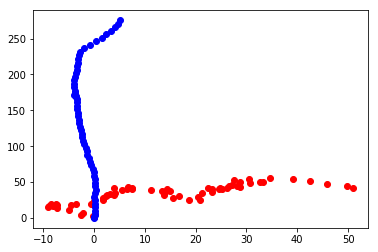

Count:316
()
()
Relative Depth: -41.68242574089691
Relative x: 50.56055155508091
Relative Original Depth: -276.5421148904053
Relative Original x: 5.248903095897853
Count:317
()
()
Relative Depth: -40.91434600220995
Relative x: 50.89456128965783
Relative Original Depth: -277.5288056378546
Relative Original x: 5.37014192936026
Count:318
()
()
Relative Depth: -40.34558844302429
Relative x: 51.14693083374916
Relative Original Depth: -278.5154426556156
Relative Original x: 5.499157560844533
Count:319
()
()
Relative Depth: -40.153165072915826
Relative x: 50.259814181774196
Relative Original Depth: -279.5027763898432
Relative Original x: 5.613711994464661
Count:320
()
()
Relative Depth: -39.462772399615424
Relative x: 50.92149073321923
Relative Original Depth: -280.4942794674939
Relative Original x: 5.658045646231921


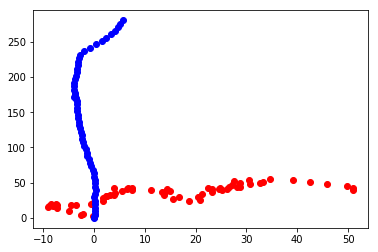

Count:321
()
()
Relative Depth: -38.78712627799276
Relative x: 51.60172468051716
Relative Original Depth: -281.4823612817625
Relative Original x: 5.726116510964342
Count:322
()
()
Relative Depth: -38.09506705579925
Relative x: 52.27810782009994
Relative Original Depth: -282.47329661900886
Relative Original x: 5.753730542064892
Count:323
()
()
Relative Depth: -37.379180830133144
Relative x: 52.937969156940326
Relative Original Depth: -283.46049270365177
Relative Original x: 5.856446873036992
Count:324
()
()
Relative Depth: -36.741374415080614
Relative x: 52.8367137728563
Relative Original Depth: -284.44408424698105
Relative Original x: 5.991320594372826
Count:325
()
()
Relative Depth: -36.06218964052615
Relative x: 52.994748945448286
Relative Original Depth: -285.43614110827775
Relative Original x: 6.054576015553626


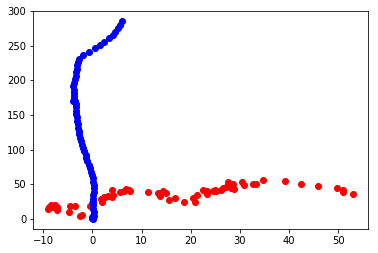

Count:326
()
()
Relative Depth: -35.81808836423363
Relative x: 52.59643327727475
Relative Original Depth: -286.4290595817052
Relative Original x: 6.125937105727353
Count:327
()
()
Relative Depth: -35.58733747033516
Relative x: 52.27140615605335
Relative Original Depth: -287.4225843294741
Relative Original x: 6.19362409478315
Count:328
()
()
Relative Depth: -35.39362213230633
Relative x: 52.00075331433905
Relative Original Depth: -288.41307367282093
Relative Original x: 6.276785160134982
Count:329
()
()
Relative Depth: -35.38742332363997
Relative x: 51.9614179037722
Relative Original Depth: -289.40589678752616
Relative Original x: 6.339664058927791
Count:330
()
()
Relative Depth: -35.26377419722233
Relative x: 52.23393674261771
Relative Original Depth: -290.39904389193373
Relative Original x: 6.372471426397707


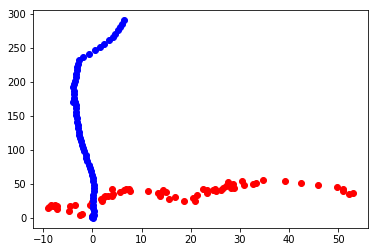

Count:331
()
()
Relative Depth: -35.03654573726056
Relative x: 52.42886851677174
Relative Original Depth: -291.39048236282747
Relative Original x: 6.436528437715411
Count:332
()
()
Relative Depth: -35.184126113210404
Relative x: 52.02273456978273
Relative Original Depth: -292.3818512946427
Relative Original x: 6.466076583195673
Count:333
()
()
Relative Depth: -35.688017143564565
Relative x: 51.26471438474383
Relative Original Depth: -293.37338658923807
Relative Original x: 6.543309213146552
Count:334
()
()
Relative Depth: -36.34044005347421
Relative x: 50.562555330497354
Relative Original Depth: -294.3656982951005
Relative Original x: 6.628243839323576
Count:335
()
()
Relative Depth: -37.17827100775831
Relative x: 50.01877221064663
Relative Original Depth: -295.35736171907706
Relative Original x: 6.7099588100031236


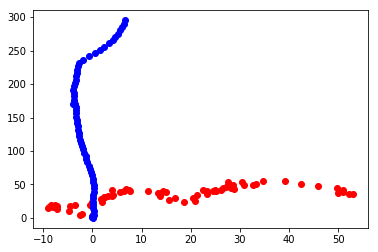

Count:336
()
()
Relative Depth: -38.0582155219267
Relative x: 49.74472795157565
Relative Original Depth: -296.3463376911443
Relative Original x: 6.79815184431837
Count:337
()
()
Relative Depth: -38.78915966004663
Relative x: 49.753291727081745
Relative Original Depth: -297.3335263211982
Relative Original x: 6.924589057282606
Count:338
()
()
Relative Depth: -38.44731959860705
Relative x: 50.15059168612027
Relative Original Depth: -298.32037153721114
Relative Original x: 7.02959279356176
Count:339
()
()
Relative Depth: -39.23193314321167
Relative x: 50.32306096713035
Relative Original Depth: -299.3064359052572
Relative Original x: 7.124189397015634
Count:340
()
()
Relative Depth: -39.70117819103689
Relative x: 50.802379571634084
Relative Original Depth: -300.29546877970904
Relative Original x: 7.194282003701152


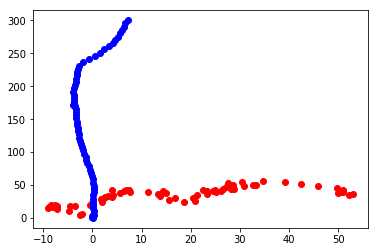

Count:341
()
()
Relative Depth: -40.668273186168875
Relative x: 50.90139285350846
Relative Original Depth: -301.28400025752757
Relative Original x: 7.29124399912547
Count:342
()
()
Relative Depth: -41.46672564198928
Relative x: 51.25498459990808
Relative Original Depth: -302.27382532479743
Relative Original x: 7.368294197533338
Count:343
()
()
Relative Depth: -41.96938296373101
Relative x: 51.74861889127017
Relative Original Depth: -303.26770936647625
Relative Original x: 7.402212781525732
Count:344
()
()
Relative Depth: -42.067345302488576
Relative x: 52.43426104776723
Relative Original Depth: -304.2611143708863
Relative Original x: 7.456737039164041
Count:345
()
()
Relative Depth: -41.587141332273056
Relative x: 52.93192565675148
Relative Original Depth: -305.2525519222197
Relative Original x: 7.541011242552081


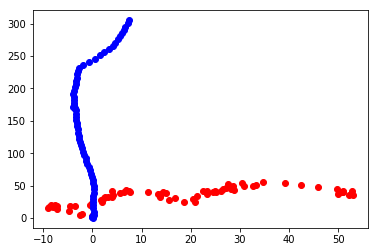

Count:346
()
()
Relative Depth: -41.04910224606495
Relative x: 53.064130436715466
Relative Original Depth: -306.243163999851
Relative Original x: 7.61229060526492
Count:347
()
()
Relative Depth: -40.352651754124565
Relative x: 53.15285083009961
Relative Original Depth: -307.23232183380225
Relative Original x: 7.719055667937083
Count:348
()
()
Relative Depth: -39.52264414587075
Relative x: 53.2465618055933
Relative Original Depth: -308.227005522776
Relative Original x: 7.739144947987315
Count:349
()
()
Relative Depth: -38.72472624968463
Relative x: 53.53293572721635
Relative Original Depth: -309.2141398152879
Relative Original x: 7.8441526418563035
Count:350
()
()
Relative Depth: -38.01884176940183
Relative x: 54.016330973753
Relative Original Depth: -310.2060184432205
Relative Original x: 7.901637126203155


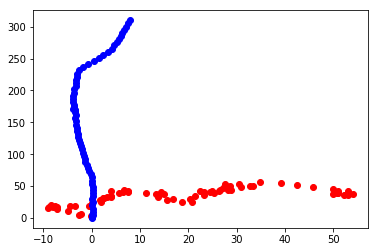

Count:351
()
()
Relative Depth: -37.42185641783163
Relative x: 54.59202345538796
Relative Original Depth: -311.1968785860985
Relative Original x: 7.970778787269034
Count:352
()
()
Relative Depth: -36.84981157856466
Relative x: 55.24817432653341
Relative Original Depth: -312.18605576752077
Relative Original x: 8.053642641122385
Count:353
()
()
Relative Depth: -36.226127389208926
Relative x: 55.92709864856382
Relative Original Depth: -313.17792645353757
Relative Original x: 8.122413808476558
Count:354
()
()
Relative Depth: -35.727499512930535
Relative x: 56.73238185411731
Relative Original Depth: -314.17186435652235
Relative Original x: 8.16497304153371
Count:355
()
()
Relative Depth: -35.11592898546991
Relative x: 57.29036016643952
Relative Original Depth: -315.1679917178216
Relative Original x: 8.160531592187033


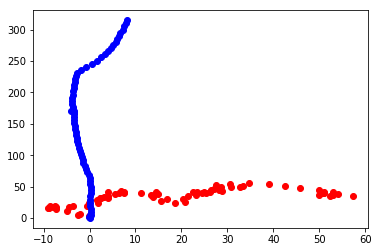

Count:356
()
()
Relative Depth: -34.5957905656514
Relative x: 57.71968413422059
Relative Original Depth: -316.15654736904975
Relative Original x: 8.235732034645403
Count:357
()
()
Relative Depth: -34.09461556542545
Relative x: 58.08187210358393
Relative Original Depth: -317.1462508754199
Relative Original x: 8.243741737602194
Count:358
()
()
Relative Depth: -33.64770851880409
Relative x: 58.382395969726524
Relative Original Depth: -318.1287457555131
Relative Original x: 8.374915092391952
Count:359
()
()
Relative Depth: -33.13877341873639
Relative x: 58.751244462594194
Relative Original Depth: -319.1133875370421
Relative Original x: 8.421241681627638
Count:360
()
()
Relative Depth: -32.46555021058421
Relative x: 59.20170404709198
Relative Original Depth: -320.10306645222784
Relative Original x: 8.490413950172293


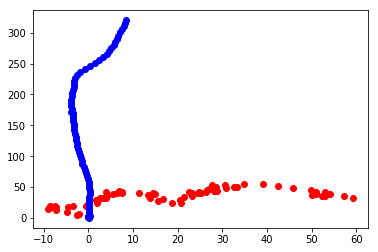

Count:361
()
()
Relative Depth: -32.09456346042696
Relative x: 59.753084937446445
Relative Original Depth: -321.0944117101799
Relative Original x: 8.519769781974642
Count:362
()
()
Relative Depth: -32.093751951713614
Relative x: 60.25318327627923
Relative Original Depth: -322.0884842186596
Relative Original x: 8.564202883458456
Count:363
()
()
Relative Depth: -31.90358250766447
Relative x: 60.61461244055942
Relative Original Depth: -323.08117999583794
Relative Original x: 8.521523384339037
Count:364
()
()
Relative Depth: -32.71736799800089
Relative x: 61.09360938085664
Relative Original Depth: -324.07242406773594
Relative Original x: 8.59753983933219
Count:365
()
()
Relative Depth: -32.701588308973925
Relative x: 61.321782268313406
Relative Original Depth: -325.0634274347741
Relative Original x: 8.689261828001474


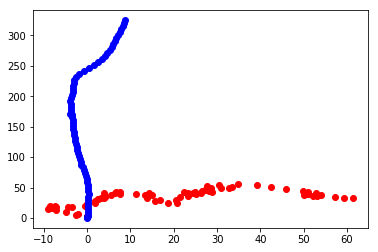

Count:366
()
()
Relative Depth: -32.768507554288895
Relative x: 61.62473678422418
Relative Original Depth: -326.04883747487895
Relative Original x: 8.795716493496792
Count:367
()
()
Relative Depth: -32.69479888166101
Relative x: 61.94782620176808
Relative Original Depth: -327.03534754586366
Relative Original x: 8.92423344259191
Count:368
()
()
Relative Depth: -32.609802284372314
Relative x: 62.20014788370308
Relative Original Depth: -328.02502424278003
Relative Original x: 9.016473708995457
Count:369
()
()
Relative Depth: -32.55382783847604
Relative x: 62.38584801442008
Relative Original Depth: -329.01271589038856
Relative Original x: 9.083320722824558
Count:370
()
()
Relative Depth: -32.61739849024983
Relative x: 62.68255737775767
Relative Original Depth: -330.00504406873057
Relative Original x: 9.119670209921923


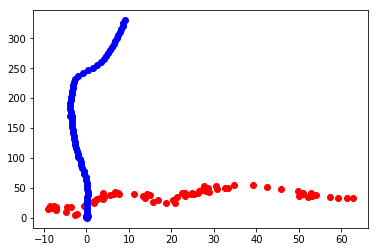

Count:371
()
()
Relative Depth: -33.61463823808399
Relative x: 62.70198969306931
Relative Original Depth: -330.9962353847712
Relative Original x: 9.19406036525166
Count:372
()
()
Relative Depth: -33.88491696000385
Relative x: 63.02607944080717
Relative Original Depth: -331.9869812947365
Relative Original x: 9.223023494643382
Count:373
()
()
Relative Depth: -34.322394762917654
Relative x: 63.29258386527012
Relative Original Depth: -332.97317560411744
Relative Original x: 9.343456489838655
Count:374
()
()
Relative Depth: -34.64301770204102
Relative x: 63.317220764134625
Relative Original Depth: -333.9632011224998
Relative Original x: 9.423506602056877
Count:375
()
()
Relative Depth: -33.96491057024202
Relative x: 63.15911270283292
Relative Original Depth: -334.9530201675306
Relative Original x: 9.508993558966152


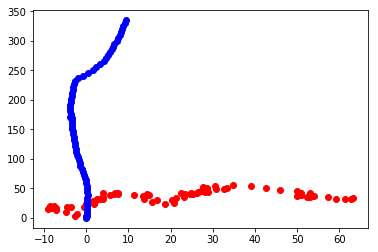

Count:376
()
()
Relative Depth: -33.86375797919858
Relative x: 62.88579682398981
Relative Original Depth: -335.94466280907403
Relative Original x: 9.601213173657653
Count:377
()
()
Relative Depth: -33.225069697319086
Relative x: 62.69840299468021
Relative Original Depth: -336.93601217662905
Relative Original x: 9.656241855227597
Count:378
()
()
Relative Depth: -32.39741485056571
Relative x: 62.66319195428613
Relative Original Depth: -337.9242179041388
Relative Original x: 9.748746192782658
Count:379
()
()
Relative Depth: -31.648813035199446
Relative x: 62.605853180133685
Relative Original Depth: -338.9190691465192
Relative Original x: 9.761106135796753
Count:380
()
()
Relative Depth: -31.001455745299555
Relative x: 62.63092109270716
Relative Original Depth: -339.9125590383259
Relative Original x: 9.789033799522963


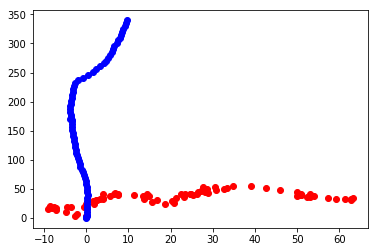

Count:381
()
()
Relative Depth: -30.21198135539668
Relative x: 63.047062054713834
Relative Original Depth: -340.9040122162875
Relative Original x: 9.846688947360724
Count:382
()
()
Relative Depth: -29.38535969956479
Relative x: 63.60492764021299
Relative Original Depth: -341.8953504220486
Relative Original x: 9.956049571749631
Count:383
()
()
Relative Depth: -28.746923812976142
Relative x: 64.1319318397842
Relative Original Depth: -342.8809676022433
Relative Original x: 10.075660523519083
Count:384
()
()
Relative Depth: -28.501014391108868
Relative x: 64.8162067291242
Relative Original Depth: -343.868494373984
Relative Original x: 10.204847839688117
Count:385
()
()
Relative Depth: -28.559385322036903
Relative x: 65.74709074864809
Relative Original Depth: -344.85680587722237
Relative Original x: 10.290235940106099


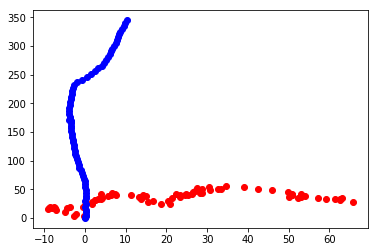

Count:386
()
()
Relative Depth: -28.871066637831383
Relative x: 66.6698717643469
Relative Original Depth: -345.8476725603576
Relative Original x: 10.334717871635336
Count:387
()
()
Relative Depth: -29.192758642000918
Relative x: 67.58553438442809
Relative Original Depth: -346.8366229990384
Relative Original x: 10.424469151315682
Count:388
()
()
Relative Depth: -29.451891491620692
Relative x: 68.54278330917545
Relative Original Depth: -347.8281421530742
Relative Original x: 10.446463898242524
Count:389
()
()
Relative Depth: -29.656473917059433
Relative x: 69.52122704434234
Relative Original Depth: -348.8183428911848
Relative Original x: 10.469295425676512
Count:390
()
()
Relative Depth: -29.943221409150688
Relative x: 70.45165386562066
Relative Original Depth: -349.80882737682
Relative Original x: 10.540218067164131


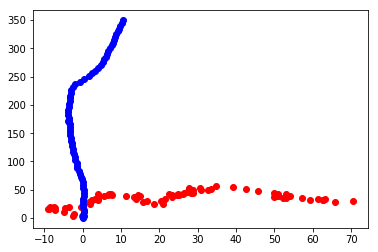

Count:391
()
()
Relative Depth: -30.508888648580122
Relative x: 71.18727711017588
Relative Original Depth: -350.79813682981853
Relative Original x: 10.662581870480851
Count:392
()
()
Relative Depth: -31.253118418732015
Relative x: 71.75216977726176
Relative Original Depth: -351.78835655438553
Relative Original x: 10.751400071340177
Count:393
()
()
Relative Depth: -32.06234051483739
Relative x: 72.22754249089535
Relative Original Depth: -352.77787883338993
Relative Original x: 10.822270221224679
Count:394
()
()
Relative Depth: -31.644989280579306
Relative x: 72.94396343202295
Relative Original Depth: -353.76868130960463
Relative Original x: 10.907964147526608
Count:395
()
()
Relative Depth: -32.53362429643332
Relative x: 73.31381461870232
Relative Original Depth: -354.7617755929739
Relative Original x: 10.98114961473426


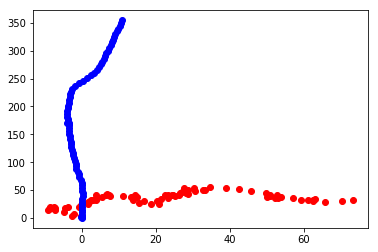

Count:396
()
()
Relative Depth: -33.46668301875065
Relative x: 73.54628350328332
Relative Original Depth: -355.75343795626924
Relative Original x: 11.03352544162821
Count:397
()
()
Relative Depth: -34.36607483611668
Relative x: 73.62646454195783
Relative Original Depth: -356.7438714913106
Relative Original x: 11.100111816971513
Count:398
()
()
Relative Depth: -35.117869231534854
Relative x: 74.20187069503935
Relative Original Depth: -357.73541119903496
Relative Original x: 11.1652474434167
Count:399
()
()
Relative Depth: -35.40961869954873
Relative x: 75.14116196371694
Relative Original Depth: -358.72678573535677
Relative Original x: 11.189711359448907
Count:400
()
()
Relative Depth: -34.5151955885996
Relative x: 74.86683780110823
Relative Original Depth: -359.721006890874
Relative Original x: 11.218395036981205


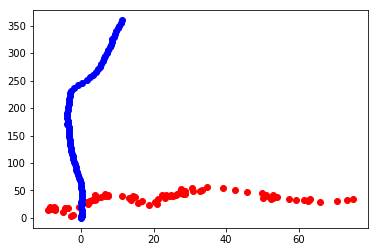

Count:401
()
()
Relative Depth: -34.423230950727465
Relative x: 74.00327985725221
Relative Original Depth: -360.7128522914322
Relative Original x: 11.282680164981214
Count:402
()
()
Relative Depth: -33.89003409595835
Relative x: 73.20958598952507
Relative Original Depth: -361.70403290834594
Relative Original x: 11.341866952107535
Count:403
()
()
Relative Depth: -33.26703746929606
Relative x: 72.4512969450381
Relative Original Depth: -362.69357951885183
Relative Original x: 11.406126912759339
Count:404
()
()
Relative Depth: -32.57925382102174
Relative x: 71.75210633957641
Relative Original Depth: -363.68192832676107
Relative Original x: 11.526727418925367
Count:405
()
()
Relative Depth: -31.73693046996211
Relative x: 71.24999459970601
Relative Original Depth: -364.67633466238505
Relative Original x: 11.53391047804676


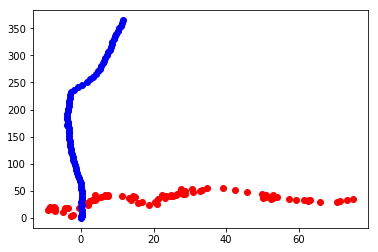

Count:406
()
()
Relative Depth: -30.779060183024143
Relative x: 71.01150638646574
Relative Original Depth: -365.6699339145693
Relative Original x: 11.567987468938767
Count:407
()
()
Relative Depth: -29.834238068587823
Relative x: 70.75598197438279
Relative Original Depth: -366.6609138435595
Relative Original x: 11.633223361266449
Count:408
()
()
Relative Depth: -28.834990699554837
Relative x: 70.71745182426302
Relative Original Depth: -367.6451610238566
Relative Original x: 11.787267577455868
Count:409
()
()
Relative Depth: -27.835257382988317
Relative x: 70.71000155287201
Relative Original Depth: -368.63493204244844
Relative Original x: 11.830766491858963
Count:410
()
()
Relative Depth: -27.004387910192804
Relative x: 70.74272082506717
Relative Original Depth: -369.62488132652635
Relative Original x: 11.86358233690214


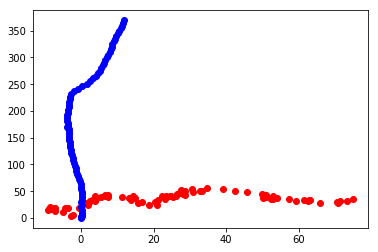

Count:411
()
()
Relative Depth: -26.02956876090548
Relative x: 70.85967108297729
Relative Original Depth: -370.6160822160163
Relative Original x: 11.940395378188304
Count:412
()
()
Relative Depth: -25.21493507847718
Relative x: 71.42844331815782
Relative Original Depth: -371.6087320300472
Relative Original x: 11.967089370196653
Count:413
()
()
Relative Depth: -24.573591348835294
Relative x: 72.14945247612386
Relative Original Depth: -372.5971884299551
Relative Original x: 12.06177564770866
Count:414
()
()
Relative Depth: -24.036647331227815
Relative x: 72.797280229122
Relative Original Depth: -373.5850210687709
Relative Original x: 12.151009383528274
Count:415
()
()
Relative Depth: -24.994105823281664
Relative x: 72.8735351474834
Relative Original Depth: -374.5755587728435
Relative Original x: 12.24724162645285


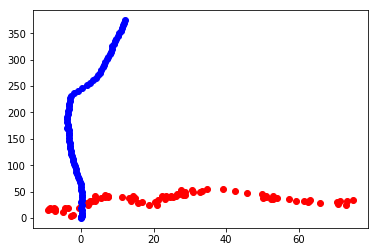

Count:416
()
()
Relative Depth: -24.595528046325985
Relative x: 73.35836022910433
Relative Original Depth: -375.56565069323267
Relative Original x: 12.322891658606776
Count:417
()
()
Relative Depth: -24.44151032403109
Relative x: 73.85697880327102
Relative Original Depth: -376.55630665901714
Relative Original x: 12.365980740494413
Count:418
()
()
Relative Depth: -24.728896879238278
Relative x: 74.33758493079338
Relative Original Depth: -377.54880517803866
Relative Original x: 12.390748489278206
Count:419
()
()
Relative Depth: -25.13852131779847
Relative x: 74.88715084431118
Relative Original Depth: -378.5368028224823
Relative Original x: 12.447759706013963
Count:420
()
()
Relative Depth: -25.50104051835153
Relative x: 75.50662107886949
Relative Original Depth: -379.52513746532617
Relative Original x: 12.534436761486418


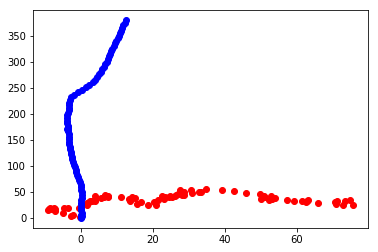

Count:421
()
()
Relative Depth: -25.04769109572297
Relative x: 76.24513217040484
Relative Original Depth: -380.51326543667943
Relative Original x: 12.600224210981727
Count:422
()
()
Relative Depth: -24.052131900435757
Relative x: 76.25248512037763
Relative Original Depth: -381.5022046947012
Relative Original x: 12.618311269424975
Count:423
()
()
Relative Depth: -23.064704229652705
Relative x: 76.1700075443965
Relative Original Depth: -382.49175528545885
Relative Original x: 12.697045724932346
Count:424
()
()
Relative Depth: -22.321171906321094
Relative x: 76.67029858735724
Relative Original Depth: -383.4891675829033
Relative Original x: 12.702385056612929
Count:425
()
()
Relative Depth: -22.616142948724526
Relative x: 77.30376019389703
Relative Original Depth: -384.47624604057364
Relative Original x: 12.790462399202706


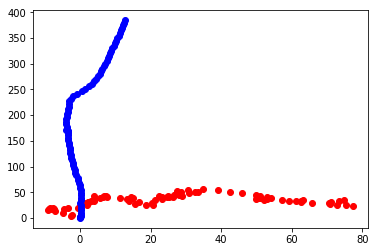

Count:426
()
()
Relative Depth: -23.289312445857767
Relative x: 77.90085965354865
Relative Original Depth: -385.4686319096392
Relative Original x: 12.846528024601938
Count:427
()
()
Relative Depth: -23.81126517404953
Relative x: 78.5297226320709
Relative Original Depth: -386.45702313296573
Relative Original x: 12.976382561916484
Count:428
()
()
Relative Depth: -24.234087706234593
Relative x: 79.09146313047799
Relative Original Depth: -387.44733949590574
Relative Original x: 13.03019529417113
Count:429
()
()
Relative Depth: -25.151308881249193
Relative x: 79.48944508094631
Relative Original Depth: -388.44019983008883
Relative Original x: 13.108224212234916
Count:430
()
()
Relative Depth: -25.807068977675964
Relative x: 79.94492409339921
Relative Original Depth: -389.4321713072027
Relative Original x: 13.121539666589449


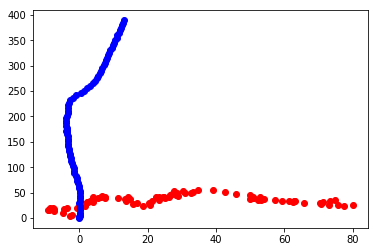

Count:431
()
()
Relative Depth: -26.573749957711016
Relative x: 80.33581506648781
Relative Original Depth: -390.4237056646758
Relative Original x: 13.169530214193284
Count:432
()
()
Relative Depth: -27.322265309115632
Relative x: 80.59821920901413
Relative Original Depth: -391.4136160058943
Relative Original x: 13.254460052499685
Count:433
()
()
Relative Depth: -28.045565140362175
Relative x: 80.72720920751125
Relative Original Depth: -392.40100896347957
Relative Original x: 13.292658863538625
Count:434
()
()
Relative Depth: -28.780670187021087
Relative x: 80.85607701280965
Relative Original Depth: -393.3920410574177
Relative Original x: 13.396284683301516
Count:435
()
()
Relative Depth: -29.50143669634746
Relative x: 80.98743375357749
Relative Original Depth: -394.38144786053334
Relative Original x: 13.471859178467781


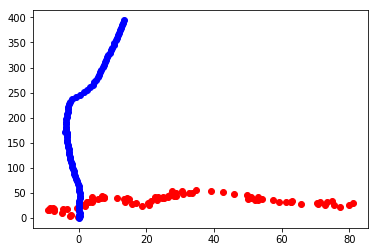

Count:436
()
()
Relative Depth: -29.449045958995097
Relative x: 81.61718226123656
Relative Original Depth: -395.37540403410196
Relative Original x: 13.446148996693532
Count:437
()
()
Relative Depth: -30.105072764152645
Relative x: 81.87482232024882
Relative Original Depth: -396.3679755068392
Relative Original x: 13.496921506782913
Count:438
()
()
Relative Depth: -30.78844577652691
Relative x: 82.22003202149939
Relative Original Depth: -397.36148496673883
Relative Original x: 13.51284634100916
Count:439
()
()
Relative Depth: -31.67927481251823
Relative x: 82.5033278143494
Relative Original Depth: -398.3539147766001
Relative Original x: 13.534577699055976
Count:440
()
()
Relative Depth: -32.46337648361934
Relative x: 82.74953096660124
Relative Original Depth: -399.34505524767485
Relative Original x: 13.61003921705099


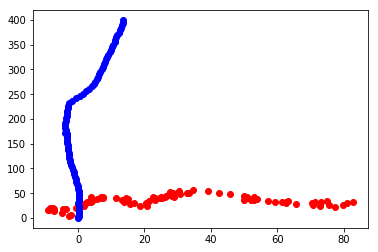

Count:441
()
()
Relative Depth: -33.433795857883126
Relative x: 82.50870399441
Relative Original Depth: -400.337768687584
Relative Original x: 13.691038678436684
Count:442
()
()
Relative Depth: -34.13076506181296
Relative x: 82.18126524599784
Relative Original Depth: -401.33438421286434
Relative Original x: 13.679285910205708
Count:443
()
()
Relative Depth: -34.963171953803005
Relative x: 81.65995328258613
Relative Original Depth: -402.327214931523
Relative Original x: 13.733948472331871
Count:444
()
()
Relative Depth: -35.70817952106042
Relative x: 81.37673300626535
Relative Original Depth: -403.31873725416074
Relative Original x: 13.777373937245285
Count:445
()
()
Relative Depth: -36.480988045758075
Relative x: 81.53989485817613
Relative Original Depth: -404.31194099788377
Relative Original x: 13.810355920518907


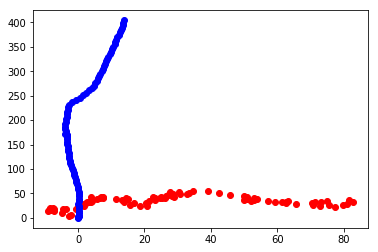

Count:446
()
()
Relative Depth: -37.428348385153974
Relative x: 81.84654852723843
Relative Original Depth: -405.30257194090757
Relative Original x: 13.855628626200977
Count:447
()
()
Relative Depth: -36.60717129865854
Relative x: 82.14051591847571
Relative Original Depth: -406.29246346801136
Relative Original x: 13.893725257812214
Count:448
()
()
Relative Depth: -36.84407756193711
Relative x: 82.69421856224275
Relative Original Depth: -407.27842925642057
Relative Original x: 13.967394385185743
Count:449
()
()
Relative Depth: -37.79481406913547
Relative x: 83.00348513778935
Relative Original Depth: -408.27072673992285
Relative Original x: 14.015082382464971
Count:450
()
()
Relative Depth: -38.54253755693521
Relative x: 83.52195138534813
Relative Original Depth: -409.2608094348712
Relative Original x: 14.099841124253393


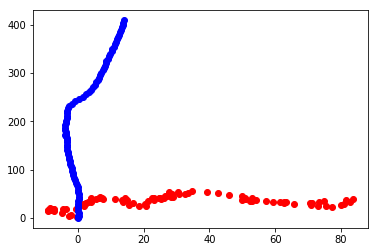

Count:451
()
()
Relative Depth: -38.833977329968
Relative x: 84.30061145282997
Relative Original Depth: -410.252617743404
Relative Original x: 14.137589908843792
Count:452
()
()
Relative Depth: -38.6433182554857
Relative x: 84.08377810440913
Relative Original Depth: -411.2409427059956
Relative Original x: 14.226255336433361
Count:453
()
()
Relative Depth: -38.90978287090351
Relative x: 84.47166340813096
Relative Original Depth: -412.22485805987407
Relative Original x: 14.345942654759197
Count:454
()
()
Relative Depth: -39.31832043924019
Relative x: 84.0583217046892
Relative Original Depth: -413.2102614785009
Relative Original x: 14.395445367114988
Count:455
()
()
Relative Depth: -39.57261093788291
Relative x: 83.57376777257095
Relative Original Depth: -414.1988123893037
Relative Original x: 14.481172204184496


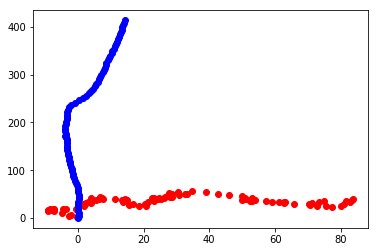

Count:456
()
()
Relative Depth: -39.579359554805194
Relative x: 83.24239999814993
Relative Original Depth: -415.1884196723389
Relative Original x: 14.558142596493878
Count:457
()
()
Relative Depth: -39.645046909581815
Relative x: 83.10650745673584
Relative Original Depth: -416.17430498183995
Relative Original x: 14.679227788900864
Count:458
()
()
Relative Depth: -39.74191802019016
Relative x: 83.1250824116252
Relative Original Depth: -417.16542224392595
Relative Original x: 14.766363020479208
Count:459
()
()
Relative Depth: -39.94508191125733
Relative x: 83.26442975498148
Relative Original Depth: -418.15325216370985
Relative Original x: 14.84454546457829
Count:460
()
()
Relative Depth: -40.533184054564444
Relative x: 83.42097388024932
Relative Original Depth: -419.1440542687015
Relative Original x: 14.899831498647137


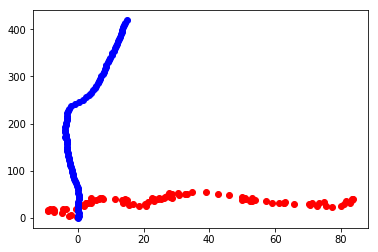

Count:461
()
()
Relative Depth: -40.74434389438469
Relative x: 83.60269908097862
Relative Original Depth: -420.13392182526405
Relative Original x: 14.978825083134238
Count:462
()
()
Relative Depth: -40.909312761025696
Relative x: 84.04420868815377
Relative Original Depth: -421.1236364582652
Relative Original x: 15.041209730390952
Count:463
()
()
Relative Depth: -40.6955260751132
Relative x: 83.84660947553868
Relative Original Depth: -422.11621751297963
Relative Original x: 15.069997178593178
Count:464
()
()
Relative Depth: -40.91731801973636
Relative x: 84.51236266085468
Relative Original Depth: -423.10838273266023
Relative Original x: 15.176754290784055
Count:465
()
()
Relative Depth: -41.46641660196843
Relative x: 84.81900455731976
Relative Original Depth: -424.09916979935616
Relative Original x: 15.272949814030937


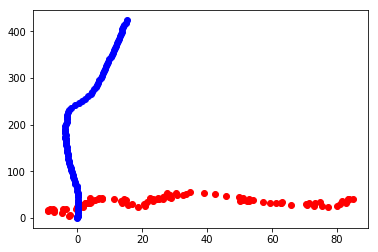

Count:466
()
()
Relative Depth: -41.73283696617581
Relative x: 85.51497575340278
Relative Original Depth: -425.09149152315746
Relative Original x: 15.342534863134743
Count:467
()
()
Relative Depth: -42.05785017989088
Relative x: 86.2523201885297
Relative Original Depth: -426.08461616824826
Relative Original x: 15.372522174584237
Count:468
()
()
Relative Depth: -42.400328489240735
Relative x: 86.9806065331928
Relative Original Depth: -427.0799386474943
Relative Original x: 15.418484299168439
Count:469
()
()
Relative Depth: -42.72466460551185
Relative x: 87.66431210812995
Relative Original Depth: -428.0728284645852
Relative Original x: 15.524836448772579
Count:470
()
()
Relative Depth: -43.10534796254081
Relative x: 88.21037033302525
Relative Original Depth: -429.06575695865325
Relative Original x: 15.593500868389333


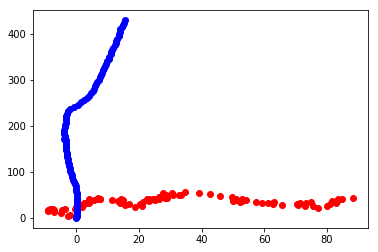

Count:471
()
()
Relative Depth: -43.328466514483786
Relative x: 89.18432774592728
Relative Original Depth: -430.0584608586571
Relative Original x: 15.66909201125152
Count:472
()
()
Relative Depth: -43.76670090599366
Relative x: 88.94988222146048
Relative Original Depth: -431.04893181730284
Relative Original x: 15.703066947011926
Count:473
()
()
Relative Depth: -44.14221339878655
Relative x: 89.69435589154305
Relative Original Depth: -432.03912857523954
Relative Original x: 15.743046628795327
Count:474
()
()
Relative Depth: -44.591553903144536
Relative x: 90.57216321725753
Relative Original Depth: -433.02505742854936
Relative Original x: 15.854750871087441
Count:475
()
()
Relative Depth: -44.71786239723987
Relative x: 91.46263951830802
Relative Original Depth: -434.01327744215155
Relative Original x: 15.944082627534037


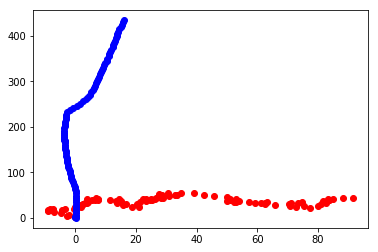

Count:476
()
()
Relative Depth: -44.29086567284051
Relative x: 92.02025371661333
Relative Original Depth: -435.0020281482186
Relative Original x: 16.01683933113839
Count:477
()
()
Relative Depth: -43.8325239066734
Relative x: 92.41909739101202
Relative Original Depth: -435.99208098289233
Relative Original x: 16.06087306393655
Count:478
()
()
Relative Depth: -43.33019202692104
Relative x: 92.51141509973003
Relative Original Depth: -436.9825044505687
Relative Original x: 16.078252392113566
Count:479
()
()
Relative Depth: -42.83172611883407
Relative x: 92.75905460866078
Relative Original Depth: -437.97245896088265
Relative Original x: 16.130611818448
Count:480
()
()
Relative Depth: -42.32927037892032
Relative x: 93.33895684757464
Relative Original Depth: -438.96485295353654
Relative Original x: 16.18438038125967


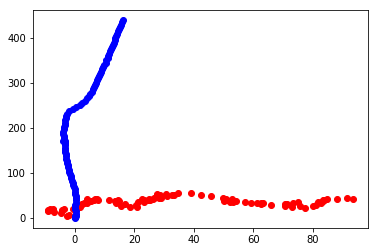

Count:481
()
()
Relative Depth: -41.99145793435978
Relative x: 94.17028010526555
Relative Original Depth: -439.960925005899
Relative Original x: 16.213136572261455
Count:482
()
()
Relative Depth: -41.86094719567955
Relative x: 95.13049098328871
Relative Original Depth: -440.95260657478514
Relative Original x: 16.287000478242952
Count:483
()
()
Relative Depth: -42.31249760675118
Relative x: 95.1228881478924
Relative Original Depth: -441.94385531297974
Relative Original x: 16.352954741114466
Count:484
()
()
Relative Depth: -42.38594253743835
Relative x: 95.44354947358919
Relative Original Depth: -442.935288594651
Relative Original x: 16.409895648400468
Count:485
()
()
Relative Depth: -42.32477370909007
Relative x: 96.42823018630773
Relative Original Depth: -443.92685633185863
Relative Original x: 16.483989413156028


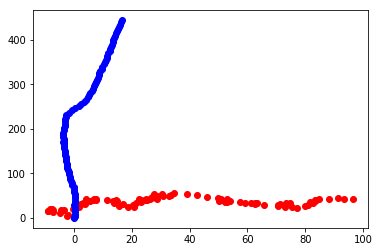

Count:486
()
()
Relative Depth: -42.29160763822573
Relative x: 96.95533351241097
Relative Original Depth: -444.9142940756434
Relative Original x: 16.577864025703985
Count:487
()
()
Relative Depth: -42.18599358868662
Relative x: 97.94360141196347
Relative Original Depth: -445.9045286826035
Relative Original x: 16.6467601918335
Count:488
()
()
Relative Depth: -42.25340219141766
Relative x: 98.92188663711968
Relative Original Depth: -446.88938832333963
Relative Original x: 16.777281543561855
Count:489
()
()
Relative Depth: -42.15772735474933
Relative x: 99.0300990726689
Relative Original Depth: -447.87684617446286
Relative Original x: 16.8716363433408
Count:490
()
()
Relative Depth: -42.42843136483204
Relative x: 99.88788296872407
Relative Original Depth: -448.8649558548513
Relative Original x: 16.977757966307482


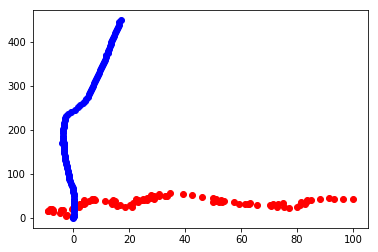

Count:491
()
()
Relative Depth: -42.821228210139395
Relative x: 100.70859419738093
Relative Original Depth: -449.8541797171118
Relative Original x: 17.047257957483065
Count:492
()
()
Relative Depth: -43.25572407257974
Relative x: 101.56425843762807
Relative Original Depth: -450.8438611306559
Relative Original x: 17.137739575810624
Count:493
()
()
Relative Depth: -43.6533270350022
Relative x: 102.4476441980986
Relative Original Depth: -451.8334174362211
Relative Original x: 17.225476771042317
Count:494
()
()
Relative Depth: -44.27358887476324
Relative x: 103.23184651149806
Relative Original Depth: -452.8203730357639
Relative Original x: 17.312191713780603
Count:495
()
()
Relative Depth: -44.6465810392165
Relative x: 104.10383216344894
Relative Original Depth: -453.8070177754404
Relative Original x: 17.37556440593772


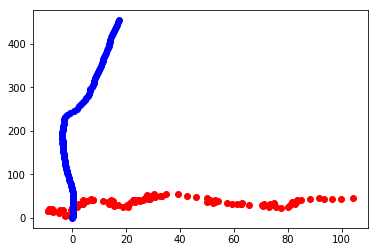

Count:496
()
()
Relative Depth: -44.62215082564698
Relative x: 105.1024663858916
Relative Original Depth: -454.7938120194769
Relative Original x: 17.46154240829927
Count:497
()
()
Relative Depth: -44.69631852150136
Relative x: 106.05406964067879
Relative Original Depth: -455.7815391230494
Relative Original x: 17.53489695476945
Count:498
()
()
Relative Depth: -44.56526108983474
Relative x: 106.98366849130635
Relative Original Depth: -456.77244940306286
Relative Original x: 17.59193749722512
Count:499
()
()
Relative Depth: -43.86426432254692
Relative x: 107.63443775928062
Relative Original Depth: -457.7626094359338
Relative Original x: 17.681607506433235
Count:500
()
()
Relative Depth: -43.12700289835827
Relative x: 107.66790593422753
Relative Original Depth: -458.75348991012476
Relative Original x: 17.767813946340766


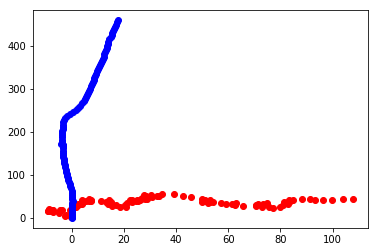

Count:501
()
()
Relative Depth: -42.378904328442424
Relative x: 108.33050654495695
Relative Original Depth: -459.7473607365357
Relative Original x: 17.829618919846233
Count:502
()
()
Relative Depth: -41.4593716476932
Relative x: 108.58801756003646
Relative Original Depth: -460.7403926671309
Relative Original x: 17.88972389491657
Count:503
()
()
Relative Depth: -41.9719899956906
Relative x: 108.46210832121201
Relative Original Depth: -461.7328560469682
Relative Original x: 17.957026235071403
Count:504
()
()
Relative Depth: -41.691138895597035
Relative x: 109.20577976516867
Relative Original Depth: -462.72588885293385
Relative Original x: 18.003201647921042
Count:505
()
()
Relative Depth: -41.38174522609624
Relative x: 109.99594692248907
Relative Original Depth: -463.72138524298583
Relative Original x: 18.04417923899167


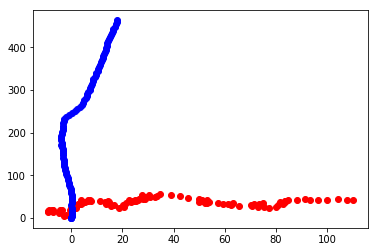

Count:506
()
()
Relative Depth: -41.05506669974631
Relative x: 110.80760836184245
Relative Original Depth: -464.71470151161265
Relative Original x: 18.079100261197787
Count:507
()
()
Relative Depth: -40.75154131592902
Relative x: 111.56546664579216
Relative Original Depth: -465.70778951189635
Relative Original x: 18.13461737699321
Count:508
()
()
Relative Depth: -40.51309772553571
Relative x: 112.28258460002884
Relative Original Depth: -466.6999303129643
Relative Original x: 18.195669015917066
Count:509
()
()
Relative Depth: -40.42343164011183
Relative x: 112.94627709663568
Relative Original Depth: -467.69198416920216
Relative Original x: 18.264843180869818
Count:510
()
()
Relative Depth: -40.4699306663165
Relative x: 113.5278684811415
Relative Original Depth: -468.68379712675016
Relative Original x: 18.27254918524317


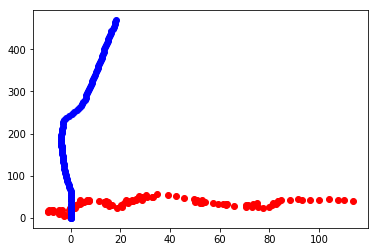

Count:511
()
()
Relative Depth: -41.004185534111855
Relative x: 113.67293477088162
Relative Original Depth: -469.6735973889412
Relative Original x: 18.3492968825041
Count:512
()
()
Relative Depth: -41.82688171421988
Relative x: 113.29218886814576
Relative Original Depth: -470.6613063246797
Relative Original x: 18.454132604027976
Count:513
()
()
Relative Depth: -42.63334110402145
Relative x: 112.72870156019835
Relative Original Depth: -471.6523536050899
Relative Original x: 18.51588281236548
Count:514
()
()
Relative Depth: -43.27738710539703
Relative x: 111.96424274735065
Relative Original Depth: -472.6415203813456
Relative Original x: 18.60511663350164
Count:515
()
()
Relative Depth: -43.8257229612924
Relative x: 111.16847921008957
Relative Original Depth: -473.63081238861105
Relative Original x: 18.67660230263064


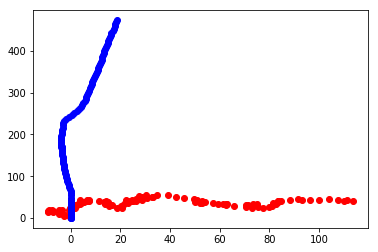

Count:516
()
()
Relative Depth: -44.419750570829244
Relative x: 110.39595896540065
Relative Original Depth: -474.6208662742783
Relative Original x: 18.727044660202928
Count:517
()
()
Relative Depth: -44.96650051944425
Relative x: 109.5808593899121
Relative Original Depth: -475.6106135711001
Relative Original x: 18.78430028598802
Count:518
()
()
Relative Depth: -45.49144657419608
Relative x: 108.77359485409302
Relative Original Depth: -476.6009810826512
Relative Original x: 18.85325093620679
Count:519
()
()
Relative Depth: -45.70261115895365
Relative x: 107.83705265240314
Relative Original Depth: -477.59192909057134
Relative Original x: 18.925986420129174
Count:520
()
()
Relative Depth: -46.37614583242746
Relative x: 107.21107853283621
Relative Original Depth: -478.5856246774767
Relative Original x: 18.952716005997168


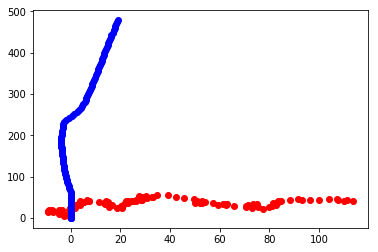

Count:521
()
()
Relative Depth: -46.16788321492539
Relative x: 106.33343054880633
Relative Original Depth: -479.57602287829604
Relative Original x: 19.028494994740253
Count:522
()
()
Relative Depth: -45.914231152913636
Relative x: 105.62071334869582
Relative Original Depth: -480.5675903290479
Relative Original x: 19.11658510863683
Count:523
()
()
Relative Depth: -45.607637104180085
Relative x: 104.75203206729825
Relative Original Depth: -481.55976796393907
Relative Original x: 19.17098492298865
Count:524
()
()
Relative Depth: -45.31934346385396
Relative x: 103.79920642514777
Relative Original Depth: -482.55079244879227
Relative Original x: 19.241356328136618
Count:525
()
()
Relative Depth: -44.866865240195175
Relative x: 102.90970316744233
Relative Original Depth: -483.5411167166154
Relative Original x: 19.301792839155983


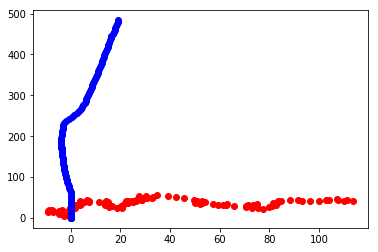

Count:526
()
()
Relative Depth: -44.22818455573015
Relative x: 102.28351427269607
Relative Original Depth: -484.5328149808009
Relative Original x: 19.38728977520666
Count:527
()
()
Relative Depth: -43.63900459971431
Relative x: 102.03001233578898
Relative Original Depth: -485.52424592563096
Relative Original x: 19.432969962354512
Count:528
()
()
Relative Depth: -43.09376080961173
Relative x: 102.01699996013137
Relative Original Depth: -486.5155309616093
Relative Original x: 19.49402049922714
Count:529
()
()
Relative Depth: -42.81623712588545
Relative x: 102.75499458320178
Relative Original Depth: -487.50682458197116
Relative Original x: 19.5576211208511
Count:530
()
()
Relative Depth: -42.8921841159018
Relative x: 103.74308702134863
Relative Original Depth: -488.4961559561841
Relative Original x: 19.621909465023464


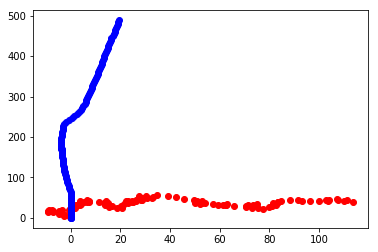

Count:531
()
()
Relative Depth: -42.3040822612856
Relative x: 103.47192296750399
Relative Original Depth: -489.4865127094874
Relative Original x: 19.6985550022016
Count:532
()
()
Relative Depth: -42.37463027402455
Relative x: 104.45032412535232
Relative Original Depth: -490.4772748565087
Relative Original x: 19.72352394117087
Count:533
()
()
Relative Depth: -42.686357239358706
Relative x: 105.39634204028873
Relative Original Depth: -491.46903203461073
Relative Original x: 19.780605366788276
Count:534
()
()
Relative Depth: -43.34925755476932
Relative x: 106.11431170645388
Relative Original Depth: -492.4593219425212
Relative Original x: 19.790887203819704
Count:535
()
()
Relative Depth: -44.12192742485158
Relative x: 106.62634499273358
Relative Original Depth: -493.4512032199392
Relative Original x: 19.79915064879046


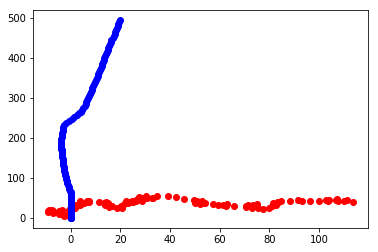

Count:536
()
()
Relative Depth: -44.979277974011396
Relative x: 107.10837518946273
Relative Original Depth: -494.44195027682366
Relative Original x: 19.894522853337094
Count:537
()
()
Relative Depth: -45.84870562419222
Relative x: 107.59354919404505
Relative Original Depth: -495.42950360441006
Relative Original x: 19.894648455496785
Count:538
()
()
Relative Depth: -46.68024675435459
Relative x: 108.08511410309357
Relative Original Depth: -496.41971786876917
Relative Original x: 19.927544873365374
Count:539
()
()
Relative Depth: -47.57862594454177
Relative x: 108.4131586234127
Relative Original Depth: -497.4103753402967
Relative Original x: 19.981885102980463
Count:540
()
()
Relative Depth: -48.470516793681035
Relative x: 108.7312984076448
Relative Original Depth: -498.3997630141329
Relative Original x: 20.084266982659866


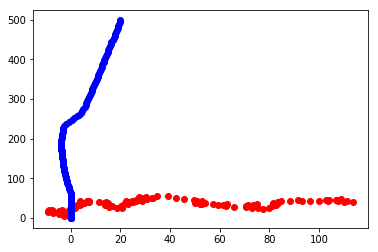

Count:541
()
()
Relative Depth: -49.17240888367388
Relative x: 109.26782599972549
Relative Original Depth: -499.39099098382604
Relative Original x: 20.087778430036785
Count:542
()
()
Relative Depth: -49.74144116288611
Relative x: 109.91824571933705
Relative Original Depth: -500.3767045152237
Relative Original x: 20.19845745526043
Count:543
()
()
Relative Depth: -50.34839085209418
Relative x: 110.451141327452
Relative Original Depth: -501.3655822784509
Relative Original x: 20.30162134714309
Count:544
()
()
Relative Depth: -50.92368062205534
Relative x: 110.85278140708114
Relative Original Depth: -502.3529713592563
Relative Original x: 20.37746194413848
Count:545
()
()
Relative Depth: -51.39217689176587
Relative x: 111.29616003394906
Relative Original Depth: -503.3435959512875
Relative Original x: 20.43470784608018


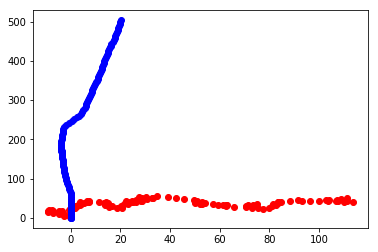

Count:546
()
()
Relative Depth: -51.77503142072896
Relative x: 111.73492675735324
Relative Original Depth: -504.3327069312768
Relative Original x: 20.515410112714548
Count:547
()
()
Relative Depth: -51.929640369205245
Relative x: 112.09181726502872
Relative Original Depth: -505.32301148575453
Relative Original x: 20.5367167913323
Count:548
()
()
Relative Depth: -52.140074000055726
Relative x: 112.37660898707847
Relative Original Depth: -506.3113792371741
Relative Original x: 20.630699438765916
Count:549
()
()
Relative Depth: -52.67301591195102
Relative x: 112.59430276047806
Relative Original Depth: -507.30513468818435
Relative Original x: 20.669348929050496
Count:550
()
()
Relative Depth: -53.08944720204465
Relative x: 112.5671155739463
Relative Original Depth: -508.2908775642887
Relative Original x: 20.801089972592234


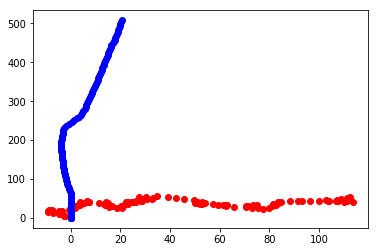

Count:551
()
()
Relative Depth: -53.132679993176986
Relative x: 112.4139548157782
Relative Original Depth: -509.2822938073625
Relative Original x: 20.884131453141965
Count:552
()
()
Relative Depth: -53.1442367630385
Relative x: 112.31973450291224
Relative Original Depth: -510.26743625046777
Relative Original x: 20.983708404877262
Count:553
()
()
Relative Depth: -53.12581627396042
Relative x: 112.21389909410749
Relative Original Depth: -511.2557790540341
Relative Original x: 21.04949563182427
Count:554
()
()
Relative Depth: -53.009760570515866
Relative x: 112.06773264422893
Relative Original Depth: -512.2456818136866
Relative Original x: 21.138029800043867
Count:555
()
()
Relative Depth: -53.814309167534056
Relative x: 111.71336302695128
Relative Original Depth: -513.2324457471091
Relative Original x: 21.2338950262663


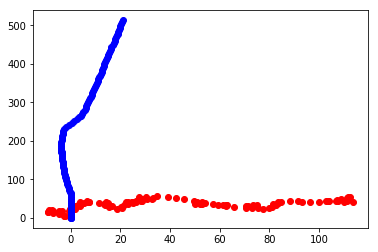

Count:556
()
()
Relative Depth: -53.09590434529734
Relative x: 112.24632558418023
Relative Original Depth: -514.2236831645595
Relative Original x: 21.266637766248685
Count:557
()
()
Relative Depth: -52.323674432431496
Relative x: 112.79209636681038
Relative Original Depth: -515.21361756982
Relative Original x: 21.328886427064873
Count:558
()
()
Relative Depth: -51.68232979824323
Relative x: 113.4387148304536
Relative Original Depth: -516.2048311178281
Relative Original x: 21.37502691764335
Count:559
()
()
Relative Depth: -51.28278222585819
Relative x: 114.31382581932674
Relative Original Depth: -517.1970364032043
Relative Original x: 21.438311213493787
Count:560
()
()
Relative Depth: -51.1213425473549
Relative x: 115.22994908957398
Relative Original Depth: -518.1887992902597
Relative Original x: 21.45685142324125


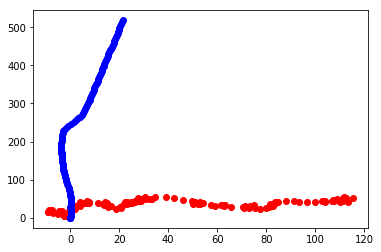

Count:561
()
()
Relative Depth: -51.21045779469959
Relative x: 115.10914945831856
Relative Original Depth: -519.1756077686679
Relative Original x: 21.594763089392092
Count:562
()
()
Relative Depth: -51.09396161678905
Relative x: 115.79372809941763
Relative Original Depth: -520.1658500276874
Relative Original x: 21.645244545280907
Count:563
()
()
Relative Depth: -50.92078310263921
Relative x: 115.95031764719388
Relative Original Depth: -521.1557910483931
Relative Original x: 21.71308857123027
Count:564
()
()
Relative Depth: -50.84160785712019
Relative x: 115.56295985744096
Relative Original Depth: -522.1448429213565
Relative Original x: 21.807980218035915
Count:565
()
()
Relative Depth: -50.87769020932832
Relative x: 115.13924144698626
Relative Original Depth: -523.1341635281368
Relative Original x: 21.88610467539086


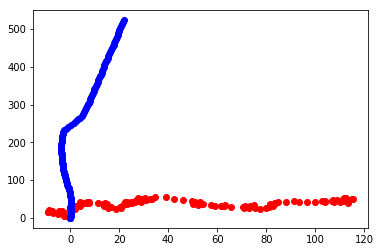

Count:566
()
()
Relative Depth: -50.9938573832728
Relative x: 114.77810520748088
Relative Original Depth: -524.1255459762035
Relative Original x: 21.934926018410735
Count:567
()
()
Relative Depth: -51.068332999155565
Relative x: 114.15903380417473
Relative Original Depth: -525.1166375726502
Relative Original x: 22.01503911254009
Count:568
()
()
Relative Depth: -51.1464442454675
Relative x: 113.30596547959745
Relative Original Depth: -526.1040069870982
Relative Original x: 22.14366656876631
Count:569
()
()
Relative Depth: -51.263763724256854
Relative x: 112.46054834990602
Relative Original Depth: -527.0951832710512
Relative Original x: 22.232990837285104
Count:570
()
()
Relative Depth: -51.3020321158921
Relative x: 111.54643856751484
Relative Original Depth: -528.086175184045
Relative Original x: 22.291555522790848


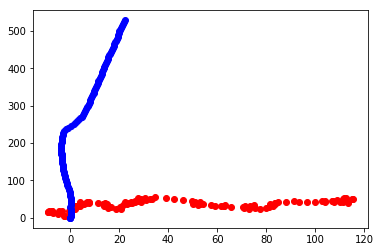

Count:571
()
()
Relative Depth: -51.32217797984799
Relative x: 110.59106201095663
Relative Original Depth: -529.0779007681941
Relative Original x: 22.370467723548323
Count:572
()
()
Relative Depth: -51.36296445062195
Relative x: 109.59876889902804
Relative Original Depth: -530.0676085958751
Relative Original x: 22.467995859893264
Count:573
()
()
Relative Depth: -51.50082473856901
Relative x: 108.61816193310612
Relative Original Depth: -531.0577409962546
Relative Original x: 22.5488165698606
Count:574
()
()
Relative Depth: -51.668570936877956
Relative x: 107.69443246059043
Relative Original Depth: -532.048266363797
Relative Original x: 22.62996696095868
Count:575
()
()
Relative Depth: -51.57669140088397
Relative x: 106.70085930439824
Relative Original Depth: -533.0381256943151
Relative Original x: 22.6711973869969


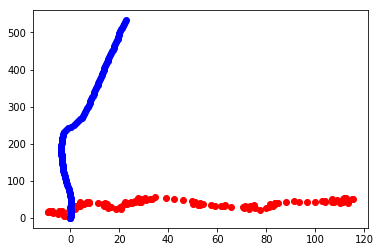

Count:576
()
()
Relative Depth: -51.29022589476239
Relative x: 105.74367420726533
Relative Original Depth: -534.025966720651
Relative Original x: 22.80502292263091
Count:577
()
()
Relative Depth: -50.98042147578526
Relative x: 104.79626628349791
Relative Original Depth: -535.0144611930549
Relative Original x: 22.88781976040677
Count:578
()
()
Relative Depth: -50.60471964560059
Relative x: 104.26219484960022
Relative Original Depth: -536.0006104690734
Relative Original x: 22.99447704410067
Count:579
()
()
Relative Depth: -50.35881463187471
Relative x: 103.29704625377916
Relative Original Depth: -536.9914410198023
Relative Original x: 23.068177015848757
Count:580
()
()
Relative Depth: -50.21338575294844
Relative x: 102.36114295693572
Relative Original Depth: -537.9813878014493
Relative Original x: 23.13670164251107


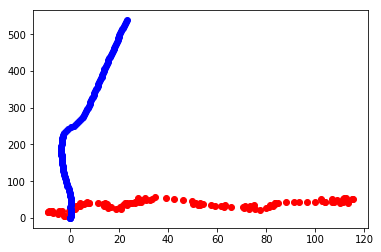

Count:581
()
()
Relative Depth: -50.146978353997966
Relative x: 101.53991809244027
Relative Original Depth: -538.9703299068645
Relative Original x: 23.197595213915516
Count:582
()
()
Relative Depth: -49.877847626621474
Relative x: 101.0705463811573
Relative Original Depth: -539.9657834921846
Relative Original x: 23.23000459054708
Count:583
()
()
Relative Depth: -49.56431205817534
Relative x: 101.19989102499608
Relative Original Depth: -540.9560058517947
Relative Original x: 23.29451025623008
Count:584
()
()
Relative Depth: -49.377601687322546
Relative x: 101.42102254894724
Relative Original Depth: -541.9463111354784
Relative Original x: 23.365904648988792
Count:585
()
()
Relative Depth: -49.81061172901904
Relative x: 101.36426977433416
Relative Original Depth: -542.9379942892974
Relative Original x: 23.40337298321197


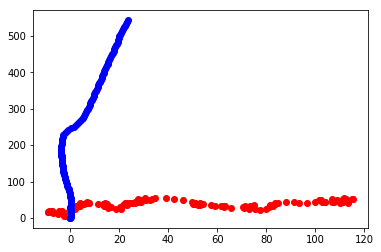

Count:586
()
()
Relative Depth: -50.66350115850395
Relative x: 101.32629308585062
Relative Original Depth: -543.9234028891507
Relative Original x: 23.448008777199167
Count:587
()
()
Relative Depth: -51.468377571708785
Relative x: 101.55122195338627
Relative Original Depth: -544.9106496027113
Relative Original x: 23.559830585736798
Count:588
()
()
Relative Depth: -52.277114494629586
Relative x: 101.72143318916152
Relative Original Depth: -545.8997487520925
Relative Original x: 23.61387026264008
Count:589
()
()
Relative Depth: -53.05333238741601
Relative x: 101.64352020546767
Relative Original Depth: -546.8896693364588
Relative Original x: 23.667629056356198
Count:590
()
()
Relative Depth: -53.790242809609424
Relative x: 101.4620275840787
Relative Original Depth: -547.8783590350243
Relative Original x: 23.697329106267254


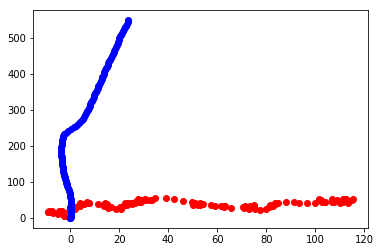

Count:591
()
()
Relative Depth: -54.5847868589253
Relative x: 101.29193936552149
Relative Original Depth: -548.8674645019198
Relative Original x: 23.75919102655532
Count:592
()
()
Relative Depth: -55.45333927936751
Relative x: 101.37228252016202
Relative Original Depth: -549.8568296708302
Relative Original x: 23.839305568410932
Count:593
()
()
Relative Depth: -56.4149775294374
Relative x: 101.53184793365138
Relative Original Depth: -550.8474583166618
Relative Original x: 23.930724382497115
Count:594
()
()
Relative Depth: -57.26731148703459
Relative x: 101.01000409466505
Relative Original Depth: -551.8378713871213
Relative Original x: 23.99516321192355
Count:595
()
()
Relative Depth: -56.31225150770872
Relative x: 100.71524171920848
Relative Original Depth: -552.8286934690556
Relative Original x: 24.10022268373473


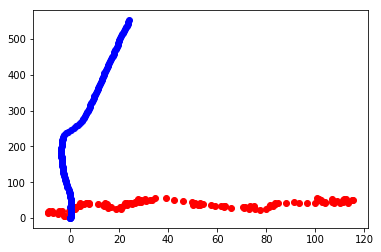

Count:596
()
()
Relative Depth: -55.5286527218209
Relative x: 100.11830276901294
Relative Original Depth: -553.8197260115938
Relative Original x: 24.16511722505348
Count:597
()
()
Relative Depth: -55.974329822952434
Relative x: 99.22511401091842
Relative Original Depth: -554.8110266469267
Relative Original x: 24.252841349143505
Count:598
()
()
Relative Depth: -56.410351878973565
Relative x: 98.32658282625925
Relative Original Depth: -555.7985898362282
Relative Original x: 24.365641042826404
Count:599
()
()
Relative Depth: -56.799065363845244
Relative x: 97.40764163949964
Relative Original Depth: -556.7895331203597
Relative Original x: 24.425144450444076
Count:600
()
()
Relative Depth: -57.48153426176608
Relative x: 96.71669639584978
Relative Original Depth: -557.779353531473
Relative Original x: 24.500097558402572


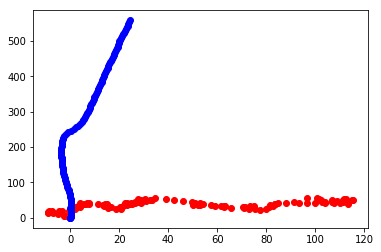

Count:601
()
()
Relative Depth: -58.327296769288445
Relative x: 96.37758829543142
Relative Original Depth: -558.7699872600701
Relative Original x: 24.573657012882318
Count:602
()
()
Relative Depth: -59.13625284742518
Relative x: 95.94999814707961
Relative Original Depth: -559.7614229553253
Relative Original x: 24.634628594253414
Count:603
()
()
Relative Depth: -59.82480775713471
Relative x: 95.28942731916291
Relative Original Depth: -560.7546758982502
Relative Original x: 24.69293369714579
Count:604
()
()
Relative Depth: -60.511873801235424
Relative x: 94.61610645677597
Relative Original Depth: -561.7461535700311
Relative Original x: 24.739299543932308
Count:605
()
()
Relative Depth: -61.19788508090612
Relative x: 93.90893042837642
Relative Original Depth: -562.7378806922997
Relative Original x: 24.806131039758128


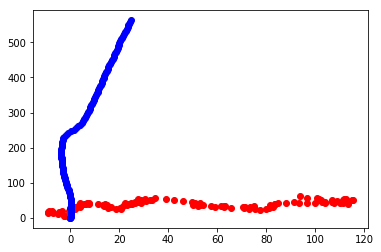

Count:606
()
()
Relative Depth: -61.65363660341616
Relative x: 93.02207761922257
Relative Original Depth: -563.728780542704
Relative Original x: 24.89108357352135
Count:607
()
()
Relative Depth: -61.58568832404126
Relative x: 92.05975021755616
Relative Original Depth: -564.7199290826419
Relative Original x: 24.961342907255364
Count:608
()
()
Relative Depth: -61.1303837882783
Relative x: 91.25005988053347
Relative Original Depth: -565.7069112550656
Relative Original x: 25.0632001139802
Count:609
()
()
Relative Depth: -61.90082692244525
Relative x: 90.62222169112196
Relative Original Depth: -566.6967399904556
Relative Original x: 25.099500459170653
Count:610
()
()
Relative Depth: -61.328752862448646
Relative x: 91.33586627025694
Relative Original Depth: -567.6882599126361
Relative Original x: 25.10862473043086


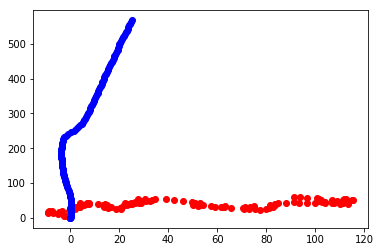

Count:611
()
()
Relative Depth: -60.87446153889603
Relative x: 90.46608429209037
Relative Original Depth: -568.6781654010258
Relative Original x: 25.181800818673622
Count:612
()
()
Relative Depth: -60.307632853791795
Relative x: 89.64640860483968
Relative Original Depth: -569.667563192344
Relative Original x: 25.24243886786324
Count:613
()
()
Relative Depth: -59.50746904736382
Relative x: 89.04671758748651
Relative Original Depth: -570.6590791144599
Relative Original x: 25.259108164090094
Count:614
()
()
Relative Depth: -58.69910478871152
Relative x: 88.45811153439367
Relative Original Depth: -571.6517700771618
Relative Original x: 25.296597843916178
Count:615
()
()
Relative Depth: -57.96197781273416
Relative x: 87.79280754253945
Relative Original Depth: -572.6426719441165
Relative Original x: 25.31432598807694


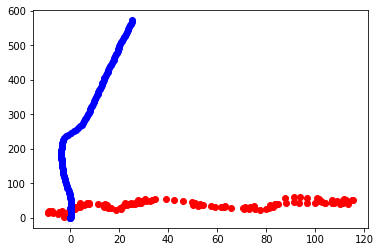

Count:616
()
()
Relative Depth: -57.15347687976939
Relative x: 87.30844287425803
Relative Original Depth: -573.6336273381671
Relative Original x: 25.363367351336535
Count:617
()
()
Relative Depth: -56.3117951456172
Relative x: 86.93869647135594
Relative Original Depth: -574.6259588871992
Relative Original x: 25.400928315380867
Count:618
()
()
Relative Depth: -55.39271790512535
Relative x: 86.67496226169658
Relative Original Depth: -575.6157103725341
Relative Original x: 25.480899295640576
Count:619
()
()
Relative Depth: -54.532850103948306
Relative x: 87.14738804435194
Relative Original Depth: -576.6038850935561
Relative Original x: 25.564719382325745
Count:620
()
()
Relative Depth: -54.388005829156654
Relative x: 88.13675042230324
Relative Original Depth: -577.5903687138327
Relative Original x: 25.658272116351768


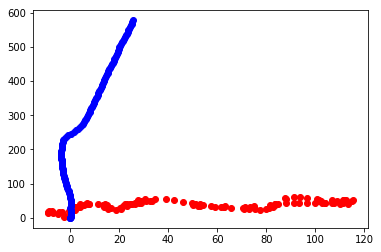

Count:621
()
()
Relative Depth: -54.535015389908075
Relative x: 89.12211836361391
Relative Original Depth: -578.5769393008242
Relative Original x: 25.769938570508124
Count:622
()
()
Relative Depth: -54.935764798103484
Relative x: 88.2436408991594
Relative Original Depth: -579.5670289730083
Relative Original x: 25.8117321852961
Count:623
()
()
Relative Depth: -55.17685603659383
Relative x: 89.20292468429307
Relative Original Depth: -580.5520656972762
Relative Original x: 25.94433999603756
Count:624
()
()
Relative Depth: -56.06785279589397
Relative x: 88.89770359600129
Relative Original Depth: -581.5440667452953
Relative Original x: 26.012265169191938
Count:625
()
()
Relative Depth: -56.222721346541825
Relative x: 89.8847887586732
Relative Original Depth: -582.538019885303
Relative Original x: 26.06724078995457


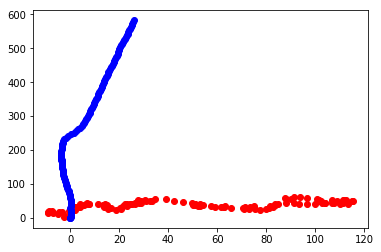

Count:626
()
()
Relative Depth: -56.334803107493265
Relative x: 90.87813735425905
Relative Original Depth: -583.5311568787548
Relative Original x: 26.11819963705831
Count:627
()
()
Relative Depth: -57.0761686181823
Relative x: 90.91424273225965
Relative Original Depth: -584.5247900220431
Relative Original x: 26.160284207906265
Count:628
()
()
Relative Depth: -57.208476129194295
Relative x: 91.9014272815464
Relative Original Depth: -585.5148404815994
Relative Original x: 26.217871221012334
Count:629
()
()
Relative Depth: -57.08658196698205
Relative x: 92.89333746028701
Relative Original Depth: -586.505398126986
Relative Original x: 26.295219724488895
Count:630
()
()
Relative Depth: -56.80964803810703
Relative x: 93.84298888498884
Relative Original Depth: -587.4965372361257
Relative Original x: 26.35511206587929


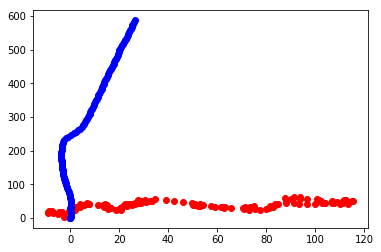

Count:631
()
()
Relative Depth: -56.63006583180531
Relative x: 94.72813094311975
Relative Original Depth: -588.4841835640001
Relative Original x: 26.425342129564665
Count:632
()
()
Relative Depth: -56.55561369553704
Relative x: 95.6230874726938
Relative Original Depth: -589.4781554045147
Relative Original x: 26.47956299540998
Count:633
()
()
Relative Depth: -57.35639905258477
Relative x: 95.03047342457864
Relative Original Depth: -590.4673109027179
Relative Original x: 26.542524486310153
Count:634
()
()
Relative Depth: -58.30775841048069
Relative x: 94.72257343091513
Relative Original Depth: -591.460608800537
Relative Original x: 26.596928800283653
Count:635
()
()
Relative Depth: -59.22257592542347
Relative x: 94.75066816076682
Relative Original Depth: -592.4517647456399
Relative Original x: 26.624063381489705


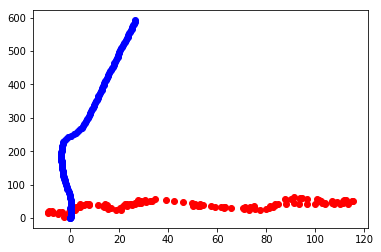

Count:636
()
()
Relative Depth: -59.06502646568694
Relative x: 95.73578496656471
Relative Original Depth: -593.4407831914887
Relative Original x: 26.70008543849908
Count:637
()
()
Relative Depth: -58.47026059776625
Relative x: 96.52341931538768
Relative Original Depth: -594.4286240095944
Relative Original x: 26.775716492715485
Count:638
()
()
Relative Depth: -57.75905455709949
Relative x: 96.98208090655005
Relative Original Depth: -595.4152334992054
Relative Original x: 26.85352623416852
Count:639
()
()
Relative Depth: -56.791866292266334
Relative x: 96.74447477938386
Relative Original Depth: -596.4020054219078
Relative Original x: 26.946142694166348
Count:640
()
()
Relative Depth: -57.75289049318048
Relative x: 96.96904718406115
Relative Original Depth: -597.3894873657348
Relative Original x: 26.97951573857465


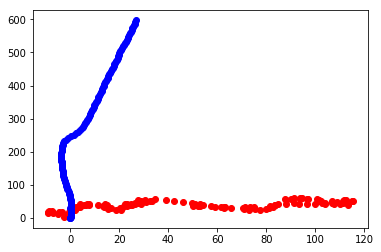

Count:641
()
()
Relative Depth: -56.81705518374848
Relative x: 96.85663376966139
Relative Original Depth: -598.3768121661377
Relative Original x: 27.06523632652313
Count:642
()
()
Relative Depth: -55.92990831811392
Relative x: 96.40227417725406
Relative Original Depth: -599.3691971011724
Relative Original x: 27.10076815928455
Count:643
()
()
Relative Depth: -55.04414430035318
Relative x: 95.95307038673103
Relative Original Depth: -600.3582691328323
Relative Original x: 27.173772437719997
Count:644
()
()
Relative Depth: -54.29314343455272
Relative x: 95.39563699906999
Relative Original Depth: -601.3468591711337
Relative Original x: 27.268049813387773
Count:645
()
()
Relative Depth: -53.768014277737336
Relative x: 94.7911554887017
Relative Original Depth: -602.3387900681021
Relative Original x: 27.330983892437423


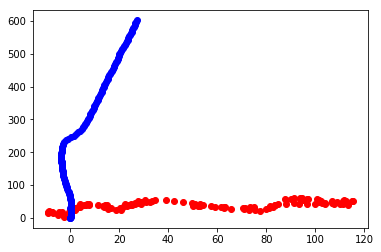

Count:646
()
()
Relative Depth: -53.205274224856566
Relative x: 94.19896648644514
Relative Original Depth: -603.329040871578
Relative Original x: 27.419149430620863
Count:647
()
()
Relative Depth: -52.3300826980055
Relative x: 93.7334707111956
Relative Original Depth: -604.3209597099991
Relative Original x: 27.481123555870163
Count:648
()
()
Relative Depth: -51.386294797485505
Relative x: 93.61404966992387
Relative Original Depth: -605.3078312690352
Relative Original x: 27.571255711479157
Count:649
()
()
Relative Depth: -50.68533673487415
Relative x: 93.59230093865982
Relative Original Depth: -606.2978774038152
Relative Original x: 27.61281413376064
Count:650
()
()
Relative Depth: -50.34916483590415
Relative x: 93.54666923951768
Relative Original Depth: -607.2892122469425
Relative Original x: 27.662827141048016


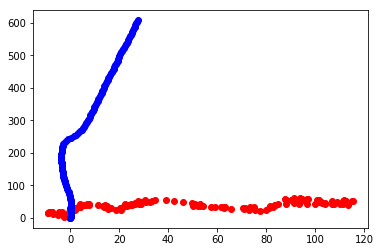

Count:651
()
()
Relative Depth: -49.88011341022629
Relative x: 92.66965969770078
Relative Original Depth: -608.2794879340784
Relative Original x: 27.73601536737247
Count:652
()
()
Relative Depth: -50.05902771717304
Relative x: 91.77188737685081
Relative Original Depth: -609.2667654013792
Relative Original x: 27.761094612119468
Count:653
()
()
Relative Depth: -49.58078830966299
Relative x: 91.64990612722393
Relative Original Depth: -610.2549704659847
Relative Original x: 27.82690425819358
Count:654
()
()
Relative Depth: -49.32921059390049
Relative x: 92.2307958872642
Relative Original Depth: -611.2409724040801
Relative Original x: 27.95277970224287
Count:655
()
()
Relative Depth: -48.59232689709059
Relative x: 91.76716728236573
Relative Original Depth: -612.2315128809131
Relative Original x: 28.04004128966114


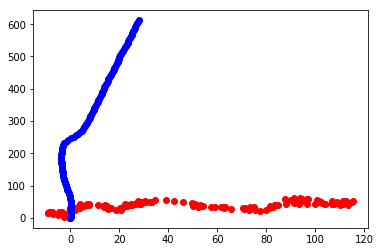

Count:656
()
()
Relative Depth: -48.460779242985154
Relative x: 90.8435566978691
Relative Original Depth: -613.2221656868093
Relative Original x: 28.0942295617942
Count:657
()
()
Relative Depth: -48.93961711221686
Relative x: 90.91555013643291
Relative Original Depth: -614.2127446177564
Relative Original x: 28.15784825509681
Count:658
()
()
Relative Depth: -49.20673504994597
Relative x: 90.17400364372963
Relative Original Depth: -615.2037709484521
Relative Original x: 28.23381371501561
Count:659
()
()
Relative Depth: -49.41179945434499
Relative x: 89.41890935245294
Relative Original Depth: -616.1917857355852
Relative Original x: 28.309861587850286
Count:660
()
()
Relative Depth: -49.58763087758113
Relative x: 88.54851867570062
Relative Original Depth: -617.1834144432476
Relative Original x: 28.362980353762616


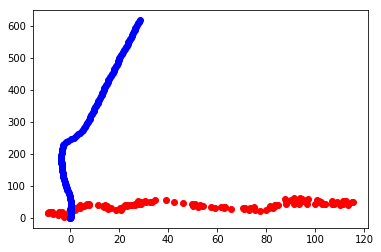

Count:661
()
()
Relative Depth: -48.74693917960458
Relative x: 88.01079292448269
Relative Original Depth: -618.1745358007197
Relative Original x: 28.379998334785537
Count:662
()
()
Relative Depth: -48.79257571982299
Relative x: 87.02389308413191
Relative Original Depth: -619.1628632155823
Relative Original x: 28.45201168313166
Count:663
()
()
Relative Depth: -48.79777309824575
Relative x: 86.08508227684605
Relative Original Depth: -620.1525053666853
Relative Original x: 28.4975501737917
Count:664
()
()
Relative Depth: -48.73043878208038
Relative x: 85.41345537511125
Relative Original Depth: -621.1431419338082
Relative Original x: 28.542928298453656
Count:665
()
()
Relative Depth: -48.4389972393494
Relative x: 85.07702738068298
Relative Original Depth: -622.1358620053039
Relative Original x: 28.585419544307282


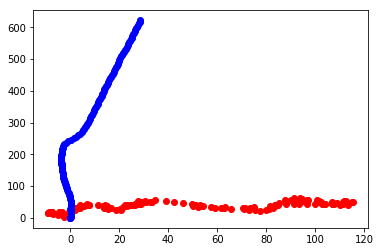

Count:666
()
()
Relative Depth: -47.97570025865489
Relative x: 84.9572985620298
Relative Original Depth: -623.1252148024694
Relative Original x: 28.679458023087903
Count:667
()
()
Relative Depth: -47.29771043068642
Relative x: 84.8804794351316
Relative Original Depth: -624.1128241963963
Relative Original x: 28.767844175663246
Count:668
()
()
Relative Depth: -46.500028370557274
Relative x: 84.91712186581452
Relative Original Depth: -625.100399507378
Relative Original x: 28.859095678560745
Count:669
()
()
Relative Depth: -46.01309999578216
Relative x: 85.47802369338446
Relative Original Depth: -626.0915751657398
Relative Original x: 28.907569202338305
Count:670
()
()
Relative Depth: -46.1403343942073
Relative x: 86.31990931627142
Relative Original Depth: -627.0824678266616
Relative Original x: 28.97217076297553


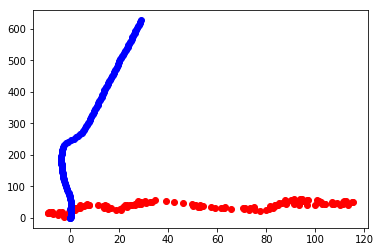

Count:671
()
()
Relative Depth: -46.05909624347884
Relative x: 87.24532487844566
Relative Original Depth: -628.0760184577136
Relative Original x: 28.993399850254928
Count:672
()
()
Relative Depth: -46.00515135335705
Relative x: 88.19915239378417
Relative Original Depth: -629.067035575988
Relative Original x: 29.01603348410951
Count:673
()
()
Relative Depth: -45.944251715748514
Relative x: 89.15079956672838
Relative Original Depth: -630.0582058258102
Relative Original x: 29.109420558210015
Count:674
()
()
Relative Depth: -46.43667638459003
Relative x: 88.9535394776629
Relative Original Depth: -631.0489373589816
Relative Original x: 29.166331683667376
Count:675
()
()
Relative Depth: -46.533941176161356
Relative x: 89.90908660773727
Relative Original Depth: -632.0380806146845
Relative Original x: 29.21204646631214


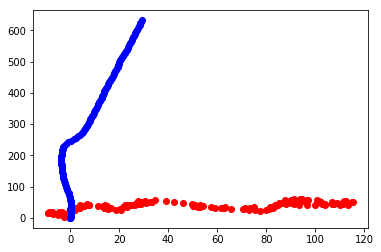

Count:676
()
()
Relative Depth: -46.81042506064504
Relative x: 90.78297224997884
Relative Original Depth: -633.0284655411089
Relative Original x: 29.24842397996364
Count:677
()
()
Relative Depth: -47.15761853125153
Relative x: 91.60926066819226
Relative Original Depth: -634.0197746654761
Relative Original x: 29.27311812099242
Count:678
()
()
Relative Depth: -47.53829585264806
Relative x: 92.47918166837948
Relative Original Depth: -635.0096786685044
Relative Original x: 29.333682495237394
Count:679
()
()
Relative Depth: -47.74005397803721
Relative x: 93.28652185318396
Relative Original Depth: -636.0019000361882
Relative Original x: 29.39176313068111
Count:680
()
()
Relative Depth: -47.34979357839156
Relative x: 93.78785635217392
Relative Original Depth: -636.9909616104417
Relative Original x: 29.475211472263897


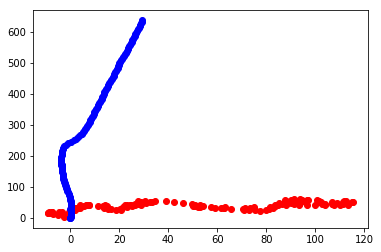

Count:681
()
()
Relative Depth: -46.66088530091692
Relative x: 94.16797100960814
Relative Original Depth: -637.982092326669
Relative Original x: 29.54736433901676
Count:682
()
()
Relative Depth: -46.059414086476586
Relative x: 94.75800786585557
Relative Original Depth: -638.9689104478969
Relative Original x: 29.630314082902064
Count:683
()
()
Relative Depth: -45.4193180037881
Relative x: 95.2294485488515
Relative Original Depth: -639.958661795841
Relative Original x: 29.66863099747979
Count:684
()
()
Relative Depth: -45.23128468254691
Relative x: 95.74682725143713
Relative Original Depth: -640.9486206233372
Relative Original x: 29.742978037476462
Count:685
()
()
Relative Depth: -45.46337698507218
Relative x: 96.36402881168337
Relative Original Depth: -641.9407716806741
Relative Original x: 29.743469167976116


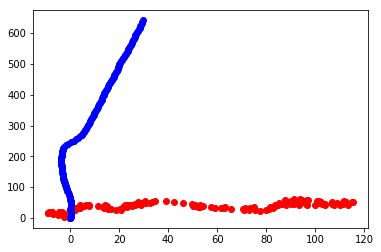

Count:686
()
()
Relative Depth: -45.68490753446598
Relative x: 96.9369997711205
Relative Original Depth: -642.9358367907595
Relative Original x: 29.73672325955401
Count:687
()
()
Relative Depth: -45.98025398854756
Relative x: 97.3970351685107
Relative Original Depth: -643.9282916649684
Relative Original x: 29.75898835157336
Count:688
()
()
Relative Depth: -46.03172146834413
Relative x: 97.59506143770847
Relative Original Depth: -644.9199530052841
Relative Original x: 29.781586046017843
Count:689
()
()
Relative Depth: -45.78558965634444
Relative x: 97.57056276973105
Relative Original Depth: -645.9120725799008
Relative Original x: 29.82826328621128
Count:690
()
()
Relative Depth: -45.20965488311378
Relative x: 97.7192774833785
Relative Original Depth: -646.9044057595862
Relative Original x: 29.87886056584647


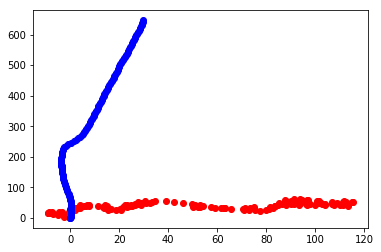

Count:691
()
()
Relative Depth: -44.397473140139724
Relative x: 98.06483115698086
Relative Original Depth: -647.8970502140869
Relative Original x: 29.91784714417899
Count:692
()
()
Relative Depth: -43.83875778607611
Relative x: 98.74979215074067
Relative Original Depth: -648.8888621608422
Relative Original x: 30.026123326450932
Count:693
()
()
Relative Depth: -43.52654643546679
Relative x: 99.5325076894751
Relative Original Depth: -649.8796647850729
Relative Original x: 30.076791708502363
Count:694
()
()
Relative Depth: -43.0847918741375
Relative x: 100.05233176821086
Relative Original Depth: -650.8662865212606
Relative Original x: 30.14201313725742
Count:695
()
()
Relative Depth: -42.65271094710062
Relative x: 100.39921759757887
Relative Original Depth: -651.8528820683648
Relative Original x: 30.223718888127312


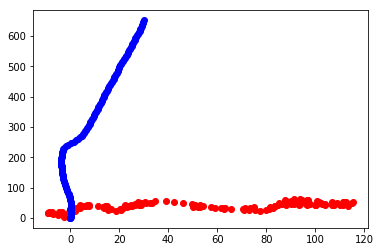

Count:696
()
()
Relative Depth: -42.28446923844717
Relative x: 100.85439224801522
Relative Original Depth: -652.8423284934726
Relative Original x: 30.294567914304984
Count:697
()
()
Relative Depth: -41.91501649209724
Relative x: 101.35574140459718
Relative Original Depth: -653.8138687571022
Relative Original x: 30.18814994579608
Count:698
()
()
Relative Depth: -41.39381914077868
Relative x: 101.77224684965991
Relative Original Depth: -654.8031413270123
Relative Original x: 30.233928886898077
Count:699
()
()
Relative Depth: -40.610162386870044
Relative x: 102.15072853233185
Relative Original Depth: -655.7976760222091
Relative Original x: 30.293717271168212
Count:700
()
()
Relative Depth: -39.821656217679624
Relative x: 102.52294272661923
Relative Original Depth: -656.7879376539152
Relative Original x: 30.304940630748202


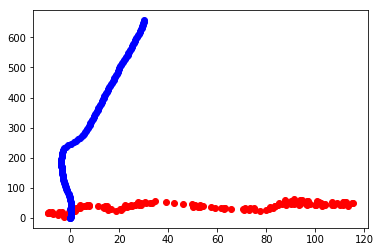

Count:701
()
()
Relative Depth: -39.24684891557383
Relative x: 102.96736089528302
Relative Original Depth: -657.780550752315
Relative Original x: 30.32337361959845
Count:702
()
()
Relative Depth: -38.81776030810377
Relative x: 103.49372903597842
Relative Original Depth: -658.7717056879136
Relative Original x: 30.330830403978783
Count:703
()
()
Relative Depth: -38.404456996191904
Relative x: 104.06706063761229
Relative Original Depth: -659.7672355379108
Relative Original x: 30.3593857431547
Count:704
()
()
Relative Depth: -38.18612536847233
Relative x: 104.80709345660753
Relative Original Depth: -660.7597814992894
Relative Original x: 30.398953412325696
Count:705
()
()
Relative Depth: -38.014574788368506
Relative x: 105.57739394423989
Relative Original Depth: -661.751119432658
Relative Original x: 30.410239264733804


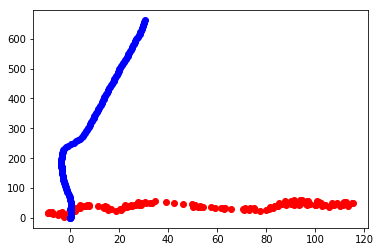

Count:706
()
()
Relative Depth: -37.353931461895144
Relative x: 105.63386525341565
Relative Original Depth: -662.7449060791837
Relative Original x: 30.457359136456166
Count:707
()
()
Relative Depth: -36.69426480119097
Relative x: 105.0068267429648
Relative Original Depth: -663.7332372986222
Relative Original x: 30.47492718678852
Count:708
()
()
Relative Depth: -35.94159745329735
Relative x: 104.45015971081426
Relative Original Depth: -664.7229226638751
Relative Original x: 30.49284540193187
Count:709
()
()
Relative Depth: -35.12759719363425
Relative x: 104.03634155938902
Relative Original Depth: -665.70499430814
Relative Original x: 30.438449190329326
Count:710
()
()
Relative Depth: -34.37628314492599
Relative x: 103.95418040966759
Relative Original Depth: -666.6904975828461
Relative Original x: 30.424853539820994


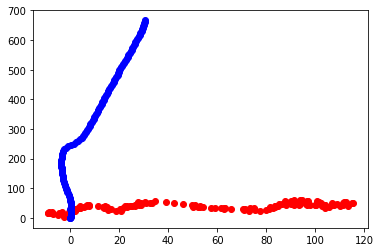

Count:711
()
()
Relative Depth: -33.80022107902875
Relative x: 104.14235534025707
Relative Original Depth: -667.6810416086729
Relative Original x: 30.469992347968688
Count:712
()
()
Relative Depth: -33.1929835984535
Relative x: 104.37855922960395
Relative Original Depth: -668.6720216781545
Relative Original x: 30.478384258560222
Count:713
()
()
Relative Depth: -32.757612702981
Relative x: 104.72227545770293
Relative Original Depth: -669.6635333057121
Relative Original x: 30.502083823549693
Count:714
()
()
Relative Depth: -31.86592944657923
Relative x: 105.14071186852874
Relative Original Depth: -670.6539904519401
Relative Original x: 30.490845900494406
Count:715
()
()
Relative Depth: -31.797604948783246
Relative x: 105.61098808621892
Relative Original Depth: -671.6500467081493
Relative Original x: 30.47253269725296


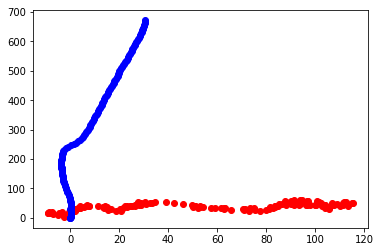

Count:716
()
()
Relative Depth: -32.177919335629575
Relative x: 106.38053104771024
Relative Original Depth: -672.6425440870329
Relative Original x: 30.45351618954177
Count:717
()
()
Relative Depth: -32.81890954803116
Relative x: 107.1088732975979
Relative Original Depth: -673.6328224601594
Relative Original x: 30.475110648485852
Count:718
()
()
Relative Depth: -33.40338014077526
Relative x: 107.64714971442085
Relative Original Depth: -674.624116251975
Relative Original x: 30.559202459080357
Count:719
()
()
Relative Depth: -33.841551309778936
Relative x: 108.11429550873777
Relative Original Depth: -675.6190853269002
Relative Original x: 30.64240827908747
Count:720
()
()
Relative Depth: -34.166481497139
Relative x: 107.170304685666
Relative Original Depth: -676.61227327905
Relative Original x: 30.697392626281513


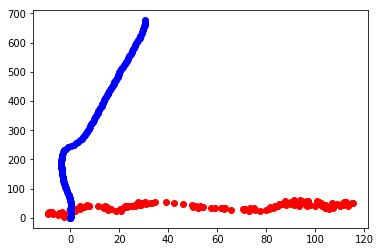

Count:721
()
()
Relative Depth: -34.57092752488189
Relative x: 107.66699272234025
Relative Original Depth: -677.6051736151609
Relative Original x: 30.722780223538166
Count:722
()
()
Relative Depth: -35.05529529489461
Relative x: 108.23029786409434
Relative Original Depth: -678.5972123636241
Relative Original x: 30.75029180844546
Count:723
()
()
Relative Depth: -35.53855477318272
Relative x: 108.81426410900521
Relative Original Depth: -679.574072064215
Relative Original x: 30.662786807665206
Count:724
()
()
Relative Depth: -36.13177060260736
Relative x: 108.47209112202279
Relative Original Depth: -680.5665035326264
Relative Original x: 30.654570628183702
Count:725
()
()
Relative Depth: -36.69376035987188
Relative x: 109.15287568053252
Relative Original Depth: -681.5625770004219
Relative Original x: 30.690094137483293


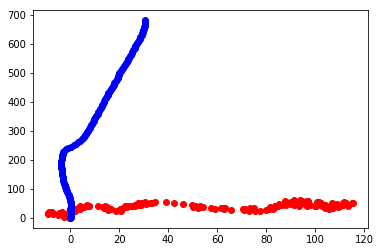

Count:726
()
()
Relative Depth: -36.65338170182311
Relative x: 108.15575434091159
Relative Original Depth: -682.5477128499466
Relative Original x: 30.63310725111079
Count:727
()
()
Relative Depth: -37.25468061177328
Relative x: 108.85915420098289
Relative Original Depth: -683.5394939564993
Relative Original x: 30.664819417493423
Count:728
()
()
Relative Depth: -37.865974401464236
Relative x: 109.35697653809491
Relative Original Depth: -684.5262765823585
Relative Original x: 30.702906860729318
Count:729
()
()
Relative Depth: -38.18283860390619
Relative x: 108.72123703915751
Relative Original Depth: -685.5215273470866
Relative Original x: 30.737305548981862
Count:730
()
()
Relative Depth: -38.53506196411897
Relative x: 109.13245365638781
Relative Original Depth: -686.5115599626278
Relative Original x: 30.778424190592677


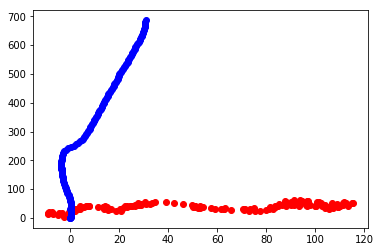

Count:731
()
()
Relative Depth: -38.908912016354236
Relative x: 109.84467598803926
Relative Original Depth: -687.4970951652848
Relative Original x: 30.9327847395565
Count:732
()
()
Relative Depth: -39.48470610477879
Relative x: 110.56336212480666
Relative Original Depth: -688.4828150937552
Relative Original x: 31.04308530884743
Count:733
()
()
Relative Depth: -40.08063261488069
Relative x: 111.29493873585541
Relative Original Depth: -689.4641153598482
Relative Original x: 31.02339632609094
Count:734
()
()
Relative Depth: -40.62459731137136
Relative x: 110.47450025383425
Relative Original Depth: -690.4546206730336
Relative Original x: 31.11332802890497
Count:735
()
()
Relative Depth: -41.470820897227995
Relative x: 110.98777527871601
Relative Original Depth: -691.4446197642449
Relative Original x: 31.080866499221607


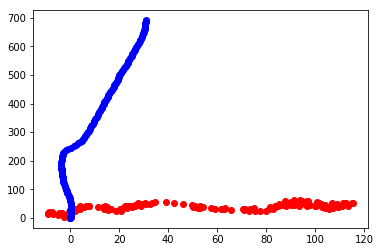

Count:736
()
()
Relative Depth: -42.38468931367457
Relative x: 111.33964977441148
Relative Original Depth: -692.435468535255
Relative Original x: 31.09171702441105
Count:737
()
()
Relative Depth: -43.26922440869575
Relative x: 111.68128660657221
Relative Original Depth: -693.4245322562357
Relative Original x: 31.21146826870132
Count:738
()
()
Relative Depth: -44.16174163396176
Relative x: 111.91263739827724
Relative Original Depth: -694.4127765710763
Relative Original x: 31.253926718082198
Count:739
()
()
Relative Depth: -45.074421661237245
Relative x: 112.07633619281283
Relative Original Depth: -695.4008760515709
Relative Original x: 31.3688840407133
Count:740
()
()
Relative Depth: -45.96285630084595
Relative x: 112.33661006998906
Relative Original Depth: -696.388734958553
Relative Original x: 31.432413961551912


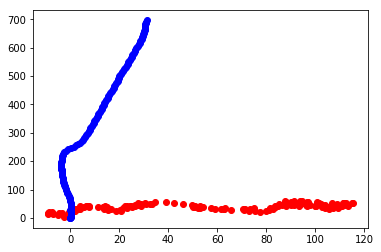

Count:741
()
()
Relative Depth: -46.84866756406778
Relative x: 112.4445217684199
Relative Original Depth: -697.3640200805569
Relative Original x: 31.556210974273615
Count:742
()
()
Relative Depth: -47.74661678366655
Relative x: 112.72874459672659
Relative Original Depth: -698.3505610297653
Relative Original x: 31.598439759989887
Count:743
()
()
Relative Depth: -48.2459253236947
Relative x: 112.91336520252418
Relative Original Depth: -699.3406624745003
Relative Original x: 31.709089352406124
Count:744
()
()
Relative Depth: -48.25609511134687
Relative x: 112.95738125372598
Relative Original Depth: -700.3173224210542
Relative Original x: 31.876549686956068
Count:745
()
()
Relative Depth: -48.18557064716804
Relative x: 113.1694752953083
Relative Original Depth: -701.298609972003
Relative Original x: 31.97794829356282


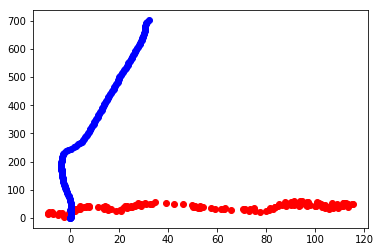

Count:746
()
()
Relative Depth: -48.843094657505944
Relative x: 113.74405281165637
Relative Original Depth: -702.2756954197428
Relative Original x: 32.134809413270276
Count:747
()
()
Relative Depth: -48.713141756375485
Relative x: 114.2049873010025
Relative Original Depth: -703.2570770785101
Relative Original x: 32.30689285399092
Count:748
()
()
Relative Depth: -48.41511426946991
Relative x: 115.09722417789155
Relative Original Depth: -704.2244827386659
Relative Original x: 32.56011288627023
Count:749
()
()
Relative Depth: -48.090218087802
Relative x: 116.03888613857859
Relative Original Depth: -705.200463790688
Relative Original x: 32.77317364669852
Count:750
()
()
Relative Depth: -47.93518128603414
Relative x: 117.02461693668641
Relative Original Depth: -706.1973839485753
Relative Original x: 32.84632295021859


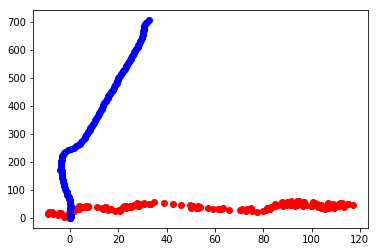

Count:751
()
()
Relative Depth: -47.72680456664399
Relative x: 118.00211260873873
Relative Original Depth: -707.1700320326382
Relative Original x: 33.07173760437705
Count:752
()
()
Relative Depth: -47.197105925891634
Relative x: 118.56118702733858
Relative Original Depth: -708.1420713551278
Relative Original x: 33.27973210392535
Count:753
()
()
Relative Depth: -47.40001673730196
Relative x: 118.8892901372779
Relative Original Depth: -709.101552304447
Relative Original x: 33.54504712680505
Count:754
()
()
Relative Depth: -47.04058949564467
Relative x: 119.82037061000317
Relative Original Depth: -710.0693893920875
Relative Original x: 33.78714573989259
Count:755
()
()
Relative Depth: -46.83908527566667
Relative x: 120.77953507076303
Relative Original Depth: -711.0401431691548
Relative Original x: 34.02685278236823


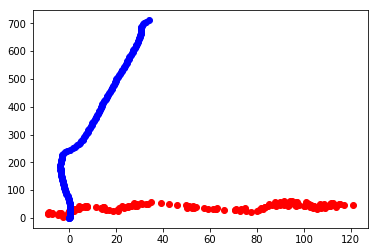

Count:756
()
()
Relative Depth: -47.74891672125265
Relative x: 120.46169385128164
Relative Original Depth: -711.972936838501
Relative Original x: 34.37186767750184
Count:757
()
()
Relative Depth: -47.6441637180081
Relative x: 121.40280011599668
Relative Original Depth: -712.9130084225308
Relative Original x: 34.703958170361474
Count:758
()
()
Relative Depth: -47.86746133389163
Relative x: 122.35784821048252
Relative Original Depth: -713.86323725304
Relative Original x: 35.00027185568779
Count:759
()
()
Relative Depth: -47.32828045400118
Relative x: 122.1334623739414
Relative Original Depth: -714.7810461918428
Relative Original x: 35.39497830459138
Count:760
()
()
Relative Depth: -47.534739550800275
Relative x: 122.57660915361637
Relative Original Depth: -715.7121788273724
Relative Original x: 35.757242919467714


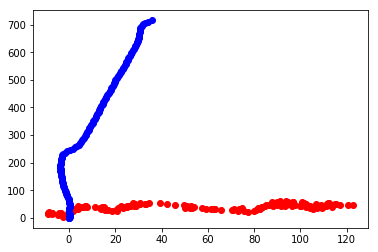

Count:761
()
()
Relative Depth: -47.282471969419554
Relative x: 121.72401811350268
Relative Original Depth: -716.6257345999115
Relative Original x: 36.1609672474228
Count:762
()
()
Relative Depth: -46.99272900497484
Relative x: 121.82953602455058
Relative Original Depth: -717.5465582181785
Relative Original x: 36.52869658210822
Count:763
()
()
Relative Depth: -46.32065510413057
Relative x: 121.99354356179308
Relative Original Depth: -718.4534531648592
Relative Original x: 36.94321648544586
Count:764
()
()
Relative Depth: -45.72637742226733
Relative x: 122.61989126110879
Relative Original Depth: -719.3363710202957
Relative Original x: 37.40926290026108
Count:765
()
()
Relative Depth: -45.43993974024021
Relative x: 123.5297452137343
Relative Original Depth: -720.2254139362741
Relative Original x: 37.859355528292795


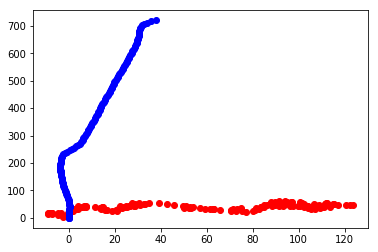

Count:766
()
()
Relative Depth: -45.228027828590434
Relative x: 124.43099195028675
Relative Original Depth: -721.1169247640689
Relative Original x: 38.30825875921822
Count:767
()
()
Relative Depth: -44.41135513239538
Relative x: 124.920715501129
Relative Original Depth: -721.9546655728524
Relative Original x: 38.848013647955476
Count:768
()
()
Relative Depth: -43.43904694038239
Relative x: 124.96680699549981
Relative Original Depth: -722.7778260228926
Relative Original x: 39.412858819268074
Count:769
()
()
Relative Depth: -42.53603254160783
Relative x: 125.37940269777118
Relative Original Depth: -723.6148606931038
Relative Original x: 39.95518910418737
Count:770
()
()
Relative Depth: -43.496508426419226
Relative x: 125.14341837945473
Relative Original Depth: -724.4301531973979
Relative Original x: 40.52525227835989


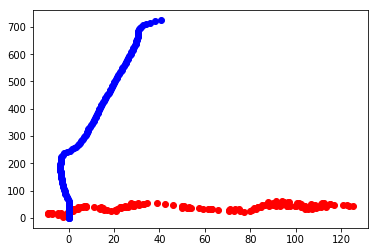

Count:771
()
()
Relative Depth: -42.90250728580542
Relative x: 125.83456935436485
Relative Original Depth: -725.207293161505
Relative Original x: 41.147821855328544
Count:772
()
()
Relative Depth: -42.22741216591984
Relative x: 125.87037806701146
Relative Original Depth: -725.9712038410173
Relative Original x: 41.79109698489958
Count:773
()
()
Relative Depth: -41.84717354340974
Relative x: 126.52364612818256
Relative Original Depth: -726.7073808840485
Relative Original x: 42.46419688432841
Count:774
()
()
Relative Depth: -41.44696757776941
Relative x: 127.01419651413703
Relative Original Depth: -727.4170800396773
Relative Original x: 43.167100385904504
Count:775
()
()
Relative Depth: -41.37022804619889
Relative x: 127.39258544017942
Relative Original Depth: -728.1327054590968
Relative Original x: 43.86380520144514


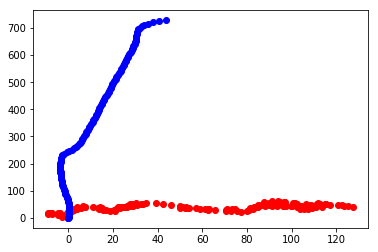

Count:776
()
()
Relative Depth: -41.488681753816394
Relative x: 127.76852100360239
Relative Original Depth: -728.8254409019345
Relative Original x: 44.58446414760623
Count:777
()
()
Relative Depth: -41.085115798415345
Relative x: 127.87444016127345
Relative Original Depth: -729.5136075809949
Relative Original x: 45.30916697398333
Count:778
()
()
Relative Depth: -40.6719565325927
Relative x: 127.63368064049726
Relative Original Depth: -730.1538558671946
Relative Original x: 46.0772262688683
Count:779
()
()
Relative Depth: -40.36580366833064
Relative x: 127.37104548517426
Relative Original Depth: -730.7699463296468
Relative Original x: 46.86188911011042
Count:780
()
()
Relative Depth: -40.00775333594827
Relative x: 127.04059483113028
Relative Original Depth: -731.3822941955725
Relative Original x: 47.650253388435296


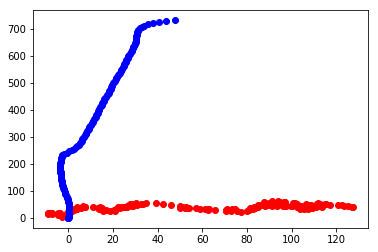

Count:781
()
()
Relative Depth: -39.54764199590357
Relative x: 126.57891053383882
Relative Original Depth: -731.9637379754837
Relative Original x: 48.46253067849661
Count:782
()
()
Relative Depth: -39.110677867521176
Relative x: 126.04162960765176
Relative Original Depth: -732.5322477653234
Relative Original x: 49.283976954174626
Count:783
()
()
Relative Depth: -38.865764292795575
Relative x: 125.60187942951664
Relative Original Depth: -733.0795740755398
Relative Original x: 50.119821025769596
Count:784
()
()
Relative Depth: -39.36876589410317
Relative x: 125.35023682596791
Relative Original Depth: -733.5939448818679
Relative Original x: 50.977338595836656
Count:785
()
()
Relative Depth: -40.19129118164817
Relative x: 125.04740443512546
Relative Original Depth: -734.0724556833577
Relative Original x: 51.855414194285295


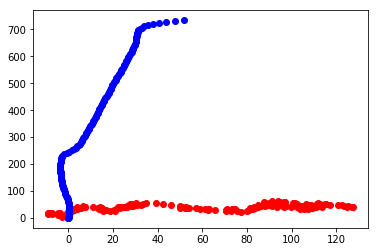

Count:786
()
()
Relative Depth: -40.77258443621102
Relative x: 124.58008249554372
Relative Original Depth: -734.5864890222344
Relative Original x: 52.711706222619775
Count:787
()
()
Relative Depth: -41.210934784650625
Relative x: 124.15221033869844
Relative Original Depth: -735.0783381125444
Relative Original x: 53.58218914845871
Count:788
()
()
Relative Depth: -41.646915335231746
Relative x: 124.71874772059499
Relative Original Depth: -735.5650617013048
Relative Original x: 54.45564874611426
Count:789
()
()
Relative Depth: -42.23770813413964
Relative x: 124.22154818522212
Relative Original Depth: -735.9475690939702
Relative Original x: 55.379492186775565
Count:790
()
()
Relative Depth: -42.92810965736623
Relative x: 123.91771617606891
Relative Original Depth: -736.380274789495
Relative Original x: 56.280321890520696


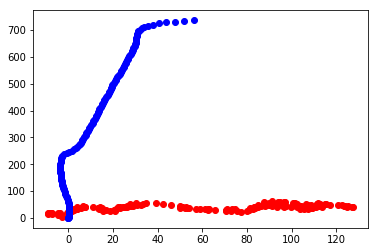

Count:791
()
()
Relative Depth: -43.71662686318376
Relative x: 124.08980689179926
Relative Original Depth: -736.7838345136909
Relative Original x: 57.194607757372935
Count:792
()
()
Relative Depth: -44.51899245355285
Relative x: 124.50037365898305
Relative Original Depth: -737.175394029186
Relative Original x: 58.11471950099686
Count:793
()
()
Relative Depth: -45.32210538818111
Relative x: 124.97672591512217
Relative Original Depth: -737.5586401805033
Relative Original x: 59.03732334255294
Count:794
()
()
Relative Depth: -44.71800764876581
Relative x: 125.45540239837547
Relative Original Depth: -737.9034827945045
Relative Original x: 59.97583116979038
Count:795
()
()
Relative Depth: -44.16030828414484
Relative x: 124.95655117586625
Relative Original Depth: -738.2442804316773
Relative Original x: 60.91596678459398


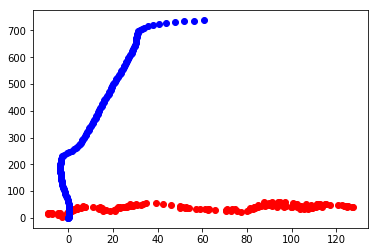

Count:796
()
()
Relative Depth: -44.9297692134641
Relative x: 125.39313665669538
Relative Original Depth: -738.5811027338901
Relative Original x: 61.85679210339021
Count:797
()
()
Relative Depth: -45.73326128683724
Relative x: 125.49713917240337
Relative Original Depth: -738.8184469636788
Relative Original x: 62.82436554697498
Count:798
()
()
Relative Depth: -46.358204086675215
Relative x: 125.1892171545843
Relative Original Depth: -739.146688776991
Relative Original x: 63.76895879194116
Count:799
()
()
Relative Depth: -46.83371852065756
Relative x: 124.86247990513168
Relative Original Depth: -739.4158641813209
Relative Original x: 64.73177384503195
Count:800
()
()
Relative Depth: -47.155807526448655
Relative x: 124.52476929111104
Relative Original Depth: -739.6698970412295
Relative Original x: 65.69760483504055


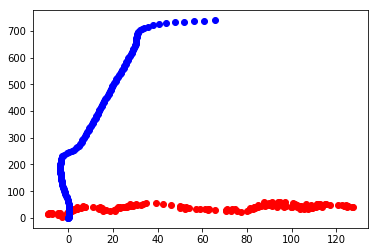

Count:801
()
()
Relative Depth: -47.44709872054239
Relative x: 124.05202040200555
Relative Original Depth: -739.9163610307721
Relative Original x: 66.66669282209254
Count:802
()
()
Relative Depth: -47.771479098159276
Relative x: 123.45885468353936
Relative Original Depth: -740.1669497227257
Relative Original x: 67.63433380248695
Count:803
()
()
Relative Depth: -48.15875837359841
Relative x: 122.79512452722949
Relative Original Depth: -740.395750329797
Relative Original x: 68.60701012551615
Count:804
()
()
Relative Depth: -48.39969712224158
Relative x: 122.03798691811151
Relative Original Depth: -740.5626211203305
Relative Original x: 69.59297854621316
Count:805
()
()
Relative Depth: -49.02963121848847
Relative x: 121.38727218046577
Relative Original Depth: -740.7672775783309
Relative Original x: 70.56986047930346


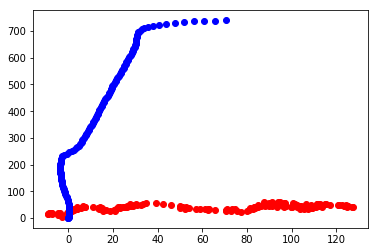

Count:806
()
()
Relative Depth: -49.96190835994724
Relative x: 121.04091339686146
Relative Original Depth: -740.9711169174689
Relative Original x: 71.5484979889915
Count:807
()
()
Relative Depth: -50.87447018060884
Relative x: 120.6695956663969
Relative Original Depth: -741.1410151785035
Relative Original x: 72.53375323441435
Count:808
()
()
Relative Depth: -49.92050825688908
Relative x: 120.37004127245355
Relative Original Depth: -741.3051602953491
Relative Original x: 73.51950399206166
Count:809
()
()
Relative Depth: -50.652473892745824
Relative x: 119.74878556804148
Relative Original Depth: -741.4681258453681
Relative Original x: 74.50610529477542
Count:810
()
()
Relative Depth: -51.22401826657293
Relative x: 118.96935990713013
Relative Original Depth: -741.6086915660493
Relative Original x: 75.49607387715801


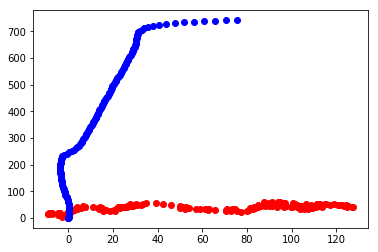

Count:811
()
()
Relative Depth: -51.90500038035177
Relative x: 118.27748842496148
Relative Original Depth: -741.7374925198559
Relative Original x: 76.48712419481835
Count:812
()
()
Relative Depth: -52.696879774963826
Relative x: 117.70848081560784
Relative Original Depth: -741.8715944547736
Relative Original x: 77.47678391806642
Count:813
()
()
Relative Depth: -53.54452258362533
Relative x: 117.20636144643669
Relative Original Depth: -741.9483631121732
Relative Original x: 78.47265694042999
Count:814
()
()
Relative Depth: -54.42798930716497
Relative x: 116.76748466506537
Relative Original Depth: -742.0011758596398
Relative Original x: 79.46924215185057
Count:815
()
()
Relative Depth: -55.349402932666315
Relative x: 116.4135071213576
Relative Original Depth: -742.0970919297321
Relative Original x: 80.46386793482196


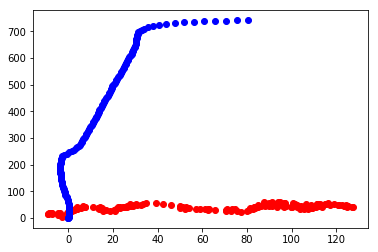

Count:816
()
()
Relative Depth: -56.31020583317521
Relative x: 116.16332791828584
Relative Original Depth: -742.2103267338141
Relative Original x: 81.45608104503295
Count:817
()
()
Relative Depth: -56.91563587446116
Relative x: 115.44506923933176
Relative Original Depth: -742.2642055869004
Relative Original x: 82.45277828745931
Count:818
()
()
Relative Depth: -57.008551023967286
Relative x: 114.52691854767912
Relative Original Depth: -742.3855239034478
Relative Original x: 83.44539123982923
Count:819
()
()
Relative Depth: -56.78569287050094
Relative x: 113.55232164127492
Relative Original Depth: -742.4780971624286
Relative Original x: 84.44096672055127
Count:820
()
()
Relative Depth: -56.43367620790934
Relative x: 112.63479594916122
Relative Original Depth: -742.5800269819241
Relative Original x: 85.43534355373522


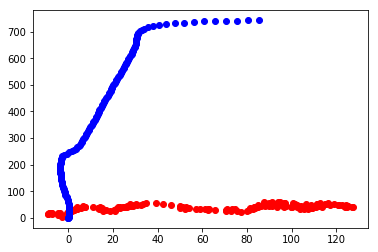

Count:821
()
()
Relative Depth: -56.16927849840825
Relative x: 111.67429369442131
Relative Original Depth: -742.6634233337451
Relative Original x: 86.43132778378795
Count:822
()
()
Relative Depth: -55.63094590067551
Relative x: 112.41189256871122
Relative Original Depth: -742.7494294784112
Relative Original x: 87.42660176356226
Count:823
()
()
Relative Depth: -55.25653941231652
Relative x: 111.49401603994934
Relative Original Depth: -742.8210902092242
Relative Original x: 88.42305283058234
Count:824
()
()
Relative Depth: -54.79558273134059
Relative x: 110.61495602892907
Relative Original Depth: -742.8683002411756
Relative Original x: 89.42050047543992
Count:825
()
()
Relative Depth: -54.4383441459064
Relative x: 109.68347192309474
Relative Original Depth: -742.9302569983345
Relative Original x: 90.41791487645358


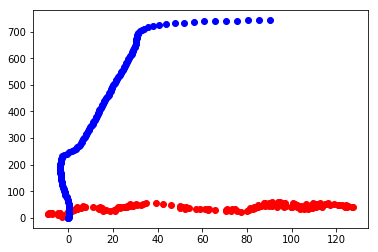

Count:826
()
()
Relative Depth: -54.26249271474214
Relative x: 108.70962385294352
Relative Original Depth: -743.0019537258889
Relative Original x: 91.41412140082885
Count:827
()
()
Relative Depth: -55.17271332767812
Relative x: 108.48244851026615
Relative Original Depth: -743.0751296705467
Relative Original x: 92.41099450849308
Count:828
()
()
Relative Depth: -55.15085824412088
Relative x: 107.52891707302034
Relative Original Depth: -743.116567038393
Relative Original x: 93.40923362152715
Count:829
()
()
Relative Depth: -55.2836554225871
Relative x: 106.56560891372106
Relative Original Depth: -743.1954756407134
Relative Original x: 94.40506700081208
Count:830
()
()
Relative Depth: -55.56361936043962
Relative x: 105.61223459807961
Relative Original Depth: -743.2524178896317
Relative Original x: 95.4025303887328


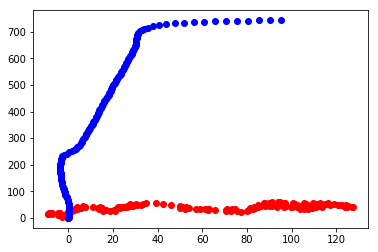

Count:831
()
()
Relative Depth: -55.90236297415678
Relative x: 104.6740484212505
Relative Original Depth: -743.2860135486334
Relative Original x: 96.40096415963453
Count:832
()
()
Relative Depth: -56.691373376578966
Relative x: 104.11352138995964
Relative Original Depth: -743.334435286211
Relative Original x: 97.39832768511252
Count:833
()
()
Relative Depth: -56.86307710649608
Relative x: 103.47982482299761
Relative Original Depth: -743.3396791093255
Relative Original x: 98.39719942064968
Count:834
()
()
Relative Depth: -57.83507977746634
Relative x: 103.49314859230681
Relative Original Depth: -743.3659305253875
Relative Original x: 99.39508380716224
Count:835
()
()
Relative Depth: -58.75028007347409
Relative x: 103.89246927936306
Relative Original Depth: -743.37683797429
Relative Original x: 100.39352383374911


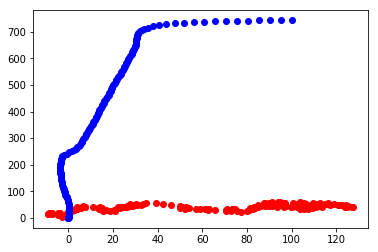

Count:836
()
()
Relative Depth: -59.22775735947418
Relative x: 104.7614354743029
Relative Original Depth: -743.4069981740001
Relative Original x: 101.39180127814083
Count:837
()
()
Relative Depth: -59.963492320516394
Relative x: 104.2811486730741
Relative Original Depth: -743.5173767947182
Relative Original x: 102.38467892588767
Count:838
()
()
Relative Depth: -60.46346537480027
Relative x: 103.5178370012852
Relative Original Depth: -743.5476128566112
Relative Original x: 103.38334511388497
Count:839
()
()
Relative Depth: -59.669620155519794
Relative x: 103.03622879967135
Relative Original Depth: -743.5865450352424
Relative Original x: 104.38202385674397
Count:840
()
()
Relative Depth: -58.733497916744106
Relative x: 102.88483910703104
Relative Original Depth: -743.6153536469683
Relative Original x: 105.38060085108722


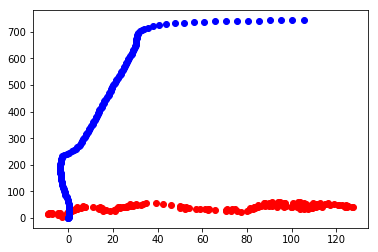

Count:841
()
()
Relative Depth: -57.79486081432252
Relative x: 102.77595361852953
Relative Original Depth: -743.6375426043327
Relative Original x: 106.37941737606367
Count:842
()
()
Relative Depth: -56.863629330176586
Relative x: 102.75992571837493
Relative Original Depth: -743.6867861784123
Relative Original x: 107.37772368582306
Count:843
()
()
Relative Depth: -55.94637616473946
Relative x: 102.79315183879196
Relative Original Depth: -743.6801958048553
Relative Original x: 108.37614304698249
Count:844
()
()
Relative Depth: -55.033680919817094
Relative x: 102.58046870867507
Relative Original Depth: -743.6834611632023
Relative Original x: 109.37583061480566
Count:845
()
()
Relative Depth: -54.16371373808505
Relative x: 102.33718322374683
Relative Original Depth: -743.7103830814887
Relative Original x: 110.37516350724847


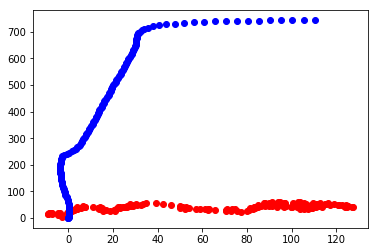

Count:846
()
()
Relative Depth: -53.33680519712224
Relative x: 102.22132276646967
Relative Original Depth: -743.7573015537629
Relative Original x: 111.37293985578604
Count:847
()
()
Relative Depth: -52.51899792666109
Relative x: 102.06369272522619
Relative Original Depth: -743.8183758864683
Relative Original x: 112.37093801885759
Count:848
()
()
Relative Depth: -51.681610068333036
Relative x: 101.80551131383791
Relative Original Depth: -743.8383118861497
Relative Original x: 113.37065543958846
Count:849
()
()
Relative Depth: -50.87584858222837
Relative x: 101.41397779120894
Relative Original Depth: -743.8537494016875
Relative Original x: 114.36936578754295
Count:850
()
()
Relative Depth: -50.38940127685353
Relative x: 101.92143062241978
Relative Original Depth: -743.8514760094811
Relative Original x: 115.36836271014826


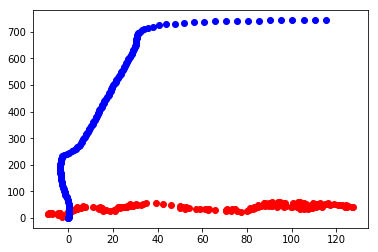

Count:851
()
()
Relative Depth: -49.93001931851934
Relative x: 101.24452462366175
Relative Original Depth: -743.8529809492827
Relative Original x: 116.36830534994257
Count:852
()
()
Relative Depth: -49.823631503466224
Relative x: 100.53410820030761
Relative Original Depth: -743.8881456787803
Relative Original x: 117.3672828593425
Count:853
()
()
Relative Depth: -49.844082305937704
Relative x: 100.02882995756339
Relative Original Depth: -743.9285006246289
Relative Original x: 118.3661083469488
Count:854
()
()
Relative Depth: -50.00232815758732
Relative x: 99.7915303116116
Relative Original Depth: -744.0009383029472
Relative Original x: 119.36346698288709
Count:855
()
()
Relative Depth: -50.053538426607375
Relative x: 99.73306543890072
Relative Original Depth: -743.9619634275151
Relative Original x: 120.36105168125842


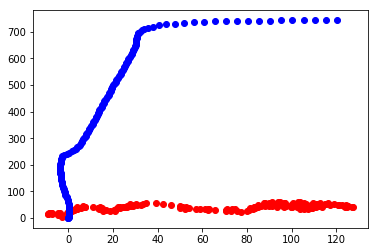

Count:856
()
()
Relative Depth: -50.138967414007034
Relative x: 99.68572167095977
Relative Original Depth: -743.9941225445091
Relative Original x: 121.3596668284454
Count:857
()
()
Relative Depth: -50.189285904143
Relative x: 99.74887136355895
Relative Original Depth: -744.0260253217878
Relative Original x: 122.35814796074655
Count:858
()
()
Relative Depth: -50.55712340450665
Relative x: 98.9067299856709
Relative Original Depth: -744.0332264121793
Relative Original x: 123.35634351847743
Count:859
()
()
Relative Depth: -50.59985191592506
Relative x: 99.14753564763942
Relative Original Depth: -744.056606320847
Relative Original x: 124.35482623946483
Count:860
()
()
Relative Depth: -50.700412292513974
Relative x: 99.36629836645918
Relative Original Depth: -744.1096051400489
Relative Original x: 125.35297815642042


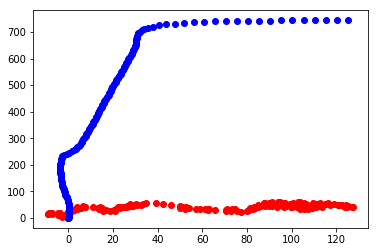

Count:861
()
()
Relative Depth: -50.85996918494757
Relative x: 99.56931165823657
Relative Original Depth: -744.1414337863856
Relative Original x: 126.35191888893223
Count:862
()
()
Relative Depth: -50.750092218512314
Relative x: 100.01796788474533
Relative Original Depth: -744.1960562286101
Relative Original x: 127.34927914717039
Count:863
()
()
Relative Depth: -50.28999323196366
Relative x: 100.72760824295973
Relative Original Depth: -744.2252180711432
Relative Original x: 128.34842812241533
Count:864
()
()
Relative Depth: -49.94433977907783
Relative x: 101.57986156299926
Relative Original Depth: -744.2262720487137
Relative Original x: 129.3476756211043
Count:865
()
()
Relative Depth: -49.80535929265554
Relative x: 102.49524846889913
Relative Original Depth: -744.2259887498903
Relative Original x: 130.34672238585966


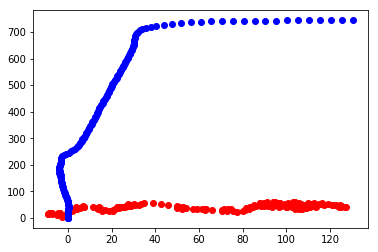

Count:866
()
()
Relative Depth: -49.80372141072515
Relative x: 103.47610220567726
Relative Original Depth: -744.2108728690941
Relative Original x: 131.34591624827038
Count:867
()
()
Relative Depth: -49.9761175930414
Relative x: 104.14203440457126
Relative Original Depth: -744.2052309007404
Relative Original x: 132.34533768820697
Count:868
()
()
Relative Depth: -50.130172402218946
Relative x: 104.1267151222307
Relative Original Depth: -744.2360618141571
Relative Original x: 133.34485972239284
Count:869
()
()
Relative Depth: -50.982793788284646
Relative x: 104.21409910641053
Relative Original Depth: -744.26162824405
Relative Original x: 134.34412591731774
Count:870
()
()
Relative Depth: -51.265859877975345
Relative x: 104.38942607772097
Relative Original Depth: -744.2627848022933
Relative Original x: 135.34312831191826


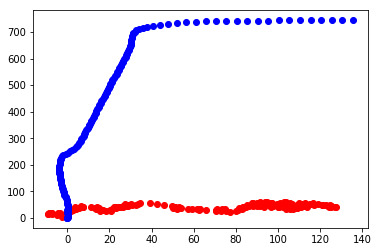

Count:871
()
()
Relative Depth: -51.36768960430742
Relative x: 104.06965069337906
Relative Original Depth: -744.2906856317936
Relative Original x: 136.34195514924363
Count:872
()
()
Relative Depth: -51.490480062789906
Relative x: 104.0658666182244
Relative Original Depth: -744.3524642756911
Relative Original x: 137.33947281488213
Count:873
()
()
Relative Depth: -51.3790669279707
Relative x: 103.55559571116358
Relative Original Depth: -744.3812451223545
Relative Original x: 138.33762839056743
Count:874
()
()
Relative Depth: -51.16747288760525
Relative x: 102.89203080904339
Relative Original Depth: -744.3960195960523
Relative Original x: 139.3357884917888
Count:875
()
()
Relative Depth: -50.8987609577242
Relative x: 102.07233795028819
Relative Original Depth: -744.4224035766432
Relative Original x: 140.3342252251885


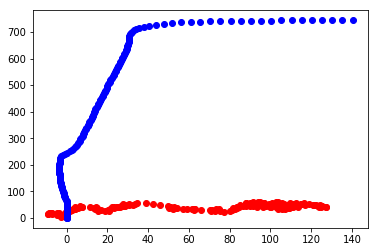

Count:876
()
()
Relative Depth: -50.72100524084019
Relative x: 101.26996518634752
Relative Original Depth: -744.4337904681158
Relative Original x: 141.3324882388086
Count:877
()
()
Relative Depth: -50.665901714112636
Relative x: 100.75265303548692
Relative Original Depth: -744.4607007867803
Relative Original x: 142.33075180719283
Count:878
()
()
Relative Depth: -50.62838467395855
Relative x: 100.20750878659982
Relative Original Depth: -744.5023511463221
Relative Original x: 143.32968653895603
Count:879
()
()
Relative Depth: -50.41234827094796
Relative x: 99.38109195162605
Relative Original Depth: -744.5394444246397
Relative Original x: 144.32751702074813
Count:880
()
()
Relative Depth: -49.79794243105447
Relative x: 98.8668955784401
Relative Original Depth: -744.5936366087329
Relative Original x: 145.32572983426851


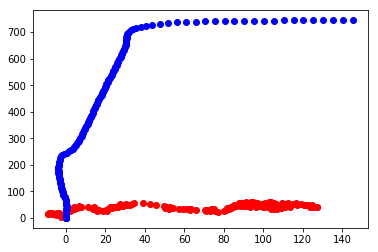

Count:881
()
()
Relative Depth: -49.109458698213594
Relative x: 98.84129128538257
Relative Original Depth: -744.6540294361431
Relative Original x: 146.32270088562657
Count:882
()
()
Relative Depth: -48.490504709711665
Relative x: 99.02831959018184
Relative Original Depth: -744.6767554887343
Relative Original x: 147.3206941884883
Count:883
()
()
Relative Depth: -47.98177319881651
Relative x: 99.36686775378362
Relative Original Depth: -744.7003136380386
Relative Original x: 148.31987344708912
Count:884
()
()
Relative Depth: -47.263295163996176
Relative x: 99.52250849192892
Relative Original Depth: -744.7556515879002
Relative Original x: 149.31722665776388
Count:885
()
()
Relative Depth: -46.35195387596814
Relative x: 99.42034303426155
Relative Original Depth: -744.7546918408018
Relative Original x: 150.3160256447582


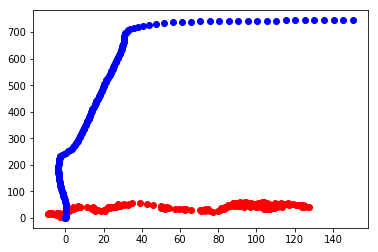

Count:886
()
()
Relative Depth: -45.466069150000855
Relative x: 99.43531546402379
Relative Original Depth: -744.788173421196
Relative Original x: 151.31369839735535
Count:887
()
()
Relative Depth: -44.96740630237566
Relative x: 99.85318362346267
Relative Original Depth: -744.8315279589519
Relative Original x: 152.3114072694832
Count:888
()
()
Relative Depth: -44.77290427931127
Relative x: 100.40049952325265
Relative Original Depth: -744.8863289590919
Relative Original x: 153.30891859519912
Count:889
()
()
Relative Depth: -44.51433419620887
Relative x: 100.67705994259886
Relative Original Depth: -744.9095220415269
Relative Original x: 154.30769688317324
Count:890
()
()
Relative Depth: -43.801900953511506
Relative x: 100.36122326382748
Relative Original Depth: -744.9731174344914
Relative Original x: 155.30543880918012


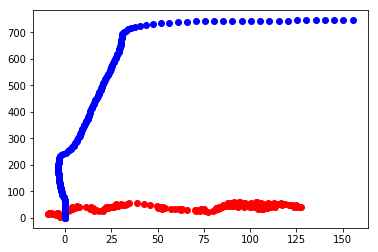

Count:891
()
()
Relative Depth: -42.96146992450198
Relative x: 99.82068317707292
Relative Original Depth: -745.0394305480604
Relative Original x: 156.30246696287807
Count:892
()
()
Relative Depth: -42.12848762976376
Relative x: 99.28293215379375
Relative Original Depth: -745.058617828815
Relative Original x: 157.29997132718592
Count:893
()
()
Relative Depth: -41.45695346828392
Relative x: 98.54291145199572
Relative Original Depth: -745.0832476952452
Relative Original x: 158.29881338973863
Count:894
()
()
Relative Depth: -41.010410886961076
Relative x: 97.65861857990835
Relative Original Depth: -745.1489218509903
Relative Original x: 159.29552344010943
Count:895
()
()
Relative Depth: -40.37655763405537
Relative x: 96.90373146013025
Relative Original Depth: -745.1573558819501
Relative Original x: 160.29388349067696


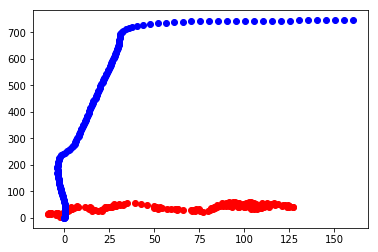

Count:896
()
()
Relative Depth: -39.72352243571786
Relative x: 96.35545792409796
Relative Original Depth: -745.1772064614288
Relative Original x: 161.29126772450235
Count:897
()
()
Relative Depth: -39.13691744379622
Relative x: 95.65229093493964
Relative Original Depth: -745.2129445229323
Relative Original x: 162.29014146415892
Count:898
()
()
Relative Depth: -38.64856997387944
Relative x: 94.78379778631496
Relative Original Depth: -745.2527967995921
Relative Original x: 163.28825814454612
Count:899
()
()
Relative Depth: -38.2600917816211
Relative x: 93.91219606797084
Relative Original Depth: -745.30641621175
Relative Original x: 164.28587424636396
Count:900
()
()
Relative Depth: -38.04367217475417
Relative x: 92.95283305742404
Relative Original Depth: -745.3930009440533
Relative Original x: 165.2821119030822


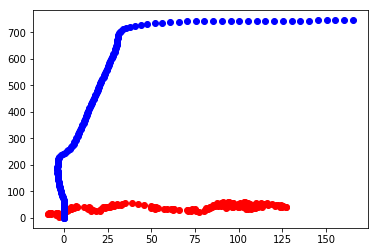

Count:901
()
()
Relative Depth: -37.97030894744867
Relative x: 92.10325850132224
Relative Original Depth: -745.4096589707073
Relative Original x: 166.28137991349388
Count:902
()
()
Relative Depth: -37.76269304695305
Relative x: 91.43593806866323
Relative Original Depth: -745.4342068599234
Relative Original x: 167.2805708833477
Count:903
()
()
Relative Depth: -37.50262076393742
Relative x: 91.17013934932976
Relative Original Depth: -745.4835089757947
Relative Original x: 168.27901210174977
Count:904
()
()
Relative Depth: -37.23086519616299
Relative x: 91.07117532301125
Relative Original Depth: -745.5368914960007
Relative Original x: 169.27581196191915
Count:905
()
()
Relative Depth: -36.99969294207936
Relative x: 90.95591172386025
Relative Original Depth: -745.5897860483112
Relative Original x: 170.2734549832153


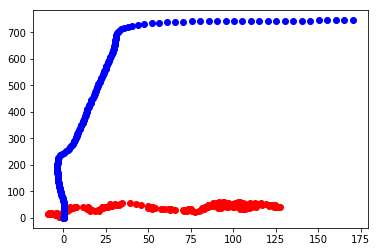

Count:906
()
()
Relative Depth: -36.84816984746982
Relative x: 90.70685219473273
Relative Original Depth: -745.6346831937688
Relative Original x: 171.27153607724867
Count:907
()
()
Relative Depth: -36.66845743434243
Relative x: 90.31212678980461
Relative Original Depth: -745.694564326756
Relative Original x: 172.2690819472959
Count:908
()
()
Relative Depth: -36.537882252395356
Relative x: 89.61842027066291
Relative Original Depth: -745.7331604866249
Relative Original x: 173.2671903932101
Count:909
()
()
Relative Depth: -36.39738935349851
Relative x: 88.82215348788853
Relative Original Depth: -745.7514921917193
Relative Original x: 174.26616548316832
Count:910
()
()
Relative Depth: -36.10293587579267
Relative x: 88.06441545843359
Relative Original Depth: -745.8204914519927
Relative Original x: 175.2636721658708


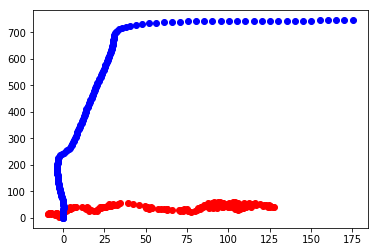

Count:911
()
()
Relative Depth: -35.70966864316866
Relative x: 87.48919198976299
Relative Original Depth: -745.8554782032267
Relative Original x: 176.26254933433526
Count:912
()
()
Relative Depth: -35.32398456780259
Relative x: 87.38957154584311
Relative Original Depth: -745.9000333822758
Relative Original x: 177.26011807227763
Count:913
()
()
Relative Depth: -34.53053196797616
Relative x: 86.97928064239514
Relative Original Depth: -745.9483817599532
Relative Original x: 178.25848686195775
Count:914
()
()
Relative Depth: -35.076463285172174
Relative x: 87.03824531738071
Relative Original Depth: -745.9986525177644
Relative Original x: 179.25568025873147
Count:915
()
()
Relative Depth: -35.51501062915704
Relative x: 87.1167405857557
Relative Original Depth: -746.0129999465478
Relative Original x: 180.2540835211544


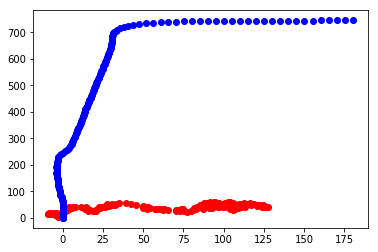

Count:916
()
()
Relative Depth: -36.002618548608325
Relative x: 87.17185130041777
Relative Original Depth: -746.053689921144
Relative Original x: 181.25220652840778
Count:917
()
()
Relative Depth: -36.67334375308954
Relative x: 87.04157491544525
Relative Original Depth: -746.1130828672698
Relative Original x: 182.2497545988082
Count:918
()
()
Relative Depth: -37.487468966528844
Relative x: 86.75681855954377
Relative Original Depth: -746.1688882967204
Relative Original x: 183.24777961695696
Count:919
()
()
Relative Depth: -36.4919412419407
Relative x: 86.66710173851642
Relative Original Depth: -746.1894887933317
Relative Original x: 184.24637072489517
Count:920
()
()
Relative Depth: -37.331346083318934
Relative x: 86.35311017621382
Relative Original Depth: -746.2242895785042
Relative Original x: 185.24486317772792


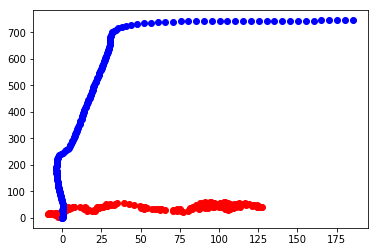

Count:921
()
()
Relative Depth: -38.19144961424323
Relative x: 86.04495003258927
Relative Original Depth: -746.2845035163692
Relative Original x: 186.2411671432776
Count:922
()
()
Relative Depth: -39.04647785554061
Relative x: 85.73661602797941
Relative Original Depth: -746.342129690398
Relative Original x: 187.23809860202152
Count:923
()
()
Relative Depth: -39.84735738081733
Relative x: 85.42935176700847
Relative Original Depth: -746.4324849768016
Relative Original x: 188.23369299406454
Count:924
()
()
Relative Depth: -40.29609937704091
Relative x: 84.92266191160805
Relative Original Depth: -746.4602800726368
Relative Original x: 189.23165985901068
Count:925
()
()
Relative Depth: -40.383117030377335
Relative x: 84.31516671288189
Relative Original Depth: -746.5291765594908
Relative Original x: 190.22811858854445


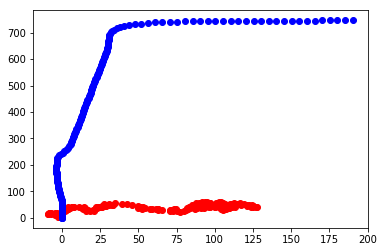

Count:926
()
()
Relative Depth: -40.30555623822306
Relative x: 84.09439941957235
Relative Original Depth: -746.5865872148572
Relative Original x: 191.22603452021818
Count:927
()
()
Relative Depth: -40.195862701213834
Relative x: 84.19366827055039
Relative Original Depth: -746.6530324065558
Relative Original x: 192.2229002123269
Count:928
()
()
Relative Depth: -40.347548041624485
Relative x: 84.36559019596636
Relative Original Depth: -746.7267445846287
Relative Original x: 193.22003554078032
Count:929
()
()
Relative Depth: -41.17487677316664
Relative x: 83.897208354847
Relative Original Depth: -746.7909108723735
Relative Original x: 194.21743018470528
Count:930
()
()
Relative Depth: -41.3377675885243
Relative x: 84.22165124106252
Relative Original Depth: -746.9154199432884
Relative Original x: 195.20950937476533


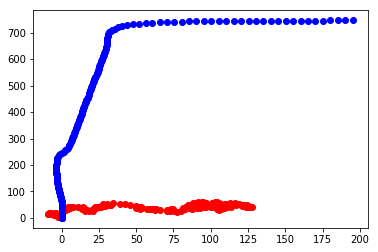

Count:931
()
()
Relative Depth: -41.53999726379425
Relative x: 84.44197404153326
Relative Original Depth: -746.9733905614339
Relative Original x: 196.20723792868387
Count:932
()
()
Relative Depth: -41.9458562040404
Relative x: 84.52727821451104
Relative Original Depth: -747.0218017204928
Relative Original x: 197.20538627510533
Count:933
()
()
Relative Depth: -42.351865270467506
Relative x: 84.36579247463656
Relative Original Depth: -747.1065326166678
Relative Original x: 198.20176576445533
Count:934
()
()
Relative Depth: -42.674136100982565
Relative x: 83.95465135753875
Relative Original Depth: -747.1928788490055
Relative Original x: 199.19629834180287
Count:935
()
()
Relative Depth: -42.99807753915223
Relative x: 83.6379418992304
Relative Original Depth: -747.2205255156114
Relative Original x: 200.19514480739642


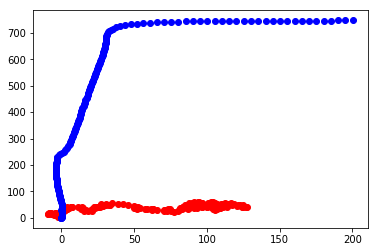

Count:936
()
()
Relative Depth: -43.335202631298046
Relative x: 83.44631195130435
Relative Original Depth: -747.2738586339154
Relative Original x: 201.19327944190226
Count:937
()
()
Relative Depth: -43.58993416927787
Relative x: 83.26468525479022
Relative Original Depth: -747.3205675584969
Relative Original x: 202.1903857228575
Count:938
()
()
Relative Depth: -43.87200905649474
Relative x: 83.0007206517932
Relative Original Depth: -747.3659468145611
Relative Original x: 203.18900356505816
Count:939
()
()
Relative Depth: -44.5137141837201
Relative x: 82.51495822433573
Relative Original Depth: -747.3756808504879
Relative Original x: 204.18837416982217
Count:940
()
()
Relative Depth: -45.27571166276799
Relative x: 81.86741754686348
Relative Original Depth: -747.3676136055549
Relative Original x: 205.18211465570042


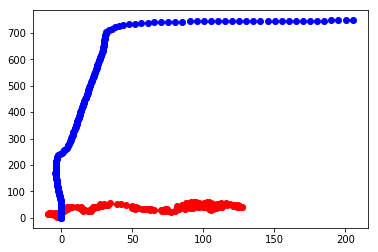

Count:941
()
()
Relative Depth: -46.012639499735954
Relative x: 81.19978333066791
Relative Original Depth: -747.4325873353779
Relative Original x: 206.17922069803987
Count:942
()
()
Relative Depth: -46.74514743842032
Relative x: 80.53594651141795
Relative Original Depth: -747.4817703112426
Relative Original x: 207.17748554132484
Count:943
()
()
Relative Depth: -47.35920245437438
Relative x: 79.90106366307562
Relative Original Depth: -747.5646036585566
Relative Original x: 208.17340551652575
Count:944
()
()
Relative Depth: -47.677995931696465
Relative x: 79.25650168824572
Relative Original Depth: -747.6862343020058
Relative Original x: 209.165164331689
Count:945
()
()
Relative Depth: -47.78979483008305
Relative x: 78.57109393137145
Relative Original Depth: -747.7621297634049
Relative Original x: 210.16139757599055


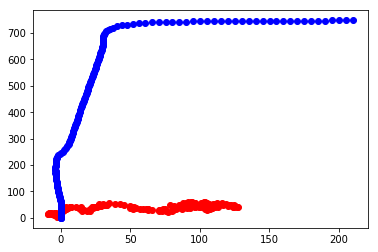

Count:946
()
()
Relative Depth: -47.969026389350695
Relative x: 77.8866154241689
Relative Original Depth: -747.8330759416848
Relative Original x: 211.15724014340594
Count:947
()
()
Relative Depth: -48.14637914435058
Relative x: 77.22218635712734
Relative Original Depth: -747.854847785363
Relative Original x: 212.15552693986928
Count:948
()
()
Relative Depth: -48.42537700614961
Relative x: 76.60890796507628
Relative Original Depth: -747.8937844433913
Relative Original x: 213.15350676578277
Count:949
()
()
Relative Depth: -48.76400495797553
Relative x: 76.02496665916338
Relative Original Depth: -747.9131425895797
Relative Original x: 214.14954029562918
Count:950
()
()
Relative Depth: -48.878651297673095
Relative x: 75.39070049003078
Relative Original Depth: -747.9850849665431
Relative Original x: 215.14512639121557


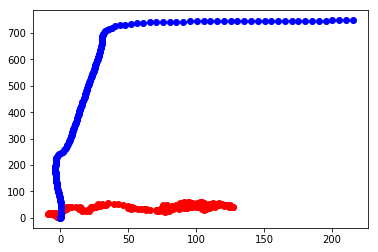

Count:951
()
()
Relative Depth: -48.284339788004374
Relative x: 75.41234921528951
Relative Original Depth: -748.0169803156797
Relative Original x: 216.14423095133841
Count:952
()
()
Relative Depth: -47.54931673151583
Relative x: 75.98563484893721
Relative Original Depth: -748.1106954302875
Relative Original x: 217.1377895342144
Count:953
()
()
Relative Depth: -46.77099388269258
Relative x: 76.455831860261
Relative Original Depth: -748.1571022825991
Relative Original x: 218.135600013279
Count:954
()
()
Relative Depth: -45.99999818763818
Relative x: 76.292498325886
Relative Original Depth: -748.2105257792275
Relative Original x: 219.1325112692661
Count:955
()
()
Relative Depth: -45.23319343491845
Relative x: 76.8238854305197
Relative Original Depth: -748.2747886074566
Relative Original x: 220.12992759164388


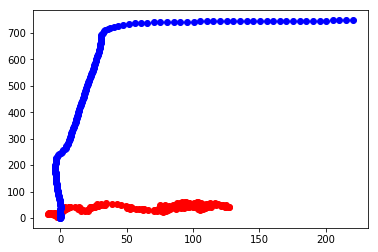

Count:956
()
()
Relative Depth: -44.50251647310421
Relative x: 77.44830086738153
Relative Original Depth: -748.3338759739833
Relative Original x: 221.1281109963264
Count:957
()
()
Relative Depth: -43.96824611698318
Relative x: 78.23988979736569
Relative Original Depth: -748.3939657106798
Relative Original x: 222.12620914401097
Count:958
()
()
Relative Depth: -43.63108510321508
Relative x: 79.10645521082635
Relative Original Depth: -748.4336267384508
Relative Original x: 223.1243484961607
Count:959
()
()
Relative Depth: -43.261478871520865
Relative x: 79.96137814500362
Relative Original Depth: -748.4202443289611
Relative Original x: 224.12164429460745
Count:960
()
()
Relative Depth: -42.81733367999854
Relative x: 80.72476878642003
Relative Original Depth: -748.4480561207741
Relative Original x: 225.11894526046837


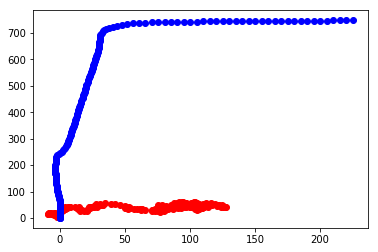

Count:961
()
()
Relative Depth: -42.27321935062725
Relative x: 81.44909872377085
Relative Original Depth: -748.4719476599126
Relative Original x: 226.11555763995142
Count:962
()
()
Relative Depth: -41.66846852901533
Relative x: 82.22498058067406
Relative Original Depth: -748.5247877574287
Relative Original x: 227.11068910446676
Count:963
()
()
Relative Depth: -41.131163756750546
Relative x: 83.06508854853485
Relative Original Depth: -748.5726713220623
Relative Original x: 228.1070195378827
Count:964
()
()
Relative Depth: -40.66292861062513
Relative x: 83.94764169993474
Relative Original Depth: -748.6169615729974
Relative Original x: 229.10429839154534
Count:965
()
()
Relative Depth: -40.219238924727975
Relative x: 84.82737565491314
Relative Original Depth: -748.6926944869145
Relative Original x: 230.1006500798645


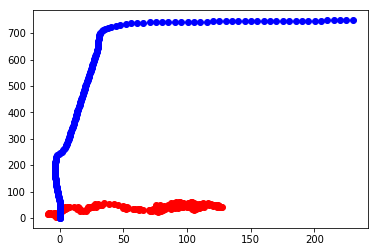

Count:966
()
()
Relative Depth: -39.60858423599844
Relative x: 85.07935656629934
Relative Original Depth: -748.7468883828774
Relative Original x: 231.09903611810586
Count:967
()
()
Relative Depth: -39.338265439004296
Relative x: 85.9274426449387
Relative Original Depth: -748.8121908735558
Relative Original x: 232.09637079718595
Count:968
()
()
Relative Depth: -39.2804259250271
Relative x: 86.73133097881484
Relative Original Depth: -748.8525349329028
Relative Original x: 233.09405985159734
Count:969
()
()
Relative Depth: -39.24918838575582
Relative x: 87.50369446360828
Relative Original Depth: -748.9282477665494
Relative Original x: 234.0901053314227
Count:970
()
()
Relative Depth: -39.191917816700965
Relative x: 88.30361820847536
Relative Original Depth: -748.9553360608497
Relative Original x: 235.0866654871198


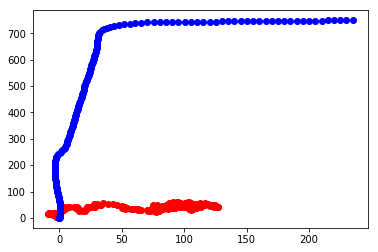

Count:971
()
()
Relative Depth: -39.14747952558553
Relative x: 89.17497804021357
Relative Original Depth: -749.0725514333283
Relative Original x: 236.07831416988668
Count:972
()
()
Relative Depth: -39.17947443603628
Relative x: 90.00043962270189
Relative Original Depth: -749.1105951578911
Relative Original x: 237.0754461398675
Count:973
()
()
Relative Depth: -39.64542990696961
Relative x: 90.43138365344886
Relative Original Depth: -749.1464454773674
Relative Original x: 238.07332845913044
Count:974
()
()
Relative Depth: -40.09580196984304
Relative x: 90.69090325229635
Relative Original Depth: -749.1967731984438
Relative Original x: 239.07036070101825
Count:975
()
()
Relative Depth: -40.1953398054948
Relative x: 91.06871091474493
Relative Original Depth: -749.261090228013
Relative Original x: 240.06780708028597


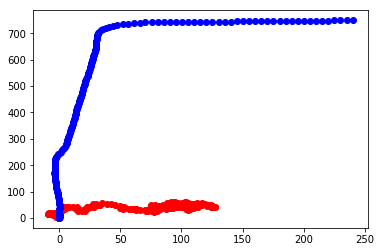

Count:976
()
()
Relative Depth: -40.31084116520385
Relative x: 91.38045409254208
Relative Original Depth: -749.2903964996832
Relative Original x: 241.06569567293687
Count:977
()
()
Relative Depth: -40.49783475346732
Relative x: 91.5957064146327
Relative Original Depth: -749.3676492974621
Relative Original x: 242.06206297901574
Count:978
()
()
Relative Depth: -40.7656673124155
Relative x: 91.72522442059463
Relative Original Depth: -749.4097786536072
Relative Original x: 243.0594399129502
Count:979
()
()
Relative Depth: -41.027010310201135
Relative x: 91.83050660290294
Relative Original Depth: -749.4405539163054
Relative Original x: 244.0574997666235
Count:980
()
()
Relative Depth: -41.15008568871717
Relative x: 92.20186379650454
Relative Original Depth: -749.5163906110558
Relative Original x: 245.05372018779522


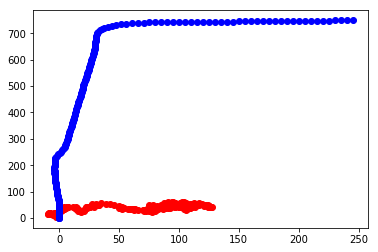

Count:981
()
()
Relative Depth: -41.417497416340346
Relative x: 92.87583872679764
Relative Original Depth: -749.5692799541822
Relative Original x: 246.05131155768626
Count:982
()
()
Relative Depth: -42.11370589048267
Relative x: 93.34717521949396
Relative Original Depth: -749.622883167437
Relative Original x: 247.04831075822557
Count:983
()
()
Relative Depth: -42.85739116053101
Relative x: 93.70463469608288
Relative Original Depth: -749.6860407276532
Relative Original x: 248.0461496249583
Count:984
()
()
Relative Depth: -43.488644924529154
Relative x: 94.2809067582366
Relative Original Depth: -749.7566138496992
Relative Original x: 249.04271982757976
Count:985
()
()
Relative Depth: -44.12883341099274
Relative x: 94.93898185352822
Relative Original Depth: -749.8657565952371
Relative Original x: 250.03640337321002


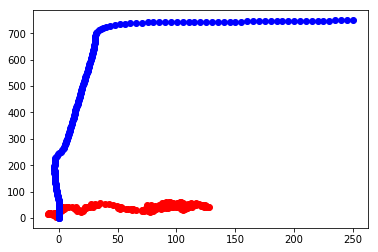

Count:986
()
()
Relative Depth: -44.84659464107578
Relative x: 95.45444432294781
Relative Original Depth: -749.9399010444374
Relative Original x: 251.03250354366767
Count:987
()
()
Relative Depth: -45.62638748751418
Relative x: 95.57835577849822
Relative Original Depth: -750.007094591625
Relative Original x: 252.029984166876
Count:988
()
()
Relative Depth: -46.392307180294914
Relative x: 95.53423810568646
Relative Original Depth: -750.1145979813939
Relative Original x: 253.02322082543847
Count:989
()
()
Relative Depth: -47.100777433239884
Relative x: 95.67067874909168
Relative Original Depth: -750.1652604774569
Relative Original x: 254.02009813642408
Count:990
()
()
Relative Depth: -47.72800769464602
Relative x: 96.02140257086766
Relative Original Depth: -750.2559710829978
Relative Original x: 255.01592408405816


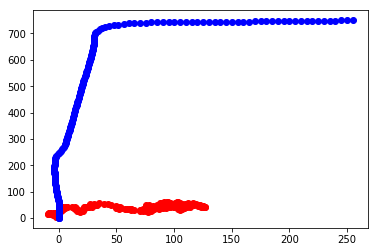

Count:991
()
()
Relative Depth: -48.347782277764665
Relative x: 96.34831112080839
Relative Original Depth: -750.3283629694447
Relative Original x: 256.01314790566005
Count:992
()
()
Relative Depth: -49.09057298380421
Relative x: 95.78005918291777
Relative Original Depth: -750.3449872235616
Relative Original x: 257.0104570512755
Count:993
()
()
Relative Depth: -49.51597571654884
Relative x: 96.23070216312927
Relative Original Depth: -750.4001918264006
Relative Original x: 258.0078750231555
Count:994
()
()
Relative Depth: -49.69448011749963
Relative x: 96.84610198133207
Relative Original Depth: -750.4487353572056
Relative Original x: 259.00634872281006
Count:995
()
()
Relative Depth: -49.83549903181012
Relative x: 97.31291067437438
Relative Original Depth: -750.511058732747
Relative Original x: 260.00383498183606


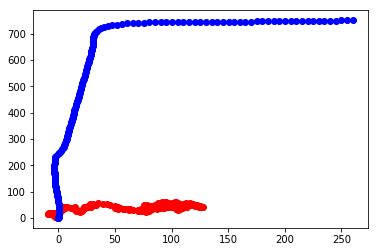

Count:996
()
()
Relative Depth: -49.939123441970224
Relative x: 97.69385140182625
Relative Original Depth: -750.583534972196
Relative Original x: 261.00086668355937
Count:997
()
()
Relative Depth: -49.970143096433624
Relative x: 98.31663229125715
Relative Original Depth: -750.6263205579573
Relative Original x: 261.99852214287927
Count:998
()
()
Relative Depth: -49.69898846843281
Relative x: 99.14727211570064
Relative Original Depth: -750.6955198866054
Relative Original x: 262.99505537997305
Count:999
()
()
Relative Depth: -50.00731224000328
Relative x: 99.80934805806811
Relative Original Depth: -750.7702365367464
Relative Original x: 263.9912593443126
Count:1000
()
()
Relative Depth: -49.4811998642622
Relative x: 100.63697396785427
Relative Original Depth: -750.8301886344083
Relative Original x: 264.98752948976147


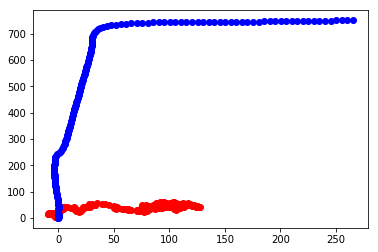

Count:1001
()
()
Relative Depth: -49.407469911844835
Relative x: 101.30381856769051
Relative Original Depth: -750.8919617465999
Relative Original x: 265.98469038308633
Count:1002
()
()
Relative Depth: -48.77287478184382
Relative x: 102.03854650165903
Relative Original Depth: -750.990199234525
Relative Original x: 266.97935876322543
Count:1003
()
()
Relative Depth: -48.06552050871496
Relative x: 102.61255677420854
Relative Original Depth: -751.0846954879354
Relative Original x: 267.9738993945455
Count:1004
()
()
Relative Depth: -47.39691944202395
Relative x: 103.18369258501484
Relative Original Depth: -751.1737853111213
Relative Original x: 268.9694989888356
Count:1005
()
()
Relative Depth: -46.936823561997215
Relative x: 103.66577034083369
Relative Original Depth: -751.1952219209646
Relative Original x: 269.9688166025464


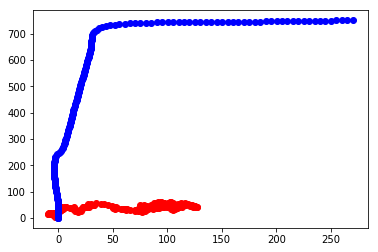

Count:1006
()
()
Relative Depth: -46.69383793186898
Relative x: 104.33336932252894
Relative Original Depth: -751.2475237507854
Relative Original x: 270.9661944192711
Count:1007
()
()
Relative Depth: -47.190438301395254
Relative x: 105.15993917687003
Relative Original Depth: -751.3043050863107
Relative Original x: 271.96357156478655
Count:1008
()
()
Relative Depth: -47.97532111147392
Relative x: 105.7750831634377
Relative Original Depth: -751.3427785150761
Relative Original x: 272.9625460374402
Count:1009
()
()
Relative Depth: -48.72319779418637
Relative x: 106.40478317172646
Relative Original Depth: -751.4142890908244
Relative Original x: 273.95965995311155
Count:1010
()
()
Relative Depth: -49.44217491259742
Relative x: 107.07105397287982
Relative Original Depth: -751.4708117020646
Relative Original x: 274.9574183031268


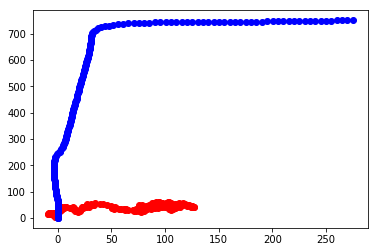

Count:1011
()
()
Relative Depth: -50.08675994336496
Relative x: 107.81854499138733
Relative Original Depth: -751.6098869228858
Relative Original x: 275.9476710566592
Count:1012
()
()
Relative Depth: -50.6710969851309
Relative x: 108.61401726541197
Relative Original Depth: -751.6806058132053
Relative Original x: 276.94387466205905
Count:1013
()
()
Relative Depth: -51.18629754245598
Relative x: 109.47050467859466
Relative Original Depth: -751.6818224191708
Relative Original x: 277.9433849792232
Count:1014
()
()
Relative Depth: -51.79053396433215
Relative x: 110.2137116208908
Relative Original Depth: -751.7049154946592
Relative Original x: 278.94273721636216
Count:1015
()
()
Relative Depth: -52.475141077516966
Relative x: 110.74245834495532
Relative Original Depth: -751.8161462661825
Relative Original x: 279.9364990992704


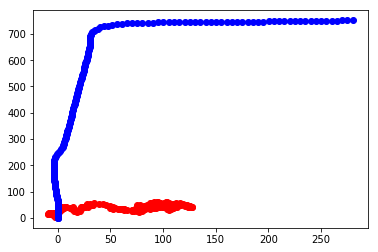

Count:1016
()
()
Relative Depth: -53.154959537867505
Relative x: 111.32235023471976
Relative Original Depth: -751.8476328068992
Relative Original x: 280.93551434469447
Count:1017
()
()
Relative Depth: -53.796407102545565
Relative x: 112.05617582389475
Relative Original Depth: -751.8945779806867
Relative Original x: 281.93404811751816
Count:1018
()
()
Relative Depth: -54.19977215690881
Relative x: 112.96856739872125
Relative Original Depth: -751.9441857687333
Relative Original x: 282.9315915505491
Count:1019
()
()
Relative Depth: -54.54042252433666
Relative x: 113.90612483352409
Relative Original Depth: -752.018612106217
Relative Original x: 283.92720287918706
Count:1020
()
()
Relative Depth: -54.88035857430741
Relative x: 114.82652807405249
Relative Original Depth: -752.1971860591908
Relative Original x: 284.9102606284615


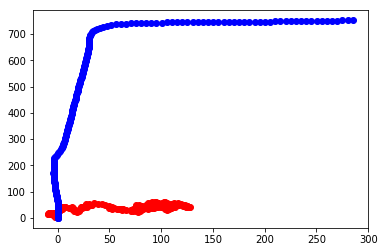

Count:1021
()
()
Relative Depth: -55.11718219077039
Relative x: 115.67951868969239
Relative Original Depth: -752.2673535524077
Relative Original x: 285.90675671310856
Count:1022
()
()
Relative Depth: -55.420631140167224
Relative x: 116.35509984925217
Relative Original Depth: -752.3124476314231
Relative Original x: 286.9036150549224
Count:1023
()
()
Relative Depth: -55.77900865249748
Relative x: 116.9376771488826
Relative Original Depth: -752.3521728884806
Relative Original x: 287.9010628914143
Count:1024
()
()
Relative Depth: -56.33399920875626
Relative x: 117.39283594049093
Relative Original Depth: -752.4185246488265
Relative Original x: 288.8959907529245
Count:1025
()
()
Relative Depth: -56.854441568344775
Relative x: 117.65712456930846
Relative Original Depth: -752.4995691289788
Relative Original x: 289.89194148136824


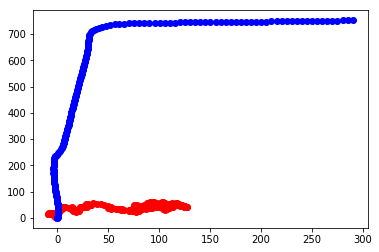

Count:1026
()
()
Relative Depth: -56.52982124435234
Relative x: 118.21448714969377
Relative Original Depth: -752.5315586968677
Relative Original x: 290.89076897898764
Count:1027
()
()
Relative Depth: -56.6876070853588
Relative x: 118.49358155872972
Relative Original Depth: -752.5668300052756
Relative Original x: 291.88835059978715
Count:1028
()
()
Relative Depth: -56.64018237778649
Relative x: 119.08217373921894
Relative Original Depth: -752.6139719844375
Relative Original x: 292.88594582907575
Count:1029
()
()
Relative Depth: -56.16945890022531
Relative x: 119.78269299023214
Relative Original Depth: -752.649958923572
Relative Original x: 293.88427011320744
Count:1030
()
()
Relative Depth: -55.40839078314438
Relative x: 120.38862730639477
Relative Original Depth: -752.6832995284673
Relative Original x: 294.88219693660096


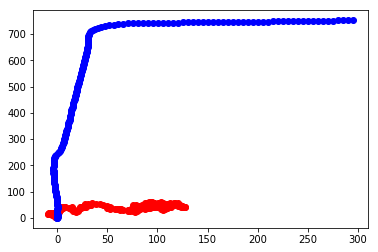

Count:1031
()
()
Relative Depth: -54.63917099739313
Relative x: 120.96771933173099
Relative Original Depth: -752.7294544569091
Relative Original x: 295.88020622795017
Count:1032
()
()
Relative Depth: -53.9628652186239
Relative x: 121.45640937876037
Relative Original Depth: -752.7990063616787
Relative Original x: 296.8770361898215
Count:1033
()
()
Relative Depth: -53.123727718070185
Relative x: 121.9908977654763
Relative Original Depth: -752.8736725207268
Relative Original x: 297.8735136179593
Count:1034
()
()
Relative Depth: -52.52585044476411
Relative x: 122.31743166075182
Relative Original Depth: -752.9256931630716
Relative Original x: 298.86907810239524
Count:1035
()
()
Relative Depth: -51.948929066256696
Relative x: 122.59080285039883
Relative Original Depth: -752.9560045618615
Relative Original x: 299.8655684583257


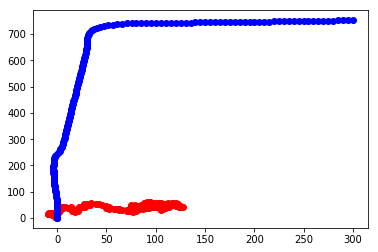

Count:1036
()
()
Relative Depth: -51.398685011858156
Relative x: 122.79971954880264
Relative Original Depth: -753.0077315471766
Relative Original x: 300.86348003245786
Count:1037
()
()
Relative Depth: -50.75599922495005
Relative x: 123.01137797878029
Relative Original Depth: -753.0583504237698
Relative Original x: 301.8621049619766
Count:1038
()
()
Relative Depth: -49.98500152123668
Relative x: 123.1970409264692
Relative Original Depth: -753.1262229284193
Relative Original x: 302.85970050456496
Count:1039
()
()
Relative Depth: -49.298173823452885
Relative x: 123.3793204449003
Relative Original Depth: -753.2082783647243
Relative Original x: 303.8555756297105
Count:1040
()
()
Relative Depth: -48.72057162007378
Relative x: 123.59101888349575
Relative Original Depth: -753.2300913972363
Relative Original x: 304.8538681779057


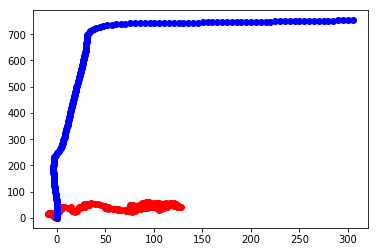

Count:1041
()
()
Relative Depth: -48.73127746321846
Relative x: 123.31840656894258
Relative Original Depth: -753.2821666353454
Relative Original x: 305.85036497358425
Count:1042
()
()
Relative Depth: -48.107502535694316
Relative x: 123.54978565159554
Relative Original Depth: -753.3444566293543
Relative Original x: 306.84749924143375
Count:1043
()
()
Relative Depth: -48.024446437748146
Relative x: 123.41858474216735
Relative Original Depth: -753.3949866557498
Relative Original x: 307.84473403822466
Count:1044
()
()
Relative Depth: -48.39513049106097
Relative x: 122.81425619132318
Relative Original Depth: -753.4040503410181
Relative Original x: 308.8410238538801
Count:1045
()
()
Relative Depth: -48.74521401817331
Relative x: 122.12671794946483
Relative Original Depth: -753.4528652736341
Relative Original x: 309.8377411895462


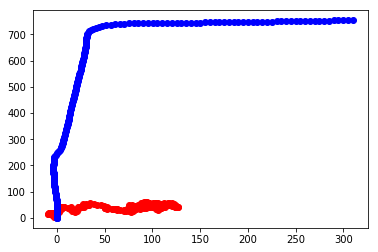

Count:1046
()
()
Relative Depth: -49.21867216199839
Relative x: 121.48738808306402
Relative Original Depth: -753.4990363517601
Relative Original x: 310.83567301253464
Count:1047
()
()
Relative Depth: -49.73984369446677
Relative x: 120.82506774933833
Relative Original Depth: -753.5698246807816
Relative Original x: 311.8326169707608
Count:1048
()
()
Relative Depth: -50.33562287633219
Relative x: 120.1823511964296
Relative Original Depth: -753.6304880122213
Relative Original x: 312.83027107424346
Count:1049
()
()
Relative Depth: -51.01316787908107
Relative x: 119.5373161644199
Relative Original Depth: -753.6576935806286
Relative Original x: 313.82936555752985
Count:1050
()
()
Relative Depth: -51.65922173071693
Relative x: 118.84927281728379
Relative Original Depth: -753.7170529549163
Relative Original x: 314.8273192132143


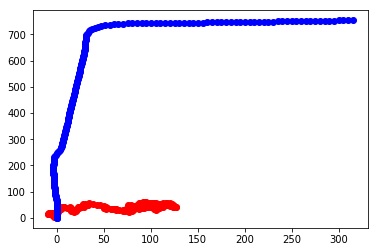

Count:1051
()
()
Relative Depth: -52.24128432920522
Relative x: 118.1440979683112
Relative Original Depth: -753.742342902161
Relative Original x: 315.82633821283576
Count:1052
()
()
Relative Depth: -52.66317743097577
Relative x: 117.46107810917383
Relative Original Depth: -753.7694369716952
Relative Original x: 316.8248396352257
Count:1053
()
()
Relative Depth: -52.92641877070996
Relative x: 116.75046287119007
Relative Original Depth: -753.8018580593547
Relative Original x: 317.8229237479407
Count:1054
()
()
Relative Depth: -53.12875984156277
Relative x: 116.03265007787043
Relative Original Depth: -753.8718725366579
Relative Original x: 318.81987244811563
Count:1055
()
()
Relative Depth: -53.85301397101019
Relative x: 115.72033712706023
Relative Original Depth: -753.897526516461
Relative Original x: 319.8175177637186


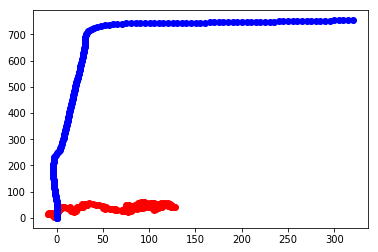

Count:1056
()
()
Relative Depth: -53.8675979942633
Relative x: 115.02193742387439
Relative Original Depth: -753.9457101647811
Relative Original x: 320.81472493499757
Count:1057
()
()
Relative Depth: -53.66163626216436
Relative x: 114.32973214415256
Relative Original Depth: -754.0192245526393
Relative Original x: 321.8104309003952
Count:1058
()
()
Relative Depth: -53.55518932098647
Relative x: 113.54109043921426
Relative Original Depth: -754.0975171904986
Relative Original x: 322.8062819465176
Count:1059
()
()
Relative Depth: -53.323942029582234
Relative x: 112.87278733885276
Relative Original Depth: -754.1462441921774
Relative Original x: 323.8036104934831
Count:1060
()
()
Relative Depth: -52.88248893589212
Relative x: 112.56040773833881
Relative Original Depth: -754.1904690601701
Relative Original x: 324.8007501264008


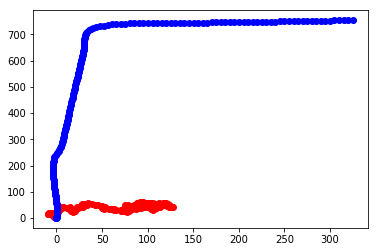

Count:1061
()
()
Relative Depth: -52.32861780225172
Relative x: 112.64290070665564
Relative Original Depth: -754.2465460576135
Relative Original x: 325.79762983491975
Count:1062
()
()
Relative Depth: -51.7354051903489
Relative x: 113.03334277205231
Relative Original Depth: -754.3026828516283
Relative Original x: 326.7947000704801
Count:1063
()
()
Relative Depth: -51.11846351231238
Relative x: 113.47748138686318
Relative Original Depth: -754.3707941465534
Relative Original x: 327.79074870998073
Count:1064
()
()
Relative Depth: -50.55854600872384
Relative x: 114.00621644698634
Relative Original Depth: -754.4046328457841
Relative Original x: 328.7882755649667
Count:1065
()
()
Relative Depth: -50.01456365397715
Relative x: 114.36321603358792
Relative Original Depth: -754.4533161102586
Relative Original x: 329.78546608443156


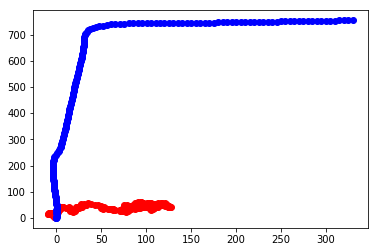

Count:1066
()
()
Relative Depth: -50.983478219611456
Relative x: 114.12067780075844
Relative Original Depth: -754.5031003640544
Relative Original x: 330.782209328657
Count:1067
()
()
Relative Depth: -50.39653880446357
Relative x: 114.44067544964572
Relative Original Depth: -754.608292580659
Relative Original x: 331.77598885147876
Count:1068
()
()
Relative Depth: -49.903208358957166
Relative x: 114.54397645193959
Relative Original Depth: -754.6378297627432
Relative Original x: 332.7741589264454
Count:1069
()
()
Relative Depth: -49.588531269922704
Relative x: 114.34809931266075
Relative Original Depth: -754.7054333988328
Relative Original x: 333.77076126633403
Count:1070
()
()
Relative Depth: -49.31941720703968
Relative x: 114.04370246151852
Relative Original Depth: -754.7528415576385
Relative Original x: 334.768772624555


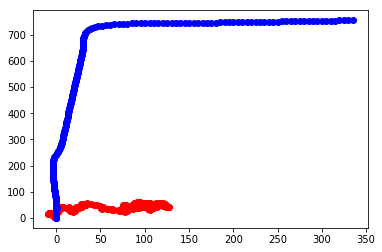

Count:1071
()
()
Relative Depth: -49.11948848005746
Relative x: 113.60289320187232
Relative Original Depth: -754.8625369293188
Relative Original x: 335.7618313123637
Count:1072
()
()
Relative Depth: -48.91596965788513
Relative x: 113.16451426078825
Relative Original Depth: -754.9293525607701
Relative Original x: 336.7583387160614
Count:1073
()
()
Relative Depth: -48.70178655147885
Relative x: 112.765377665595
Relative Original Depth: -754.9593306546203
Relative Original x: 337.756466647723
Count:1074
()
()
Relative Depth: -48.51882676636629
Relative x: 112.45833756901015
Relative Original Depth: -755.0117974901848
Relative Original x: 338.7543073813641
Count:1075
()
()
Relative Depth: -48.36873098511695
Relative x: 112.21814374549977
Relative Original Depth: -755.1200473187911
Relative Original x: 339.7483661739579


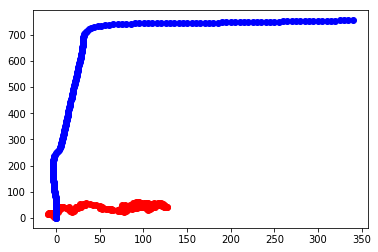

Count:1076
()
()
Relative Depth: -48.4237949733616
Relative x: 111.72432674782098
Relative Original Depth: -755.1751284261748
Relative Original x: 340.7461512173154
Count:1077
()
()
Relative Depth: -48.4831789994315
Relative x: 111.12538015998267
Relative Original Depth: -755.220775732415
Relative Original x: 341.7432701690816
Count:1078
()
()
Relative Depth: -48.50665836020194
Relative x: 110.50302108417148
Relative Original Depth: -755.2417969075689
Relative Original x: 342.7402649630458
Count:1079
()
()
Relative Depth: -48.59636276523868
Relative x: 109.87490270655572
Relative Original Depth: -755.2663716579181
Relative Original x: 343.73964578741897
Count:1080
()
()
Relative Depth: -48.79008727623828
Relative x: 109.18616916402179
Relative Original Depth: -755.3110952401247
Relative Original x: 344.73795150899986


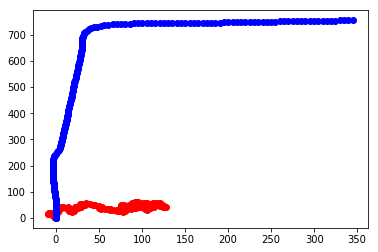

Count:1081
()
()
Relative Depth: -48.83299000648747
Relative x: 108.35773341997901
Relative Original Depth: -755.3738781976103
Relative Original x: 345.7349259536798
Count:1082
()
()
Relative Depth: -48.649944297884
Relative x: 107.42494808276662
Relative Original Depth: -755.4767132100867
Relative Original x: 346.7261715564949
Count:1083
()
()
Relative Depth: -48.67640477144417
Relative x: 106.45648703187344
Relative Original Depth: -755.6357835789903
Relative Original x: 347.7131478751232
Count:1084
()
()
Relative Depth: -48.814824598134734
Relative x: 105.57013250547796
Relative Original Depth: -755.6719443467362
Relative Original x: 348.7105655353609
Count:1085
()
()
Relative Depth: -48.34265595555879
Relative x: 104.78776786908513
Relative Original Depth: -755.7281246738725
Relative Original x: 349.70771020136846


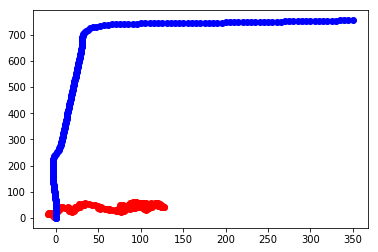

Count:1086
()
()
Relative Depth: -47.770844019826725
Relative x: 104.07031561432798
Relative Original Depth: -755.7883256741326
Relative Original x: 350.7049475148855
Count:1087
()
()
Relative Depth: -47.91975571081506
Relative x: 103.14849330011621
Relative Original Depth: -755.8225887042227
Relative Original x: 351.7033993966038
Count:1088
()
()
Relative Depth: -48.14491659443375
Relative x: 102.24007663326324
Relative Original Depth: -755.8471811828937
Relative Original x: 352.7017385602275
Count:1089
()
()
Relative Depth: -48.39084281262788
Relative x: 101.3234370444807
Relative Original Depth: -755.9271894038573
Relative Original x: 353.6975915774589
Count:1090
()
()
Relative Depth: -48.65852096972725
Relative x: 100.40059425255014
Relative Original Depth: -755.9788478597403
Relative Original x: 354.6961405844054


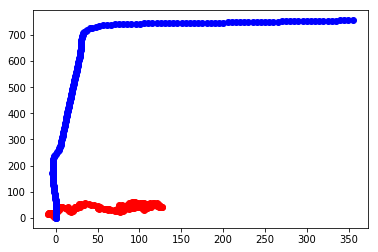

Count:1091
()
()
Relative Depth: -48.94046193978964
Relative x: 99.53191951113543
Relative Original Depth: -756.0028069075669
Relative Original x: 355.6925850211552
Count:1092
()
()
Relative Depth: -48.83926794563175
Relative x: 98.54685830276428
Relative Original Depth: -756.0614068843339
Relative Original x: 356.6888590490472
Count:1093
()
()
Relative Depth: -48.689159030956645
Relative x: 99.51629401767734
Relative Original Depth: -756.1385574239761
Relative Original x: 357.6852194431552
Count:1094
()
()
Relative Depth: -49.02542773450653
Relative x: 99.060433939536
Relative Original Depth: -756.1843207814529
Relative Original x: 358.6839820687927
Count:1095
()
()
Relative Depth: -49.83630613167368
Relative x: 99.05208248793058
Relative Original Depth: -756.2842026500049
Relative Original x: 359.6786727600741


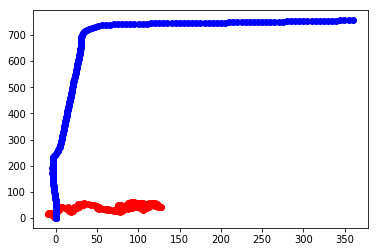

Count:1096
()
()
Relative Depth: -50.29245773569821
Relative x: 98.8712156741403
Relative Original Depth: -756.401556168456
Relative Original x: 360.6702463907016
Count:1097
()
()
Relative Depth: -50.78196245504277
Relative x: 98.6308571181055
Relative Original Depth: -756.5514181385821
Relative Original x: 361.65789650804425
Count:1098
()
()
Relative Depth: -51.387122581207386
Relative x: 98.54016910017026
Relative Original Depth: -756.6694055297894
Relative Original x: 362.648292856821
Count:1099
()
()
Relative Depth: -52.02439173030115
Relative x: 98.5872431630407
Relative Original Depth: -756.7195808221799
Relative Original x: 363.64117239194667
Count:1100
()
()
Relative Depth: -52.295710732496524
Relative x: 99.10962593025047
Relative Original Depth: -756.7829277137349
Relative Original x: 364.6370465335465


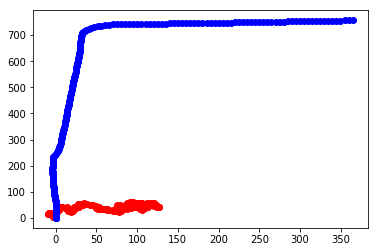

Count:1101
()
()
Relative Depth: -52.051088110443054
Relative x: 99.56515928852475
Relative Original Depth: -756.8715752640088
Relative Original x: 365.62761840098165
Count:1102
()
()
Relative Depth: -51.97640362163104
Relative x: 99.3717801300882
Relative Original Depth: -756.9823797396926
Relative Original x: 366.6195324276291
Count:1103
()
()
Relative Depth: -51.84584447169793
Relative x: 99.52202067497656
Relative Original Depth: -757.0256879453259
Relative Original x: 367.6171141009241
Count:1104
()
()
Relative Depth: -51.26961077667527
Relative x: 100.19656055118453
Relative Original Depth: -757.0521200229028
Relative Original x: 368.6150293928952
Count:1105
()
()
Relative Depth: -50.55754348781058
Relative x: 100.889801364184
Relative Original Depth: -757.1003818429238
Relative Original x: 369.61360592084606


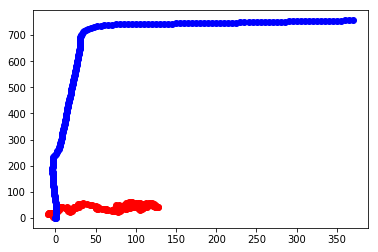

Count:1106
()
()
Relative Depth: -49.87132733120329
Relative x: 101.06732160797623
Relative Original Depth: -757.1542567088478
Relative Original x: 370.6118516106823
Count:1107
()
()
Relative Depth: -49.92822228395008
Relative x: 100.56505554118053
Relative Original Depth: -757.2156132132885
Relative Original x: 371.6098973964639
Count:1108
()
()
Relative Depth: -49.254855914856186
Relative x: 101.26349723208224
Relative Original Depth: -757.2647341283813
Relative Original x: 372.6078977547612
Count:1109
()
()
Relative Depth: -48.6775664188845
Relative x: 102.00653655022747
Relative Original Depth: -757.321935394454
Relative Original x: 373.606080313257
Count:1110
()
()
Relative Depth: -48.388436832103
Relative x: 102.56908989988524
Relative Original Depth: -757.4399984850236
Relative Original x: 374.59648452331044


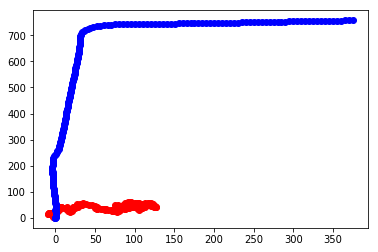

Count:1111
()
()


In [ ]:
count = 1
base_pose = np.identity(4)
original_base_pose = np.identity(4)
x_points = []
z_points = []
original_x_points = []
original_z_points = []
for i in range(25, len(files) - 1):
    
    # get two images and resize them
    (image1, k_matrix) = get_image(files[i])
    (image2, k_matrix) = get_image(files[i+1])
    image1 = np.ascontiguousarray(image1, dtype=np.uint8)
    image2 = np.ascontiguousarray(image2, dtype=np.uint8)
    
    # convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    gray1 = gray1[150:750, :]
    gray2 = gray2[150:750, :]
    
    # get keypoints
    (ptsLeft, ptsRight) = get_keypoints(gray1, gray2)
    
    # get fundamental matrix
    (fundamental_matrix, best_ptsLeft, best_ptsRight) = get_fundamental_matrix_ransac(ptsLeft.copy(), ptsRight.copy())
    if(len(best_ptsLeft) < 5):
        continue
    
    # get essential matrix (from opencv and without opencv)
    essential_matrix = get_essential_matrix(fundamental_matrix, k_matrix)
    original_essential_matrix, _ = cv2.findEssentialMat(np.array(ptsLeft), np.array(ptsRight), focal = k_matrix[0, 0], pp = (k_matrix[0, 2], k_matrix[1, 2]), method = cv2.RANSAC, prob = 0.999, threshold = 0.5)
    
    # get camera poses
    matrices = get_camera_poses(essential_matrix)
    translation_matrices = np.array(matrices[0])
    rotation_matrices = np.array(matrices[1])
    
    # get best pose (with opencv and without opencv)
    best_camera_pose = get_best_camera_pose(translation_matrices, rotation_matrices, np.identity(4), best_ptsLeft, best_ptsRight)
    best_camera_pose = np.vstack([best_camera_pose, np.matrix([0, 0, 0, 1], dtype=np.float)])
    _, original_rotation_matrix, original_translation_matrix, mask = cv2.recoverPose(original_essential_matrix, np.array(ptsLeft), np.array(ptsRight), focal = k_matrix[0, 0], pp = (k_matrix[0, 2], k_matrix[1, 2]))
    if(np.linalg.det(original_rotation_matrix) < 0):
        original_rotation_matrix = -original_rotation_matrix
        original_translation_matrix = -original_translation_matrix
    original_pose = np.hstack([original_rotation_matrix, original_translation_matrix])
    original_pose = np.vstack([original_pose, np.matrix([0, 0, 0, 1], dtype=np.float)])
        
    # update the base pose for further frame calculation
    original_base_pose = np.dot(original_base_pose, original_pose)
    base_pose = np.dot(base_pose, best_camera_pose)
    print("Relative Depth: " + str(base_pose[2, 3]))
    print("Relative x: " + str(base_pose[0, 3]))
    print("Relative Original Depth: " + str(original_base_pose[2, 3]))
    print("Relative Original x: " + str(original_base_pose[0, 3]))
    if(count % 5 == 0):
        original_x_points.append(original_base_pose[0, 3])
        original_z_points.append(-original_base_pose[2, 3])
        x_points.append(base_pose[0, 3])
        z_points.append(-base_pose[2, 3])
        
        # plot
        plt.plot(x_points, z_points, 'o', color='r')
        plt.plot(original_x_points, original_z_points, 'o', color='b')
        plt.show()
        
    count = count + 1
    print("Count:" + str(count))
    print()
    print()
    #if(count > 10):
    #    break

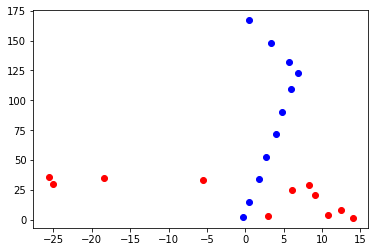

In [25]:
from matplotlib import pyplot as plt
plt.plot(x_points, z_points, 'o', color='r')
plt.plot(original_x_points, original_z_points, 'o', color='b')
#plt.xlim(0, 600)
#plt.ylim(0, 600)
plt.show()

In [114]:
print(x_points)
print(z_points)
#print(original_x_points)
#print(original_z_points)

[-1.1891879810991943, -4.768916213677255, -5.1128637057787545, 3.438234860315185, 1.467948776585641, -6.562654016282714, -15.255779792665114, -30.191699608175778, -34.7249646351428, -22.38452297267011, -26.785426940408374, -22.196083983370386, -26.826390969830722, -19.876446944357482, -27.849827886938918, -26.45864645972883, -18.475726551915866, -20.035833488910022, -31.987520891240564, -40.84046093492509, -42.55250326700028, -43.66439032862367, -48.34988378385913, -41.672760394919635, -31.02991610761185, -30.108274423225215, -32.85781792186625, -31.89628859523475, -23.42101049288415, -16.146304031195875, -15.972199078525415, -14.073431380456332, -23.35145994395795, -24.799592762410892, -22.711016437294287, -29.240531203542222, -26.381693149588504, -9.813562075017243, -4.900479744710041, -6.219152644367176, -12.782942614182753, -9.318648350280393, -11.283888899490854, -14.571051391977454, -17.740984374233662, -31.283079297933863, -31.966710833502297, -21.056252612061076, -20.6082404833